## **Incremental Active-Learning Approach**

In [ ]:
# Installing required libraries

# !pip install modAL-python --quiet
# !pip install git+https://github.com/scikit-learn-contrib/forest-confidence-interval.git  --quiet
# !pip install xgboost --quiet
# !pip install ipython-autotime  --quiet
# !pip install shap --quiet
# !pip install mapie --quiet
# %load_ext autotime

In [2]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import forestci as fci

# import gdown

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from itertools import cycle
from timeit import default_timer as timer

import warnings
from collections import defaultdict

import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

import shap

import random
from scipy import stats

import tqdm as tqdm

Failed to import duecredit due to No module named 'duecredit'


In [3]:
shap.initjs() # Initialize SHAP for later

## **Utility functions**

In [ ]:
# Utility function for accessing and formating the input dataframes.
# Dataframe df is assumed to be preprocessed already
def get_regression_data(df, target, cols=None, # Target columns
                        tactics=True, embeddings=True, # Flags to select tactic encoding, embeddings encoding, or both
                        split_by_level=True): # If True, the dataset is split into batches (for active learning)
  '''Prepares data for regression tasks.

  This function extracts features and target variables from a dataframe,
  optionally splitting the data into batches for active learning.

  Args:
    df: The input dataframe containing features and target variables.
    target: A list of column names representing the target variables.
    cols: A list of column names to include as features (default: None).
    tactics: A boolean flag indicating whether to include tactic encoding features (default: True).
    embeddings: A boolean flag indicating whether to include embeddings encoding features (default: True).
    split_by_level: A boolean flag indicating whether to split the data into batches based on the 'level' column (default: True).

  Returns:
    A tuple containing:
      - X_list: A list of feature matrices, or a single feature matrix if split_by_level is False.
      - y_list: A list of target variable arrays, or a single target variable array if split_by_level is False.
      - fnames: A list of feature names.
  '''

  if cols is None:
    cols = target
  temp = df.columns
  cols = cols+['solID']
  for t in target:
    if t in cols:
      cols.remove(t)
  if 'bot' in temp:
    cols.append('bot')
  if not tactics:
    tactic_cols = [c for c in temp if c.startswith('op')]
    for c in tactic_cols:
      cols.append(c)
  if not embeddings:
    emb_cols = [c for c in temp if c.startswith('emb')]
    for c in emb_cols:
      cols.append(c)

  X = df.drop(cols, axis=1)
  if len(target) == 1:
    y = df[target[0]]
  else:
    y = df[target]

  if split_by_level:
    levels = set(X['level'])
    X_list = []
    y_list = []
    for l in levels:
      #print(l)
      df_level = X[X['level'] == l]
      X_list.append(df_level.drop(['level']+target, axis=1).values)
      y_list.append(df_level[target].values)
  else:
    X_list = X.drop(['level']+target, axis=1).values
    if len(target) == 1:
      y_list = X[target[0]].values
    else:
      y_list = X[target].values

  fnames = list(X.columns)
  fnames.remove('level')
  for t in target:
    fnames.remove(t)

  return X_list, y_list, fnames

# Divides a column (or range) in n bins
def get_bins(col, n, min_max=(None,None)):
    """Divides a column into bins.

    This function divides a column (or range) into n bins.
    It calculates the bin edges based on the unique values in the column
    and the specified number of bins.

    Args:
        col: The column (pandas Series) to be divided into bins.
        n: The number of bins to create.
        min_max: Tuple (min, max) representing the minimum and maximum values
                 for the bins. If None, the minimum and maximum values of the
                 column are used (default: (None, None)).

    Returns:
        A list of bin edges.
    """

    unique_values = sorted((set(col.values)))
    if min_max == (None,None):
        min_x = np.min(unique_values)
        max_x = np.max(unique_values)
    else:
        print("Using predefined limits",min_max)
        min_x = min_max[0]
        max_x = min_max[1]
    min_x = min_x - 0.1
    max_x = max_x + 0.1
    delta = (max_x - min_x)/n
    #print(min_x, max_x, delta)
    return ([min_x+i*delta for i in range(0,n)] + [max_x])

# Utility function for plotting the distribution of the quality-attribute objectives (regression targets)
def plot_outcome_distribution(df_outcomes, n_bins=100, labels=5, filename=None, mins_maxs=(None,None),
                              colors=['blue', 'red', 'green', 'orange'], figsize=(8,8)):
    """Plots the distribution of quality-attribute objectives.

    This function creates a histogram to visualize the distribution of
    quality-attribute objectives (regression targets) in a given dataframe.
    It allows for customization of the number of bins, labels, and colors.
    The plot can be saved to a file if a filename is provided.

    Args:
        df_outcomes: Dataframe containing the quality-attribute objectives.
        n_bins: The number of bins for the histogram (default: 100).
        labels: The number of labels to display on the x-axis (default: 5).
        filename: The filename to save the plot to (default: None).
        mins_maxs: A list or tuple of (min, max) values to define the range of the x-axis for each subplot. If None, the minimum and maximum values of the column are used (default: (None, None)).
        colors: A list of colors to use for the histograms (default: ['blue', 'red', 'green', 'orange']).
        figsize: The size of the figure (default: (8, 8)).
    """

    qas = list(df_outcomes.columns)

    fig, axs = plt.subplots(len(qas), 1, sharey=True, tight_layout=True, figsize=figsize)
    for idx, qa in enumerate(qas):
        col = df_outcomes[qa]
        min_max = (None,None)
        if mins_maxs != (None,None):
            min_max = mins_maxs[idx]
            #print(min_max)
        col_range = get_bins(col, labels, min_max)
        print(qa, col_range)
        if min_max != (None,None):
            col = col.tolist()
            col.append(min_max[0])
            col.append(min_max[1])
        axs[idx].hist(col, bins=n_bins, color=colors[idx])
        axs[idx].set_title(qa)
        for xc in col_range:
            axs[idx].axvline(x=xc, color='gray', linestyle='dashed')

    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
def compute_regression_metrics(y, y_pred):
  """Computes regression metrics.

  This function calculates common regression metrics to evaluate the
  performance of a regression model.

  Args:
      y: The true target values.
      y_pred: The predicted target values.

  Returns:
      A dictionary containing the computed metrics:
          - R2: R-squared (coefficient of determination)
          - MSE: Mean squared error
          - RMSE: Root mean squared error
          - MAE: Mean absolute error
          - MAPE: Mean absolute percentage error
  """

  metrics = dict()

  metrics['R2'] = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  metrics['MSE'] = mse
  metrics['RMSE'] = np.sqrt(mse)
  metrics['MAE'] = mean_absolute_error(y, y_pred)
  metrics['MAPE'] = mean_absolute_percentage_error(y, y_pred)

  return metrics

# Creates a grid of charts showing the prediction errors of a regression (actual versus predicted values)
# The charts also include some regression metrics (e.g., R2, RMSE, MAE, MAPE)
# Optionally, specific values can be marked with stars (e.g., for distinguishing the sub-sampling strategy)
# Plots can be saved to a file
def show_prediction_errors_multioutput(y, y_pred, target, colors=['blue'], y_query=None, y_query_pred=None,
                                       metrics=True, x=1, verbose=True, title=None,
                                       gridsize=(1,4), errors=None, filename=None):
  """Creates a grid of charts showing prediction errors for multi-output regression.

    This function visualizes the prediction errors of a regression model with
    multiple output variables. It displays actual vs. predicted values using
    scatter plots and includes regression metrics like R2, RMSE, MAE, and MAPE.
    Optionally, it can highlight specific data points and save the plots to a file.

    Args:
        y: The true target values (NumPy array).
        y_pred: The predicted target values (NumPy array).
        target: A list of target variable names.
        colors: A list of colors for the scatter plots (default: ['blue']).
        y_query: Optional true target values for specific data points to highlight (default: None).
        y_query_pred: Optional predicted target values for specific data points to highlight (default: None).
        metrics: A boolean flag indicating whether to display regression metrics (default: True).
        verbose: A boolean flag indicating whether to print detailed metrics (default: True).
        title: An optional title for the plot (default: None).
        gridsize: A tuple specifying the number of rows and columns in the plot grid (default: (1, 4)).
        errors: Optional error bars for highlighted data points (default: None).
        filename: An optional filename to save the plot to (default: None).
  """

  for idx, n in enumerate(target):
    if verbose:
      print("-->", n)
      metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])
      for m in metrics.keys():
        print(m+"=", metrics[m])
  if verbose:
    print()

  n = len(target)
  fig, axs = plt.subplots(nrows=gridsize[0], ncols=gridsize[1], figsize=(4*gridsize[1], 4*gridsize[0]))
  for idx, n in enumerate(target):
    if len(colors) == 1:
      c = colors[0]
    else:
      c = colors[idx]
    j = idx % gridsize[1]
    i = idx // gridsize[1]
    #print("ax:", idx, i, j)
    if gridsize[0] == 1:
      ax = axs[j]
    else:
      ax = axs[i][j]
    PredictionErrorDisplay.from_predictions(
      y_true=y[:,idx],
      y_pred=y_pred[:,idx],
      kind="actual_vs_predicted",
      subsample=None,
      ax=ax, #axs[idx], #ax=axs[0][idx],
      random_state=0, scatter_kwargs={"alpha": 0.5, "color": c}
    )

    ax.set_title(n)
    if y_query is not None:
      if errors is not None:
        ax.errorbar(y_query_pred[:,idx], y_query[:,idx], yerr=errors, fmt="o", ecolor="gray", capsize=3, alpha=0.5)
      ax.scatter(y_query_pred[:,idx], y_query[:,idx], c='red', marker='*', s=80, alpha=0.5)

    # Add the score in the legend of each axis
    metrics = compute_regression_metrics(y[:,idx], y_pred[:,idx])

    r2_patch = mpatches.Patch(color='none', label='R2='+str(round(metrics['R2'], 2)))
    rmse_patch = mpatches.Patch(color='none', label='RMSE='+str(round(metrics['RMSE'], 2)))
    mae_patch = mpatches.Patch(color='none', label='MAE='+str(round(metrics['MAE'], 2)))
    mape_patch = mpatches.Patch(color='none', label='MAPE='+str(round(metrics['MAPE'], 2)))
    m_patches = [r2_patch, rmse_patch, mae_patch, mape_patch]
    if metrics:
      ax.legend(handles=m_patches)

  if filename is not None:
    plt.tight_layout()
    plt.savefig(filename, format='pdf')
  if title is not None:
    fig.suptitle(title)
  if filename is None:
    plt.tight_layout()
  plt.show()

In [6]:
def show_shap_plots(X, fnames, model, targets):
  """Displays SHAP bar plots for feature importance.

  This function utilizes the SHAP (SHapley Additive exPlanations) library to
  calculate and visualize the importance of features in a prediction model.
  It generates bar plots showing the impact of each feature on the model's output.

  Args:
      X: The input data (NumPy array or Pandas DataFrame).
      fnames: A list of feature names corresponding to the columns in X.
      model: The trained prediction model.
      targets: A list of target variable names.
  """

  df = pd.DataFrame(X, columns=fnames)
  explainer = shap.Explainer(model)
  shap_values = explainer(df)
  for i in range(shap_values.shape[2]):  # If shap_values is for multiple outputs
    print("Target:", targets[i])
    output_shap_values = shap_values[:, :, i]
    shap.plots.bar(output_shap_values, max_display=15)

## **Load datasets**

In [ ]:
# Datasets are assumed to be already pre-processed/encoded
STPLUS_DATAPATH = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/datasets/stplus-levels-bots-features.csv'
COCOME_DATAPATH = 'https://raw.githubusercontent.com/andresdp/architecture-surrogates/refs/heads/main/datasets/cocome-levels-features.csv'

OBJ_STPLUS= ['m1', 'm2', 'p1', 'p2']
OBJ_COCOME = ['m1', 'm2', 'm3', 'm4','p1', 'p2', 'p3', 'p4']

# print(gdown.download(STPLUS_URL, STPLUS_DATAPATH, quiet=True))
# print(gdown.download(COCOME_URL, COCOME_DATAPATH, quiet=True))

In [8]:
df_stplus = pd.read_csv(STPLUS_DATAPATH, index_col=0)
print(df_stplus.shape)
df_stplus.head() # raw ST+ dataset

(454, 741)


solID     m1     m2        p1       p2  level            bot  \
0  sol-arch_270  115.0  291.5  24.37365  29.9622      2  Modifiability   
1   sol-arch_81  119.0  110.5  14.12836  21.8758      2  Modifiability   
2  sol-arch_103  115.0  190.5  18.76987  33.9213      2  Modifiability   
3  sol-arch_508  119.0  231.5  16.93228  26.7557      2    Performance   
4  sol-arch_182  115.0  190.5  21.48976  26.6179      2  Modifiability   

   op1_mod-split(PaymentSystem)-wrapper(IBooking)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   op1_mod-split(PaymentSystem)-wrapper(IBusinessTrip)  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   op1_mod-split(PaymentSystem)-wrapper(IEmployeePayment)  ...  emb_490_0  \
0                                                  0       ...        0.0   
1                                                  0       ...        0.0   
2                                                  0       ...        0.0   
3                                                  0       ...        0.0   
4                                                  0       ...        0.0   

   emb_491_0  emb_492_0  emb_493_0  emb_494_0  emb_495_0  emb_496_0  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   emb_497_0  emb_498_0  emb_499_0  
0        0.0        0.0        0.0  
1        0.0        0.0        0.0  
2        0.0        0.0        0.0  
3        0.0        0.0        0.0  
4        0.0        0.0        0.0  

[5 rows x 741 columns]

In [9]:
df_cocome = pd.read_csv(COCOME_DATAPATH, index_col=0)
print(df_cocome.shape)
df_cocome # raw CoCoME dataset

(1192, 929)


solID      m1     m2     m3      m4        p1        p2  \
0     sol-arch_1004  2218.0  727.0  137.5  2172.5  0.897089  1.071037   
1      sol-arch_401  2333.0  750.5  161.0  2216.5  1.298680  1.550426   
2      sol-arch_137  2262.0  731.5  142.0  2216.5  0.976805  1.124319   
3      sol-arch_453  2333.0  798.0  208.5  2216.5  1.052553  1.226608   
4      sol-arch_404  2333.0  798.0  208.5  2216.5  1.052553  1.226608   
...             ...     ...    ...    ...     ...       ...       ...   
1187  sol-arch_1174  2289.0  802.5  204.0  2172.5  0.832682  0.937078   
1188   sol-arch_187  2289.0  802.5  181.0  2172.5  1.233312  1.676923   
1189   sol-arch_674  2289.0  802.5  208.5  2172.5  0.965911  1.173523   
1190   sol-arch_821  2261.0  730.5  142.0  2215.5  1.031333  1.187748   
1191   sol-arch_183  2289.0  798.0  208.5  2172.5  1.011518  1.172144   

            p3        p4  level  ...  emb_490_0  emb_491_0  emb_492_0  \
0     1.025776  1.901695      5  ...        0.0        0.0        0.0   
1     1.706878  2.576643      2  ...        0.0        0.0        0.0   
2     1.214135  1.853881      2  ...        0.0        0.0        0.0   
3     1.160202  2.045067      2  ...        0.0        0.0        0.0   
4     1.160202  2.045067      2  ...        0.0        0.0        0.0   
...        ...       ...    ...  ...        ...        ...        ...   
1187  1.117719  1.435772      5  ...        0.0        0.0        0.0   
1188  1.305529  3.288065      2  ...        0.0        0.0        0.0   
1189  0.926582  2.053899      3  ...        0.0        0.0        0.0   
1190  1.737787  2.023827      4  ...        0.0        0.0        0.0   
1191  0.978149  2.080299      2  ...        0.0        0.0        0.0   

      emb_493_0  emb_494_0  emb_495_0  emb_496_0  emb_497_0  emb_498_0  \
0           0.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        0.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        0.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        0.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        0.0        0.0   
...         ...        ...        ...        ...        ...        ...   
1187        0.0        0.0        0.0        0.0        0.0        0.0   
1188        0.0        0.0        0.0        0.0        0.0        0.0   
1189        0.0        0.0        0.0        0.0        0.0        0.0   
1190        0.0        0.0        0.0        0.0        0.0        0.0   
1191        0.0        0.0        0.0        0.0        0.0        0.0   

      emb_499_0  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
1187        0.0  
1188        0.0  
1189        0.0  
1190        0.0  
1191        0.0  

[1192 rows x 929 columns]

In [ ]:
# Show distribution of quality-attribute objectives for ST+
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_stplus_df = pd.DataFrame(scaler.fit_transform(df_stplus[OBJ_STPLUS]), columns=OBJ_STPLUS)
# make_boxplots(scaled_stplus_df, title='STPlus (scaled)', figsize=(400, 900))

In [ ]:
# Show distribution of quality-attribute objectives for CoCoME
scaler = StandardScaler() # Objectives are first standardized using Z-score method
scaled_cocome_df = pd.DataFrame(scaler.fit_transform(df_cocome[OBJ_COCOME]), columns=OBJ_COCOME)
# make_boxplots(scaled_cocome_df, title='CoCoME (scaled)', figsize=(400, 1600))

## **Experiments with the dataset arranged in batches**

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# Implementation of CV+ strategy for regressors (RF or XGBoost)
# It returns the instances of X with the largest prediction error (uncertainty)
def mapie_regression_std(estimator, X_test, X_train, y_train, targets, k=20, random_selection=False): #, alpha=0.05, cv=10):

  """Implements the CV+ strategy for regression uncertainty estimation.

  This function uses the MAPIE (Model Agnostic Prediction Interval Estimator) library
  to estimate prediction intervals for regression models. It specifically implements the
  Conformalized Quantile Regression (CQR) method with the 'plus' strategy (CV+).
  It identifies the instances in X_test with the largest prediction errors (uncertainty)
  based on the estimated prediction intervals.

  Args:
      estimator: The trained regression model (e.g., RandomForestRegressor, XGBRegressor).
      X_test: The feature matrix for the test set.
      X_train: The feature matrix for the training set.
      y_train: The target variable array for the training set.
      targets: A list of target variable names.
      k: The number of instances to select with the largest prediction errors (default: 20).
      random_selection: If True, select indices randomly (default: False)

  Returns:
      A tuple containing:
          - indices: The indices of the k instances in X_test with the largest prediction errors.
          - total_errors: The prediction errors for all instances in X_test.
  """

  errors_df = pd.DataFrame()
  for idx, t in enumerate(targets):
    # model = estimator.estimator
    model = sklearn.base.clone(estimator.estimator)
    mapie_regressor = MapieRegressor(estimator=model, method='plus', cv=10)
    mapie_regressor = mapie_regressor.fit(X_train, y_train[:,idx])
    _, y_pis_idx = mapie_regressor.predict(X_test, alpha=0.05)
    bounds = [(x[0][0], x[1][0]) for x in y_pis_idx]
    error_idx = [(sup-inf) for (inf, sup) in bounds]
    errors_df[t] = error_idx

  # total_errors = errors_df.sum(axis=1).to_numpy()
  total_errors = errors_df.max(axis=1).to_numpy()
  if not random_selection:
    indices = np.argpartition(total_errors, -k)[-k:] # Indices of the values with highest predicted errors
  else: # Alternatively, indices can be selected randomly
    print("Selecting indices at random!")
    random.seed(14)
    indices = random.sample(range(len(total_errors)), k)
  return indices, total_errors


In [ ]:
# Implementation of sub-sampling strategy for RF regressor (it doesn't work for XGBoost)
# It returns the instances of X with the largest prediction error
# Prediction errors are estimated using fci library
def rf_regression_std(estimator, X, x_shape, target, y_pred, k=20, calibration=True):

  """Estimates prediction errors for a RandomForestRegressor using the forestci library.

  This function calculates prediction errors for a RandomForestRegressor model
  using the `forestci` library. It estimates the variance of predictions and
  identifies the instances in X with the largest prediction errors (uncertainty).
  It is specifically designed for RandomForestRegressor and may not be suitable for other models.

  Args:
      estimator: The trained RandomForestRegressor model.
      X: The feature matrix for which to estimate prediction errors.
      x_shape: The shape of the original training data's feature matrix.
      target: A list of target variable names.
      y_pred: The predicted target values.
      k: The number of instances to select with the largest prediction errors (default: 20).
      calibration: A boolean flag indicating whether to calibrate the prediction errors
                   (default: True). Calibration can improve the accuracy of error estimates.

  Returns:
      A tuple containing:
          - indices: The indices of the k instances in X with the largest prediction errors.
          - total_error: The estimated prediction errors for all instances in X.
  """

  #print("calibration enabled?", calibration, x_shape)
  total_error = np.zeros(X.shape[0])
  # Initialize a list to store the worst errors for each target variable
  worst_errors = []
  for idx in range(len(target)):
    error = fci.random_forest_error(estimator.estimator, x_shape, X, calibrate=calibration, inbag=None, y_output=idx)
    total_error = np.sum([total_error, abs(error)], axis=0) # If calibration is False, errors could have negative values
    # Store the largest error for the current target variable
    # worst_errors.append(np.max(error))  # Append the largest error to the list

  # Combine the worst errors into a single array
  # total_error = np.array(worst_errors)

  indices = np.argpartition(total_error, -k)[-k:] # Indices of the values with highest predicted errors
  return indices, total_error

In [ ]:
# It runs the whole dataset divided into batched, and applies a RF regressor on each batch
def run_active_learning_batches(X_batches, y_batches, regressor, n_queries=0.2, show_plots=None, target=None,
                                calibration=True, verbose=True, scale_y=True, show_errors=False, filename=None):
  """Executes active learning on data divided into batches.

  This function implements an active learning loop using data organized in batches.
  It iteratively trains a regressor on an initial batch and then selects the most
  informative instances from subsequent batches to add to the training set.
  It uses a query strategy to identify these instances, aiming to improve model
  performance with fewer labeled data points. The function also provides options for
  visualizing prediction errors, scaling the target variable, and controlling the level
  of detail in the output.

  Args:
      X_batches: A list of feature matrices, each representing a batch of data.
      y_batches: A list of target variable arrays corresponding to the feature matrices in X_batches.
      regressor: The regression model to use (e.g., RandomForestRegressor, XGBRegressor).
      n_queries: The proportion or number of instances to query from each batch (default: 0.2).
      show_plots: A tuple specifying the grid size for prediction error plots (e.g., (1, 4)). If None, plots are not shown.
      target: A list of target variable names.
      calibration: A boolean flag indicating whether to calibrate prediction errors (default: True).
      verbose: A boolean flag indicating whether to print detailed metrics (default: True).
      scale_y: A boolean flag indicating whether to scale the target variable using StandardScaler (default: True).
      show_errors: A boolean flag indicating whether to show error bars in prediction error plots (default: False).
      filename: An optional filename to save the final prediction error plot to (default: None).

  Returns:
      A tuple containing:
          - dict_metrics: A dictionary containing the computed regression metrics for each batch and the overall results.
          - y_pred_flat: The predicted target values for all instances in all batches, concatenated into a single array.
  """

  dict_metrics = defaultdict(list)
  start = timer()

  if scale_y:
    print("standard scaling y ...", len(y_batches))
    scaler = StandardScaler()
    for i in range(len(y_batches)):
      y_batches[i] = scaler.fit_transform(y_batches[i])

  print('max', n_queries, 'percentage - queries')
  y_pred_batches = []

  print('='*10)
  X1 = X_batches[0]
  y1 = y_batches[0]
  k = X1.shape[0]
  #print(k)

  # Assembling initial training set (level 1)
  print('Batch 0:', X1.shape, y1.shape)
  n1 = y1.shape[0]
  n_oracle = n1
  dict_metrics['exp'] = dict_metrics['exp'] + ['incremental - batch 0']
  dict_metrics['size'] = dict_metrics['size'] + [X1.shape[0]]
  dict_metrics['features'] = dict_metrics['features'] + [X1.shape[1]]
  dict_metrics['queries'] = dict_metrics['queries'] + [n1]

  start1 = timer()
  # initializing the active learner (level 1)
  query_strategy = mapie_regression_std # mapie_regression_std # rf_regression_std
  learner = ActiveLearner(bootstrap_init=True,
    estimator=regressor, query_strategy=query_strategy,
    X_training=X1, y_training=y1
  )

  y_pred1 = learner.predict(X1)
  y_pred_batches.append(y_pred1)

  end1 = timer()
  elapsed_time1 = end1 - start1
  dict_metrics['time'] = dict_metrics['time'] + [elapsed_time1]

  # plotting the initial estimation (level 1)
  title = 'Batch 0: Initial training with {0} points - {1} instances'.format(n1, n1)
  print(title)
  print("Regressor score=%.2f " % regressor.score(X1, y_pred1))
  print()
  if show_plots is not None:
    show_prediction_errors_multioutput(y1, y_pred1, target=target, colors=['red'],
                                       title=title, verbose=verbose, gridsize=show_plots)
    print()

  print("Initial metrics:")
  metrics = compute_regression_metrics(y1, y_pred1)
  for m in metrics.keys():
    dict_metrics[m] = dict_metrics[m] + [metrics[m]]
    print(m+"=", metrics[m])

  # Iterations of incremental/active learning
  x_shape = X1.shape
  for i in range(1,len(X)):
    print()
    print('='*10)
    # active learning
    start1 = timer()

    X2 = X_batches[i]
    y2 = y_batches[i]
    print('Batch ',i,':', X2.shape, y2.shape)
    n2 = y2.shape[0]
    dict_metrics['exp'] = dict_metrics['exp'] + ['incremental - batch '+str(i)]
    dict_metrics['size'] = dict_metrics['size'] + [X2.shape[0]]
    dict_metrics['features'] = dict_metrics['features'] + [X2.shape[1]]

    query_list = []
    count_queries = round(n_queries*n2)
    print('max', count_queries, 'queries')
    dict_metrics['queries'] = dict_metrics['queries'] + [count_queries]
    y_pred1 = learner.predict(X2) # Initial prediction

    # query_idxs, query_instances, y_pred1_errors = learner.query(X2, x_shape, target, y_pred1, k=count_queries,
    #                                                             calibration=calibration, return_metrics=True)
    query_idxs, query_instances, y_pred1_errors = learner.query(X2, X1, y1, target, k=count_queries,
                                                                random_selection=True, return_metrics=True)
    #print("About to make batch query", len(query_idxs), len(y_pred1_errors))
    query_list.extend(query_idxs)
    learner.teach(X2[query_idxs], y2[query_idxs])
    print(n_queries, len(query_list), 'queries:', query_list)
    x_shape = X2.shape

    y_pred2 = learner.predict(X2)
    y_pred_batches.append(y_pred2)
    n_oracle += len(query_list)

    end1 = timer()
    elapsed_time1 = end1 - start1
    dict_metrics['time'] = dict_metrics['time'] + [elapsed_time1]

    title = 'Batch {0}: Adjusted after {1} queries - {2} instances'.format(i, len(query_list), n2)
    print(title)
    print()

    if show_plots:
      y_query = y2[query_list]
      y_query_pred = y_pred1[query_list] #y_pred2[query_list]
      y_query_errors = None
      if show_errors:
        y_query_errors = y_pred1_errors[query_idxs]
      show_prediction_errors_multioutput(y2, y_pred1, title=title, y_query=y_query, y_query_pred=y_query_pred,
                                         verbose=verbose, target=target, colors=['cyan'], gridsize=show_plots,
                                         errors=y_query_errors)
      print()
      y_query_pred = y_pred2[query_list]
      show_prediction_errors_multioutput(y2, y_pred2, target=target, y_query=y_query, y_query_pred=y_query_pred,
                                         title=title, verbose=verbose, gridsize=show_plots)
      print()

    print("Adjusted metrics:")
    metrics = compute_regression_metrics(y2, y_pred2)
    for m in metrics.keys():
      dict_metrics[m] = dict_metrics[m] + [metrics[m]]
      print(m+"=", metrics[m])

  print()
  end = timer()
  elapsed_time = end - start
  print("Elapsed time:", elapsed_time, "seconds") # Time in seconds
  dict_metrics['time'] = dict_metrics['time'] + [elapsed_time]

  print()
  print('='*10)
  y_flat = np.array([item for sublist in y_batches for item in sublist])
  y_pred_flat = np.array([item for sublist in y_pred_batches for item in sublist])
  #print(type(y_pred_flat), y_pred_flat)
  title = 'All batches: Results with {0} queries - {1} instances'.format(n_oracle, len(y_flat))
  print("oracle evaluation:", n_oracle, '(out of', len(y_flat),'points)')
  if show_plots:
    show_prediction_errors_multioutput(y_flat, y_pred_flat, target=target, colors=['green'], title=title,
                                       gridsize=show_plots, filename=filename)

  dict_metrics['exp'] = dict_metrics['exp'] + ['incremental - all']
  dict_metrics['size'] = dict_metrics['size'] + [len(y_flat)]
  dict_metrics['features'] = dict_metrics['features'] + [X1.shape[1]]
  dict_metrics['queries'] = dict_metrics['queries'] + [n_oracle]
  metrics = compute_regression_metrics(y_flat, y_pred_flat)
  for m in metrics.keys():
    dict_metrics[m] = dict_metrics[m] + [metrics[m]]
    print(m+"=", metrics[m])

  return dict_metrics, y_pred_flat

### **STPlus results**
Test the 3 available configurations for the encodings, using the IAL approach

STPLUS - tactics only
levels 2 2
(30, 234) (30, 4)
standard scaling y ... 2
max 0.25 percentage - queries
Batch 0: (30, 234) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 



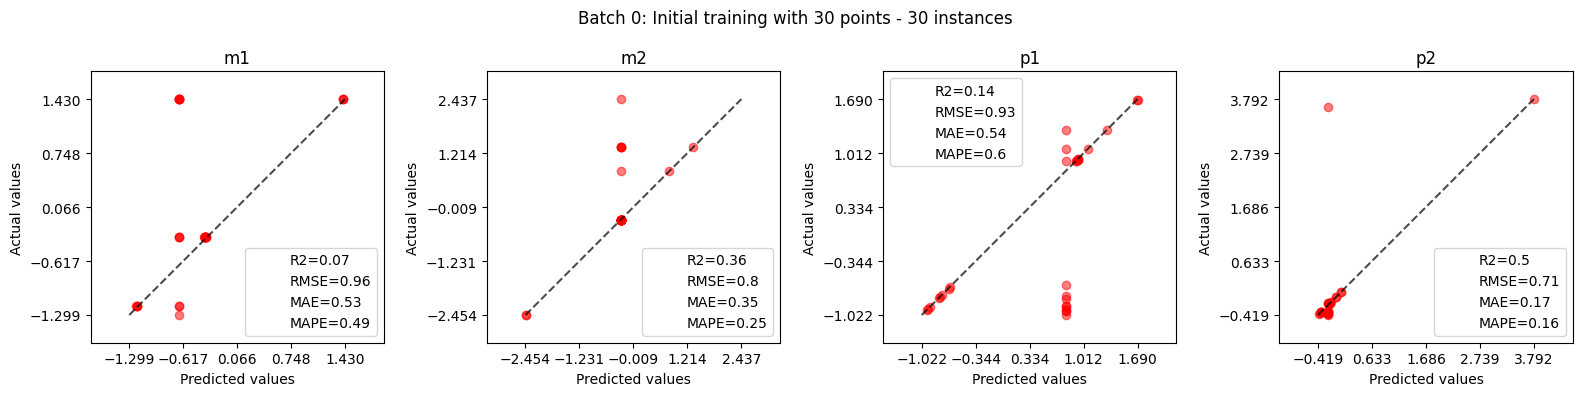


Initial metrics:
R2= 0.2666793116931297
MSE= 0.7333206883068702
RMSE= 0.856341455441035
MAE= 0.39534590811550585
MAPE= 0.37353445006852576

Batch  1 : (424, 234) (424, 4)
max 106 queries
Selecting indices at random!
0.25 106 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 133, 184, 323, 395, 264, 76, 82, 282, 340, 339, 140, 84, 5, 419, 35, 62, 304, 172, 14, 42, 387, 104, 195, 206, 298, 224, 311, 48, 328, 351, 57, 296, 301, 326, 324, 186, 92, 370, 249, 263, 344, 99, 416, 231, 319, 111, 248, 144, 256, 414, 52, 382, 45, 142, 143, 402, 379, 391, 210, 58, 418, 300, 47, 217, 245, 86, 273, 197, 233, 158, 368, 235, 223, 213, 381, 360, 131, 242, 404, 120]
Batch 1: Adjusted after 106 queries - 424 instances



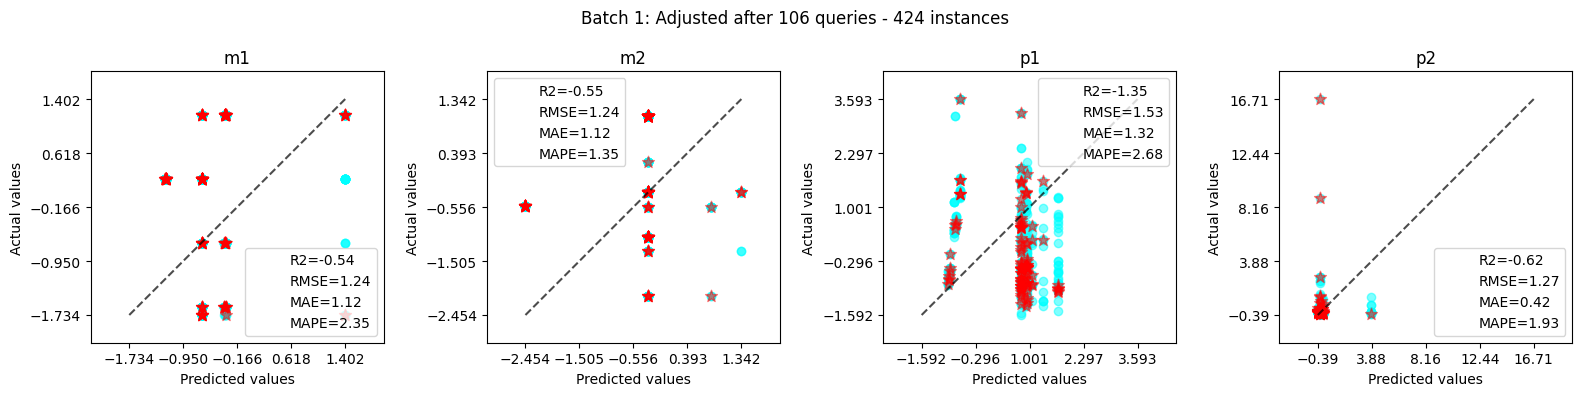

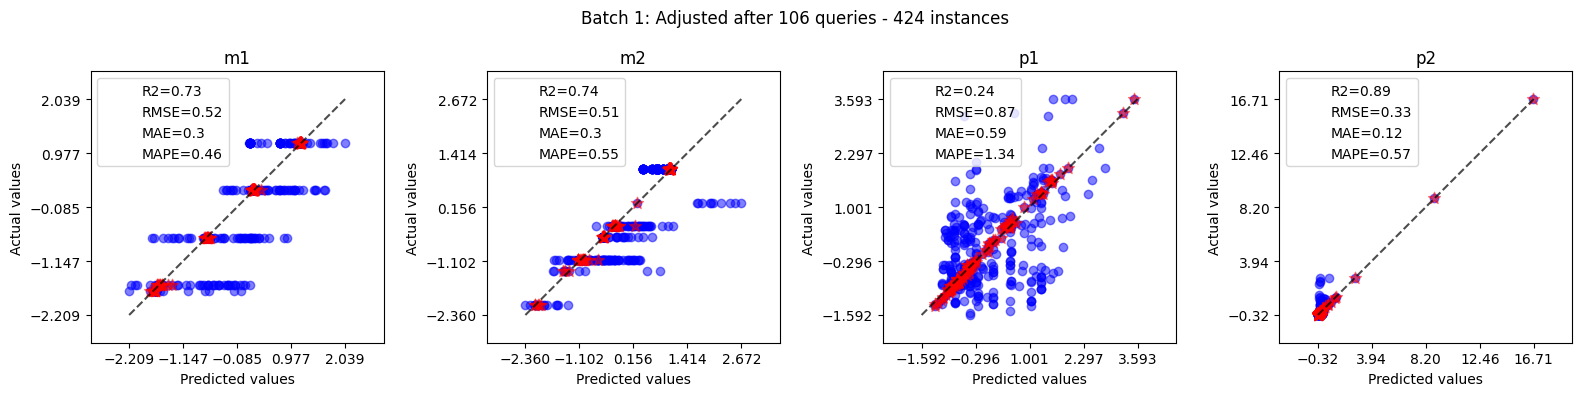


Adjusted metrics:
R2= 0.649158040178883
MSE= 0.35084195982111704
RMSE= 0.5923191368013675
MAE= 0.3284834902393638
MAPE= 0.727402375153161

Elapsed time: 2.8532280831132084 seconds

oracle evaluation: 136 (out of 454 points)
--> m1
R2= 0.6818008992316809
MSE= 0.31819910076831925
RMSE= 0.5640913939853357
MAE= 0.31643412837762597
MAPE= 0.4627824210991465
--> m2
R2= 0.7167028659090742
MSE= 0.283297134090926
RMSE= 0.5322566430688546
MAE= 0.3062581675822965
MAPE= 0.5259573085703674
--> p1
R2= 0.2309146918623317
MSE= 0.7690853081376681
RMSE= 0.8769750898045326
MAE= 0.5857241504451008
MAPE= 1.287939734766936
--> p2
R2= 0.8661180045532151
MSE= 0.13388199544678483
RMSE= 0.3658988869165699
MAE= 0.12319040033467207
MAPE= 0.5393966639071287



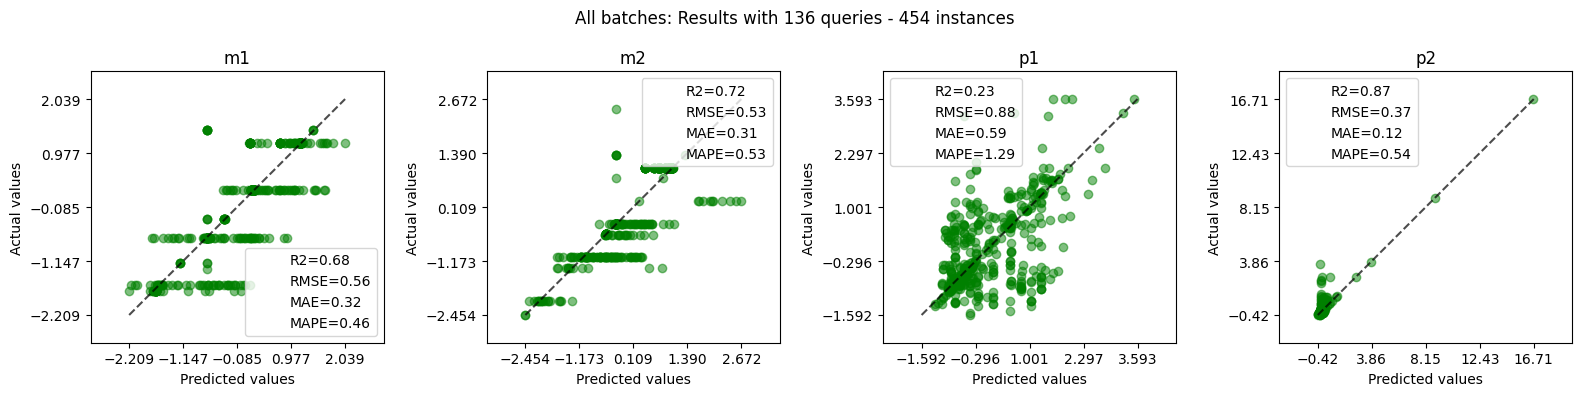

R2= 0.623884115389076
MSE= 0.3761158846109245
RMSE= 0.6132828748717222
MAE= 0.3329017116849239
MAPE= 0.7040190320858946



exp  size  features  queries      time        R2  \
0  incremental - batch 0    30       234       30  0.660658  0.266679   
1  incremental - batch 1   424       234      106  1.258765  0.649158   
2      incremental - all   454       234      136  2.853228  0.623884   

        MSE      RMSE       MAE      MAPE  
0  0.733321  0.856341  0.395346  0.373534  
1  0.350842  0.592319  0.328483  0.727402  
2  0.376116  0.613283  0.332902  0.704019

In [16]:
print ("STPLUS - tactics only")
target = OBJ_STPLUS
X, y, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=False, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

# Number of queries (SF) needs to be set
metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(1,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

STPLUS -  embeddings only
levels 2 2
(30, 500) (30, 4)
standard scaling y ... 2
max 0.25 percentage - queries
Batch 0: (30, 500) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 



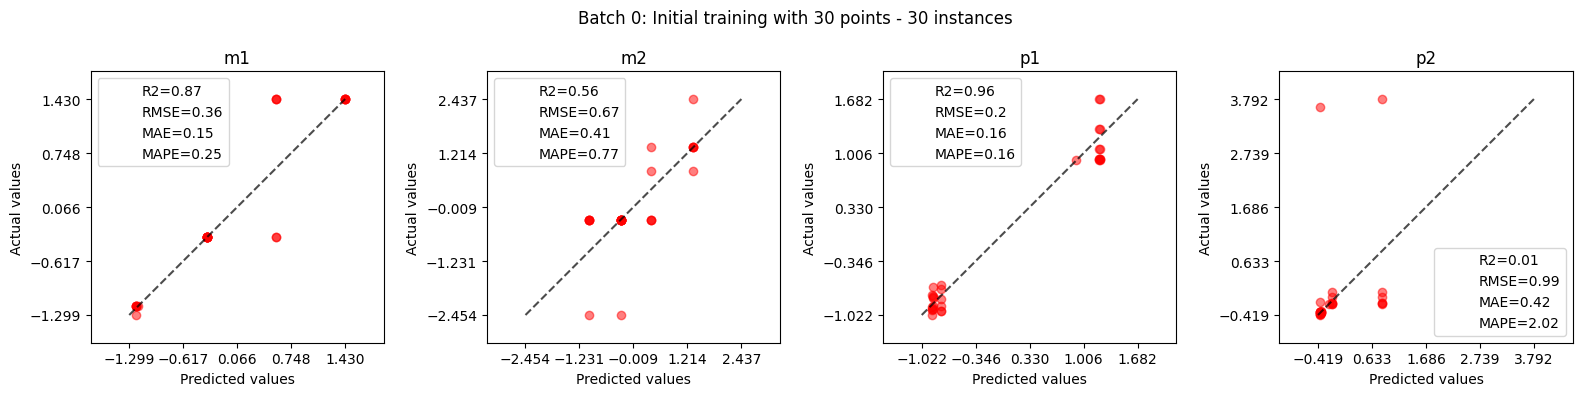


Initial metrics:
R2= 0.6005239506537563
MSE= 0.39947604934624364
RMSE= 0.6320411769388475
MAE= 0.2857729795337965
MAPE= 0.7998570191077092

Batch  1 : (424, 500) (424, 4)
max 106 queries
Selecting indices at random!
0.25 106 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 133, 184, 323, 395, 264, 76, 82, 282, 340, 339, 140, 84, 5, 419, 35, 62, 304, 172, 14, 42, 387, 104, 195, 206, 298, 224, 311, 48, 328, 351, 57, 296, 301, 326, 324, 186, 92, 370, 249, 263, 344, 99, 416, 231, 319, 111, 248, 144, 256, 414, 52, 382, 45, 142, 143, 402, 379, 391, 210, 58, 418, 300, 47, 217, 245, 86, 273, 197, 233, 158, 368, 235, 223, 213, 381, 360, 131, 242, 404, 120]
Batch 1: Adjusted after 106 queries - 424 instances



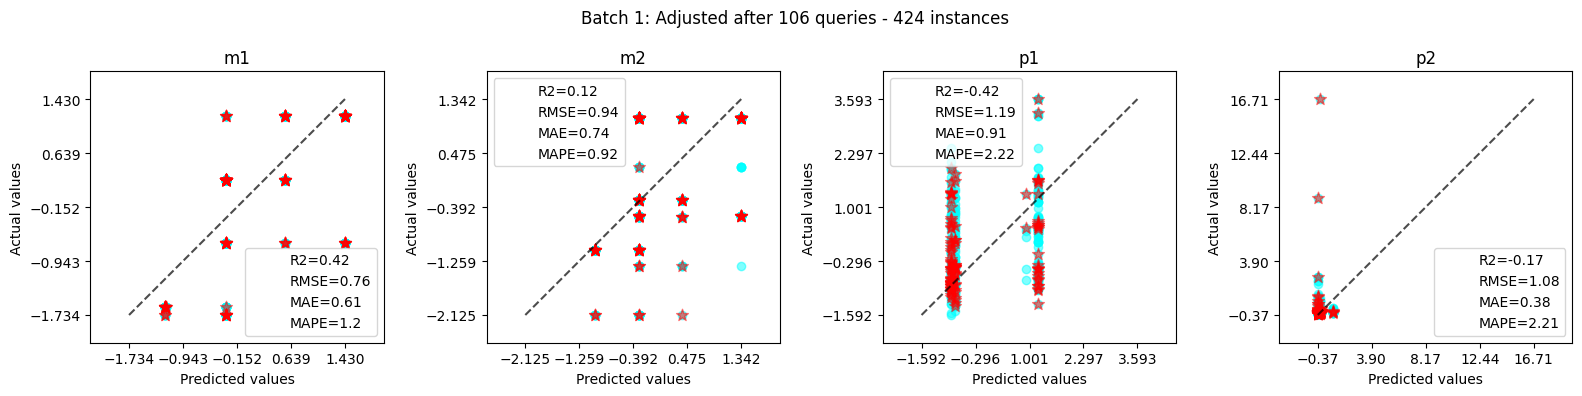

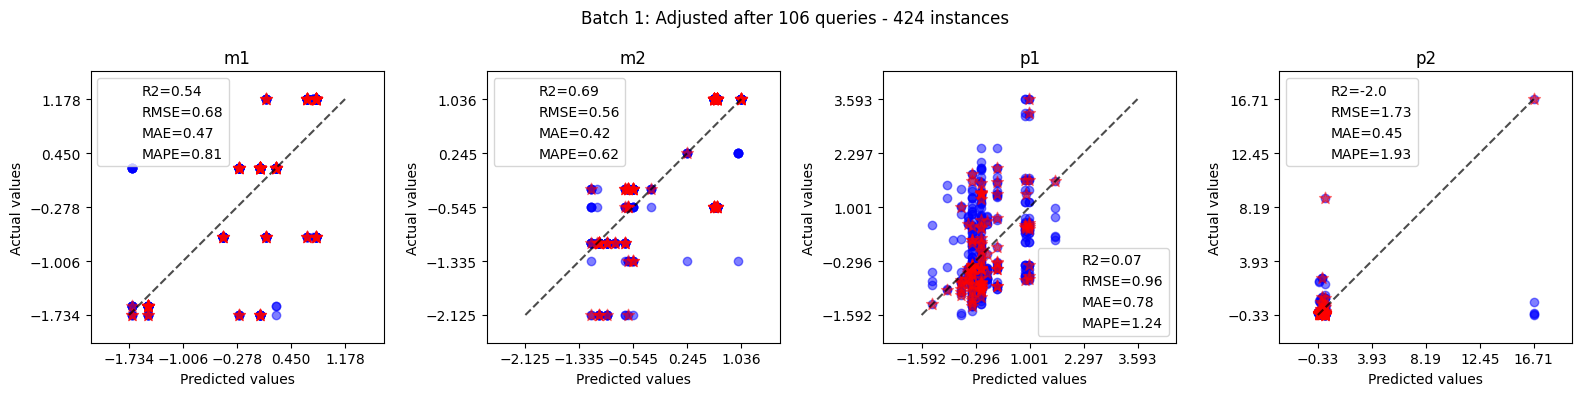


Adjusted metrics:
R2= -0.17566379837284413
MSE= 1.175663798372844
RMSE= 1.084280313559572
MAE= 0.5305500584344133
MAPE= 1.1486726630451667

Elapsed time: 1.9620907921344042 seconds

oracle evaluation: 136 (out of 454 points)
--> m1
R2= 0.5621505050093658
MSE= 0.4378494949906343
RMSE= 0.6617019684046846
MAE= 0.45074839245151416
MAPE= 0.7720270727599855
--> m2
R2= 0.6806998539288176
MSE= 0.3193001460711825
RMSE= 0.5650664970348025
MAE= 0.41695647084264054
MAPE= 0.6263764146754202
--> p1
R2= 0.12861807660245994
MSE= 0.8713819233975398
RMSE= 0.9334784000701568
MAE= 0.741212042134618
MAPE= 1.1675910555345015
--> p2
R2= -1.8689638715800565
MSE= 2.8689638715800556
RMSE= 1.6938016033703758
MAE= 0.4485845409342686
MAPE= 1.9364981416501947



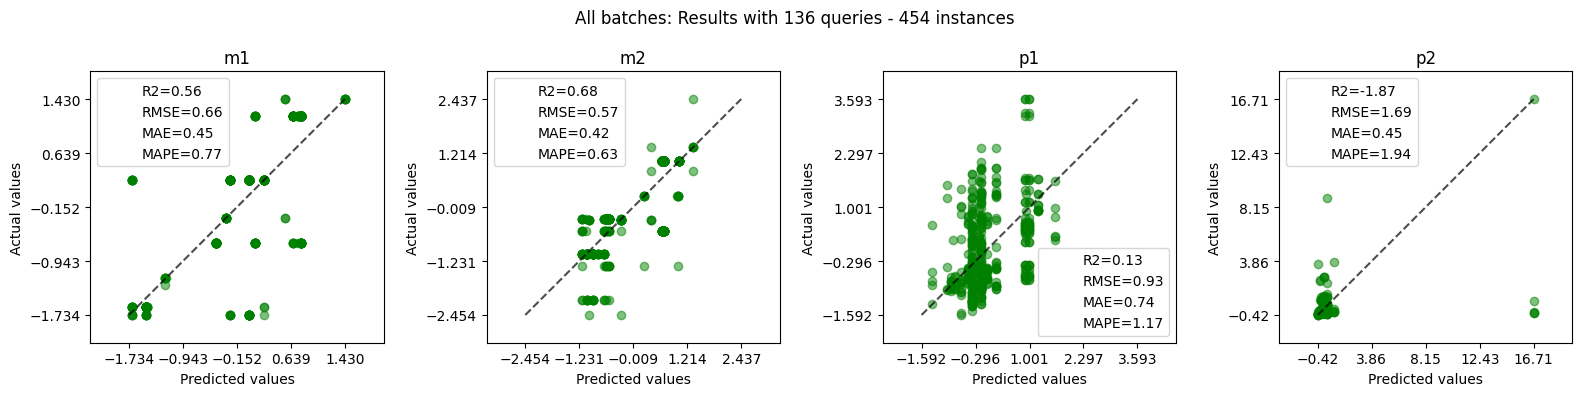

R2= -0.12437385900985198
MSE= 1.1243738590098526
RMSE= 1.0603649650049047
MAE= 0.5143753615907602
MAPE= 1.1256231711550266



exp  size  features  queries      time        R2  \
0  incremental - batch 0    30       500       30  0.047140  0.600524   
1  incremental - batch 1   424       500      106  0.991260 -0.175664   
2      incremental - all   454       500      136  1.962091 -0.124374   

        MSE      RMSE       MAE      MAPE  
0  0.399476  0.632041  0.285773  0.799857  
1  1.175664  1.084280  0.530550  1.148673  
2  1.124374  1.060365  0.514375  1.125623

In [17]:
print ("STPLUS -  embeddings only")
target = OBJ_STPLUS
X, y, _ = get_regression_data(df_stplus, target=target, tactics=False, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(1,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

STPLUS - tactics & embeddings
levels 2 2
(30, 734) (30, 4)
standard scaling y ... 2
max 0.5 percentage - queries
Batch 0: (30, 734) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 



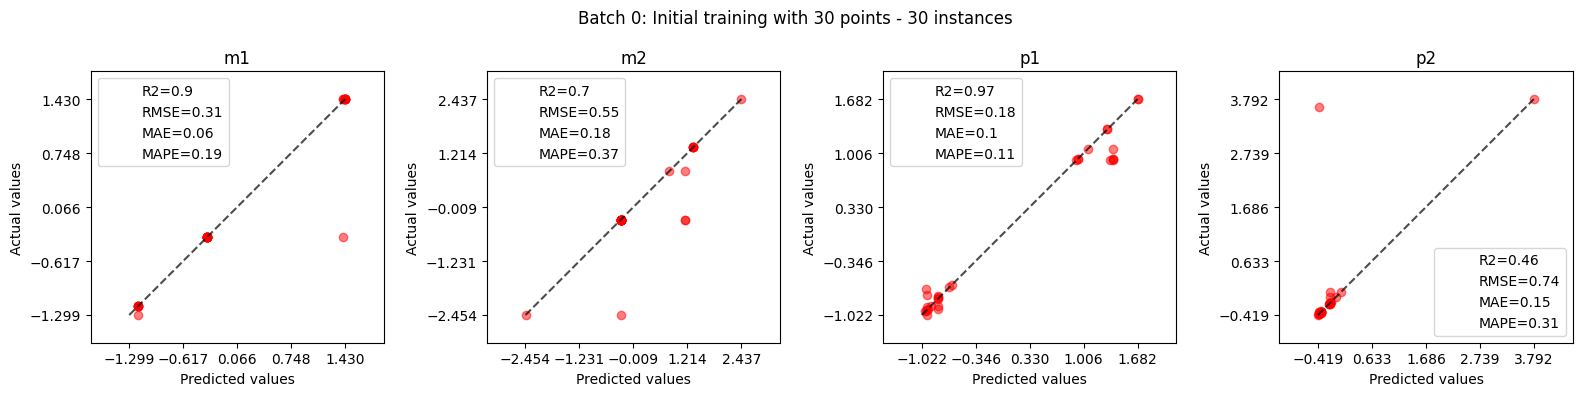


Initial metrics:
R2= 0.7569191380336959
MSE= 0.24308086196630407
RMSE= 0.4930323133084728
MAE= 0.12299861453518635
MAPE= 0.24570854832154182

Batch  1 : (424, 734) (424, 4)
max 212 queries
Selecting indices at random!
0.5 212 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 133, 184, 323, 395, 264, 76, 82, 282, 340, 339, 140, 84, 5, 419, 35, 62, 304, 172, 14, 42, 387, 104, 195, 206, 298, 224, 311, 48, 328, 351, 57, 296, 301, 326, 324, 186, 92, 370, 249, 263, 344, 99, 416, 231, 319, 111, 248, 144, 256, 414, 52, 382, 45, 142, 143, 402, 379, 391, 210, 58, 418, 300, 47, 217, 245, 86, 273, 197, 233, 158, 368, 235, 223, 213, 381, 360, 131, 242, 404, 120, 409, 422, 250, 34, 291, 73, 316, 136, 292, 225, 9, 207, 216, 10, 177, 313, 188, 241, 401, 182, 154, 271, 96, 21, 286, 240, 321, 322, 198, 50, 17, 98, 159, 12, 0, 259, 406, 267, 403, 128, 338, 287, 74, 101, 283, 117, 278, 349, 135, 93, 127, 106, 169, 413,

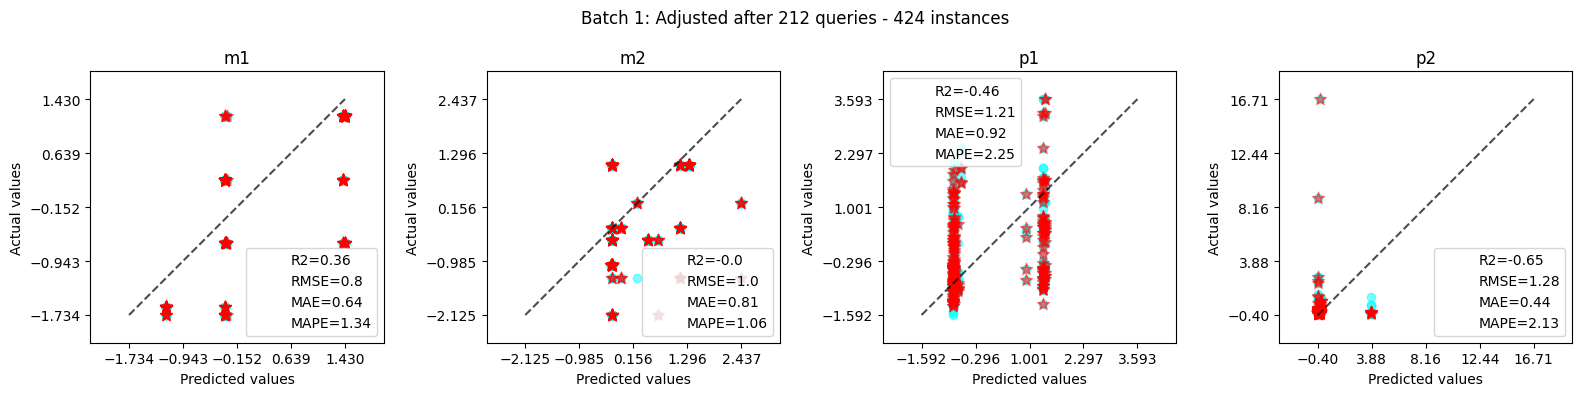

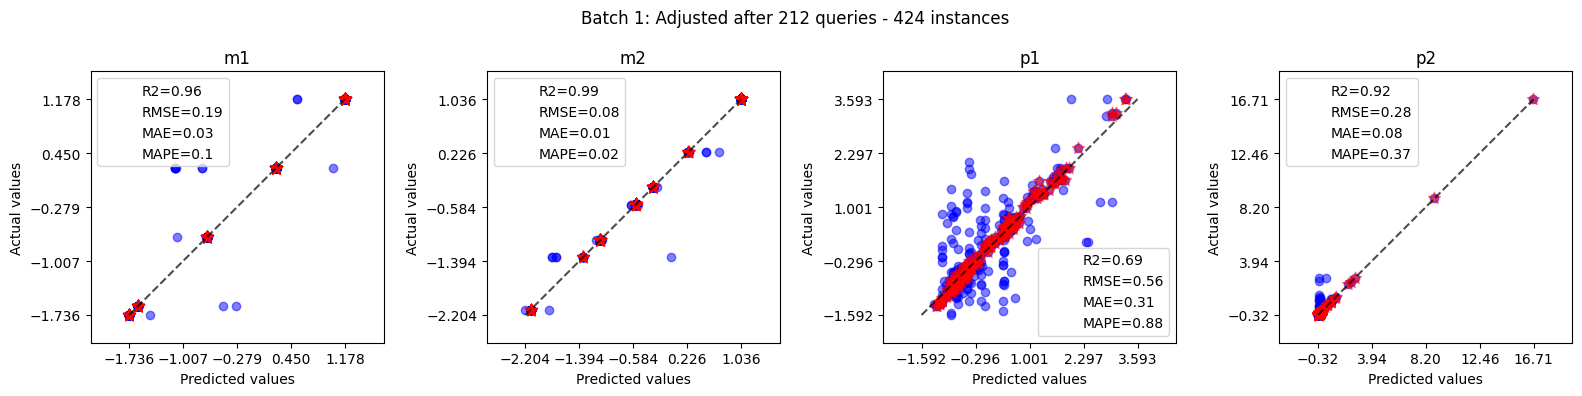


Adjusted metrics:
R2= 0.8915137010408234
MSE= 0.10848629895917657
RMSE= 0.3293725838001344
MAE= 0.10786941954992321
MAPE= 0.34061845798234425

Elapsed time: 3.354468666948378 seconds

oracle evaluation: 242 (out of 454 points)
--> m1
R2= 0.9581817510311219
MSE= 0.04181824896887805
RMSE= 0.2044951074448434
MAE= 0.03561397357036436
MAPE= 0.10632595103411101
--> m2
R2= 0.9737162148812151
MSE= 0.026283785118784982
RMSE= 0.16212274707389146
MAE= 0.0226565444988277
MAPE= 0.04090105200216933
--> p1
R2= 0.707151281322423
MSE= 0.29284871867757695
RMSE= 0.5411549858197529
MAE= 0.2924202990069605
MAPE= 0.8248974469362218
--> p2
R2= 0.8914299015081475
MSE= 0.10857009849185245
RMSE= 0.32949977009377784
MAE= 0.0847857672870459
MAPE= 0.36526306222274174



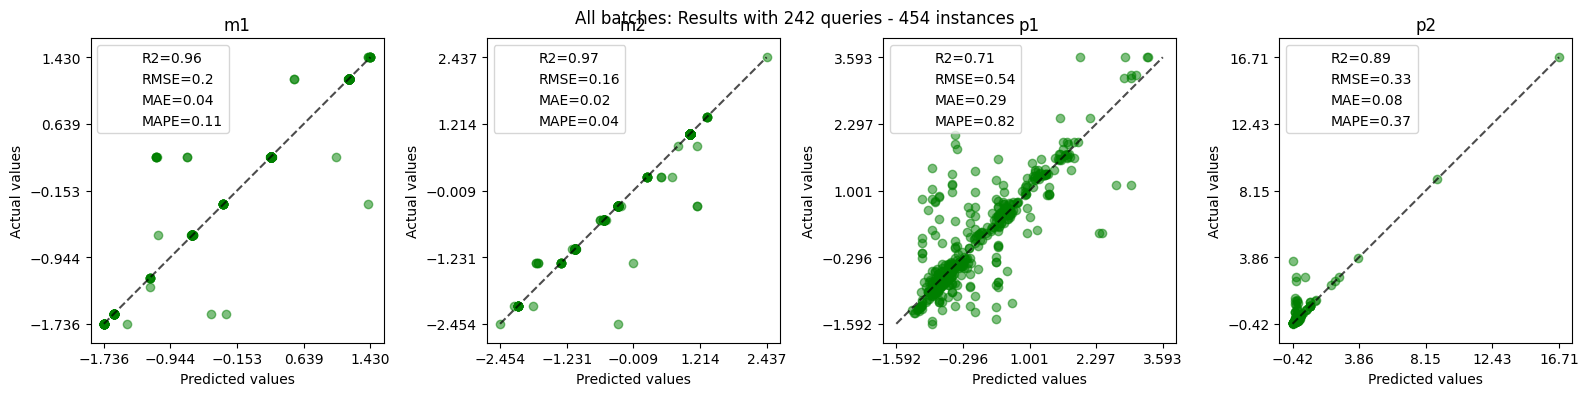

R2= 0.8826197871857269
MSE= 0.11738021281427315
RMSE= 0.34260795789688414
MAE= 0.1088691460907996
MAPE= 0.33434687804881097



exp  size  features  queries      time        R2  \
0  incremental - batch 0    30       734       30  0.126285  0.756919   
1  incremental - batch 1   424       734      212  2.369269  0.891514   
2      incremental - all   454       734      242  3.354469  0.882620   

        MSE      RMSE       MAE      MAPE  
0  0.243081  0.493032  0.122999  0.245709  
1  0.108486  0.329373  0.107869  0.340618  
2  0.117380  0.342608  0.108869  0.334347

In [18]:
print ("STPLUS - tactics & embeddings")
target = OBJ_STPLUS
X, y, fnames = get_regression_data(df_stplus, target=target, tactics=True, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred_ial_stplus = run_active_learning_batches(X, y, regressor, n_queries=0.5, calibration=True, show_plots=(1,4),
                                      target=target, verbose=False, show_errors=False, filename='stplus-incremental-all.pdf')

print()
pd.DataFrame(metrics)

Target: m1


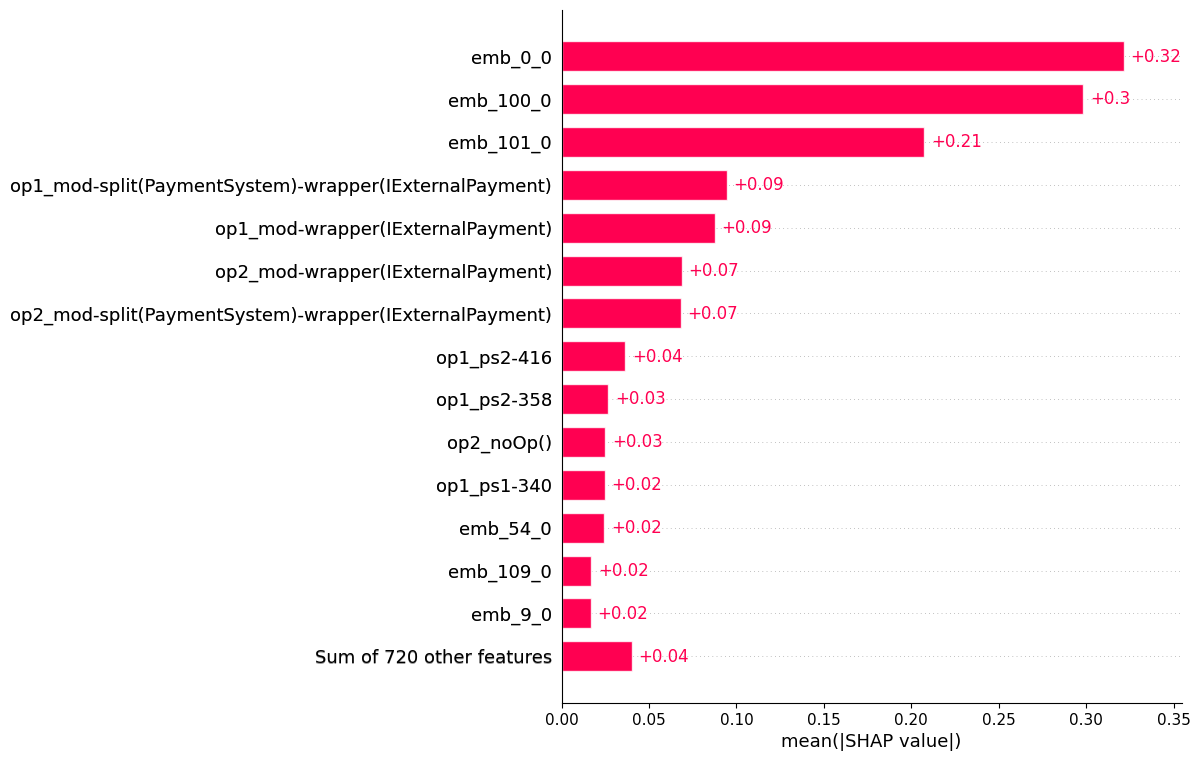

Target: m2


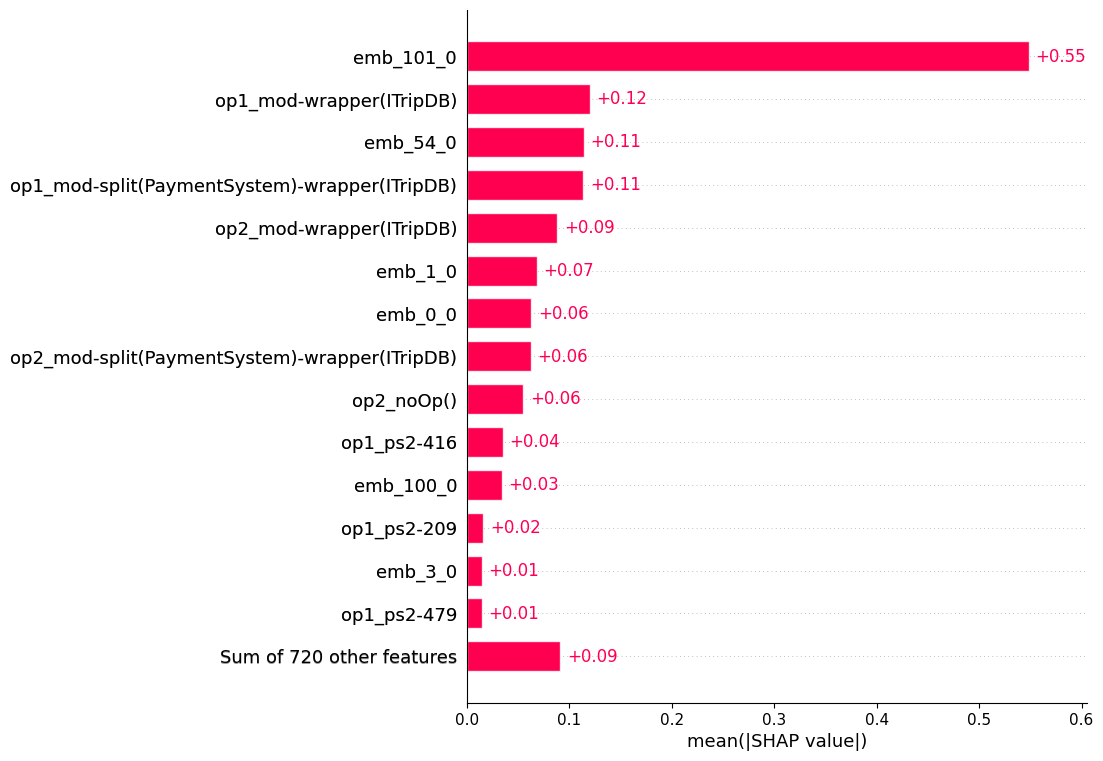

Target: p1


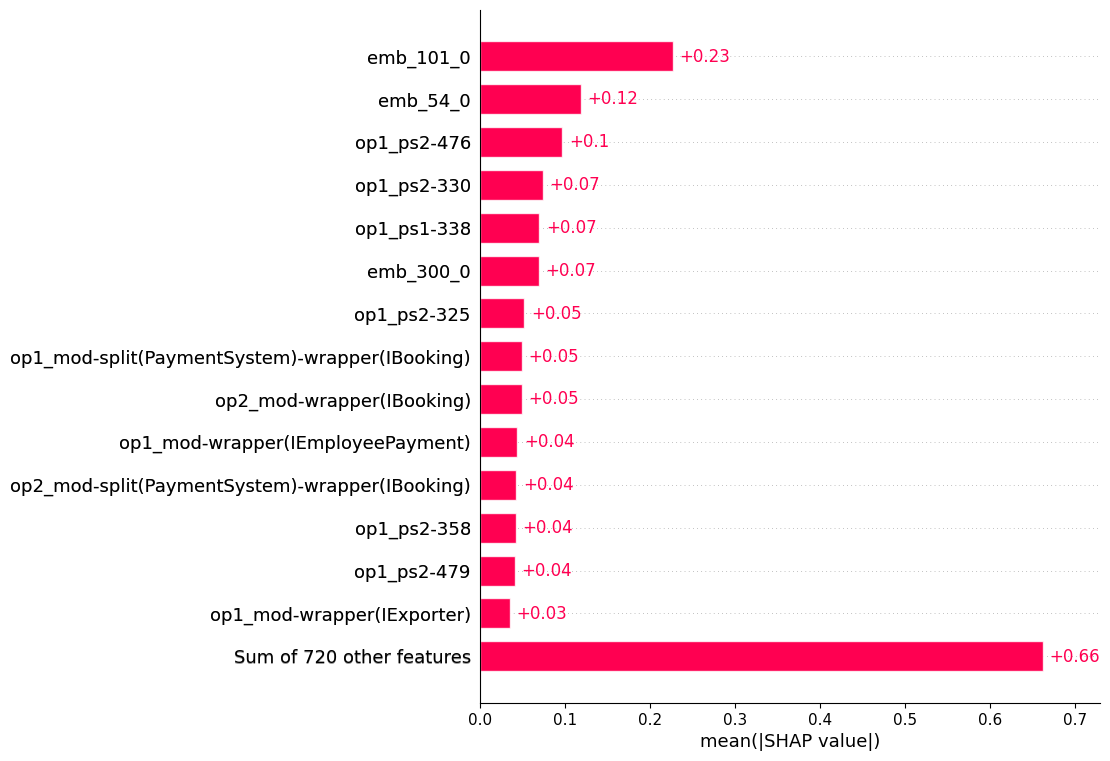

Target: p2


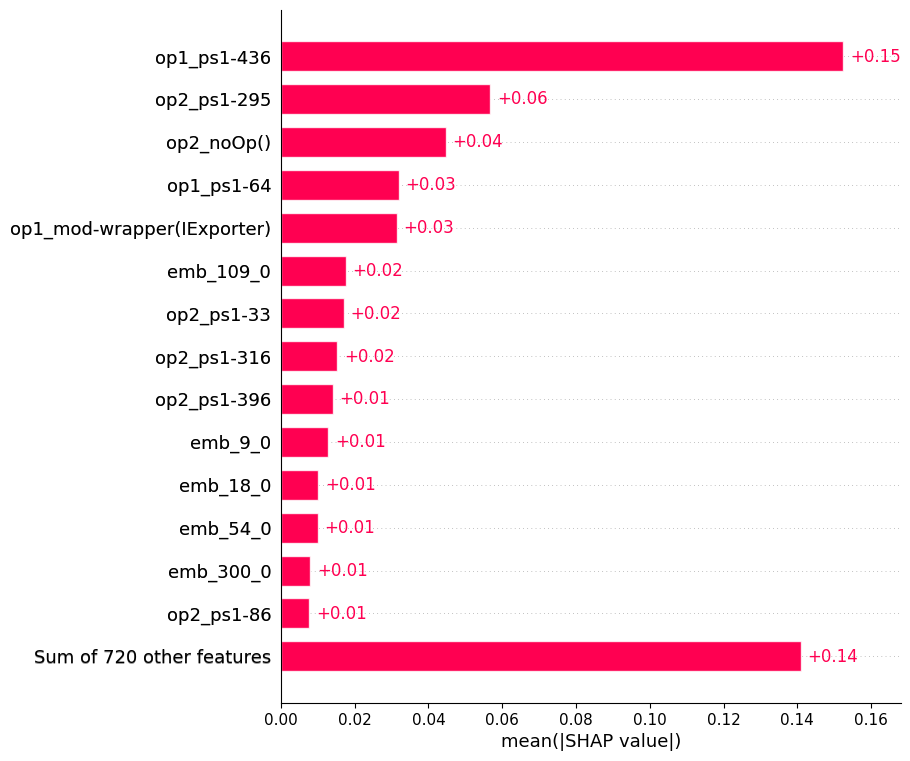

In [19]:
Z = np.concatenate(X, axis=0)
show_shap_plots(Z, fnames, regressor, OBJ_STPLUS)

#### Experiments with different values of the SF parameter (n_queries)

In [20]:
print ("STPLUS - tactics & embeddings")
print()
target = OBJ_STPLUS

# This code snippet is designed to experiment with different values of the sampling
# fraction (SF), represented by the n_queries variable, in an active learning scenario
# for regression tasks. It focuses on the ST+ dataset and evaluates the performance
# of a machine learning model with varying sampling fractions.

df_list = []
preds_by_sf_stplus = dict()
for n in range(1,6): # Variation of the SF parameter
  print()
  print("-"*50)
  n_queries = n * 0.1
  print("n_queries:", n_queries)

  X, y, _ = get_regression_data(df_stplus, target=target, tactics=True, embeddings=True, split_by_level=True)

  regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
  regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
  regressor = regr_xgb # regr_rf # regr_xgb

  metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=n_queries, calibration=True, show_plots=None, target=target, verbose=False)
  df_metrics = pd.DataFrame(metrics)
  df_metrics['n_queries'] = n_queries
  df_list.append(df_metrics)
  preds_by_sf_stplus[n_queries] = y_pred

print()
print("="*10, "RESULTS STPLUS:")
df_metrics_stplus = pd.concat(df_list).reset_index(drop=True)
df_metrics_stplus

STPLUS - tactics & embeddings


--------------------------------------------------
n_queries: 0.1
standard scaling y ... 2
max 0.1 percentage - queries
Batch 0: (30, 734) (30, 4)
Batch 0: Initial training with 30 points - 30 instances
Regressor score=1.00 

Initial metrics:
R2= 0.9073827667947063
MSE= 0.09261723320529372
RMSE= 0.3043307956899757
MAE= 0.08615794840966196
MAPE= 0.24634875239620063

Batch  1 : (424, 734) (424, 4)
max 42 queries
Selecting indices at random!
0.1 42 queries: [54, 315, 359, 386, 333, 269, 126, 138, 376, 130, 149, 375, 37, 337, 230, 155, 238, 350, 203, 201, 398, 60, 134, 114, 161, 183, 413, 133, 184, 411, 323, 264, 76, 82, 282, 340, 339, 140, 84, 5, 35, 62]
Batch 1: Adjusted after 42 queries - 424 instances

Adjusted metrics:
R2= 0.3920121559081519
MSE= 0.607987844091848
RMSE= 0.7797357527341221
MAE= 0.3407058911434954
MAPE= 0.8486930914332356

Elapsed time: 2.0037356670945883 seconds

oracle evaluation: 72 (out of 454 points)
R2= 0.4260674826187174
MSE= 0.573

exp  size  features  queries      time        R2  \
0   incremental - batch 0    30       734       30  0.142895  0.907383   
1   incremental - batch 1   424       734       42  1.856605  0.392012   
2       incremental - all   454       734       72  2.003736  0.426067   
3   incremental - batch 0    30       734       30  0.111531  0.628083   
4   incremental - batch 1   424       734       85  2.783464  0.631495   
5       incremental - all   454       734      115  2.897756  0.631270   
6   incremental - batch 0    30       734       30  0.122953  0.731626   
7   incremental - batch 1   424       734      127  2.442283  0.843765   
8       incremental - all   454       734      157  2.568096  0.836355   
9   incremental - batch 0    30       734       30  0.075002  0.947272   
10  incremental - batch 1   424       734      170  1.830402  0.873151   
11      incremental - all   454       734      200  1.907916  0.878049   
12  incremental - batch 0    30       734       30  0.077696  0.781785   
13  incremental - batch 1   424       734      212  1.880356  0.891514   
14      incremental - all   454       734      242  1.960625  0.884263   

         MSE      RMSE       MAE      MAPE  n_queries  
0   0.092617  0.304331  0.086158  0.246349        0.1  
1   0.607988  0.779736  0.340706  0.848693        0.1  
2   0.573933  0.757583  0.323886  0.808891        0.1  
3   0.371917  0.609850  0.149262  0.178153        0.2  
4   0.368505  0.607046  0.225716  0.656844        0.2  
5   0.368730  0.607232  0.220664  0.625212        0.2  
6   0.268374  0.518049  0.135132  0.177095        0.3  
7   0.156235  0.395266  0.142882  0.426816        0.3  
8   0.163645  0.404531  0.142370  0.410314        0.3  
9   0.052728  0.229625  0.047075  0.180533        0.4  
10  0.126849  0.356159  0.119502  0.376234        0.4  
11  0.121951  0.349215  0.114716  0.363302        0.4  
12  0.218215  0.467135  0.116568  0.208628        0.5  
13  0.108486  0.329373  0.107869  0.340618        0.5  
14  0.115737  0.340202  0.108444  0.331897        0.5

In [21]:
# Summary of final results
df_metrics_stplus[df_metrics_stplus['exp']=='incremental - all']

exp  size  features  queries      time        R2       MSE  \
2   incremental - all   454       734       72  2.003736  0.426067  0.573933   
5   incremental - all   454       734      115  2.897756  0.631270  0.368730   
8   incremental - all   454       734      157  2.568096  0.836355  0.163645   
11  incremental - all   454       734      200  1.907916  0.878049  0.121951   
14  incremental - all   454       734      242  1.960625  0.884263  0.115737   

        RMSE       MAE      MAPE  n_queries  
2   0.757583  0.323886  0.808891        0.1  
5   0.607232  0.220664  0.625212        0.2  
8   0.404531  0.142370  0.410314        0.3  
11  0.349215  0.114716  0.363302        0.4  
14  0.340202  0.108444  0.331897        0.5

### **COCOME results**
Test the 3 available configurations for the encodings, using the IAL approach

COCOME - tactics only
levels 5 5
(125, 419) (125, 8)
standard scaling y ... 5
max 0.25 percentage - queries
Batch 0: (125, 419) (125, 8)
Batch 0: Initial training with 125 points - 125 instances
Regressor score=1.00 



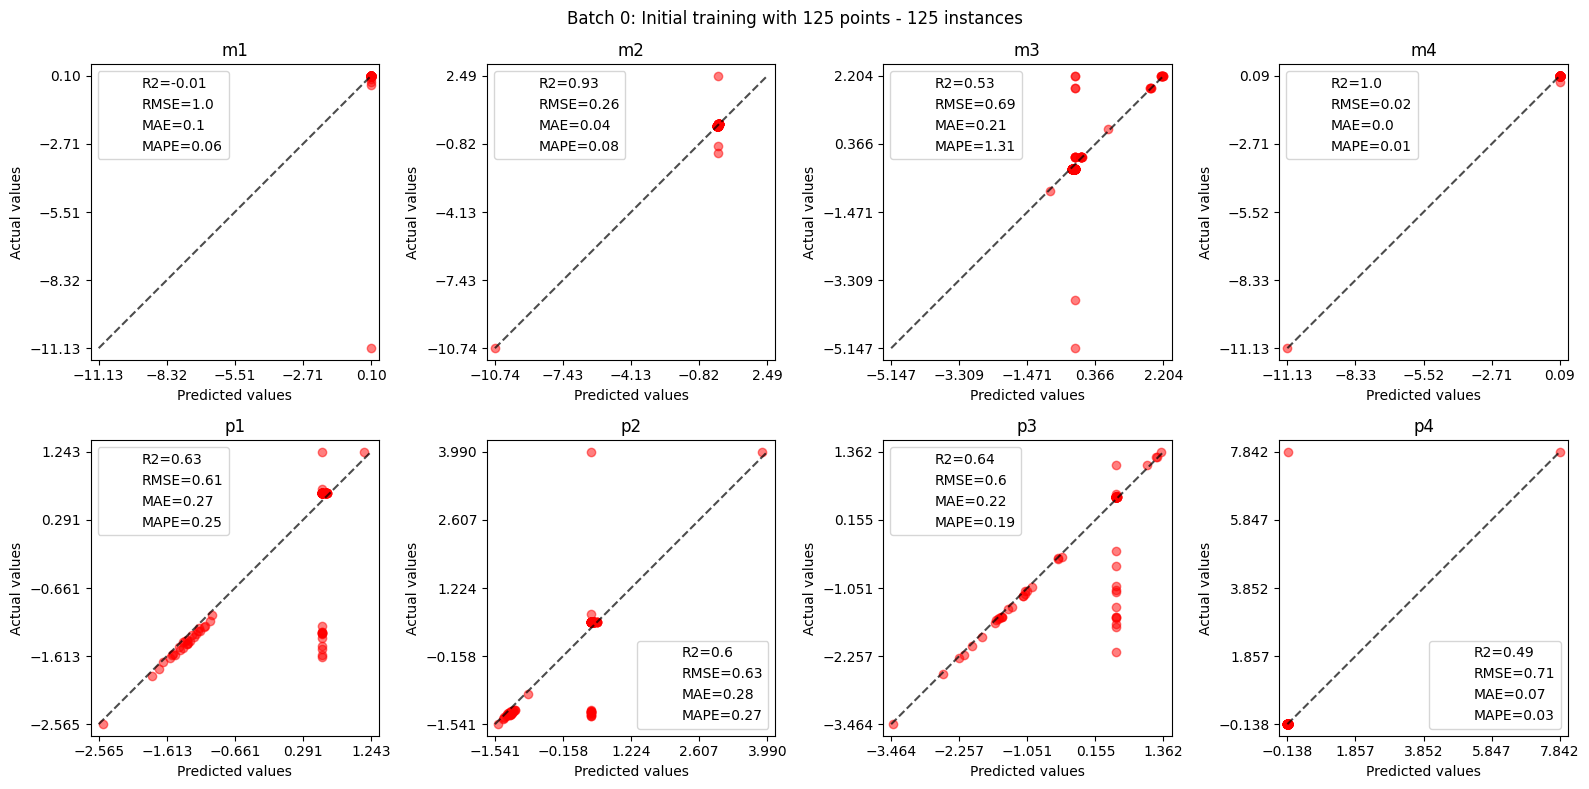


Initial metrics:
R2= 0.6023822495526557
MSE= 0.3976177504473442
RMSE= 0.6305693859103407
MAE= 0.14800975693151558
MAPE= 0.27577176894118516

Batch  1 : (344, 419) (344, 8)
max 86 queries
Selecting indices at random!
0.25 86 queries: [54, 315, 333, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 304, 172, 14, 42, 318, 104, 195, 206, 298, 224, 48, 57, 296, 186, 92, 303, 249, 263, 99, 338, 231, 111, 248, 144, 256, 337, 52, 314, 45, 142, 143, 329, 311, 320, 210, 58, 340, 47, 217, 245, 86, 197, 233, 158, 291, 235, 223, 213, 305, 131, 242, 330, 120, 334, 250, 34]
Batch 1: Adjusted after 86 queries - 344 instances



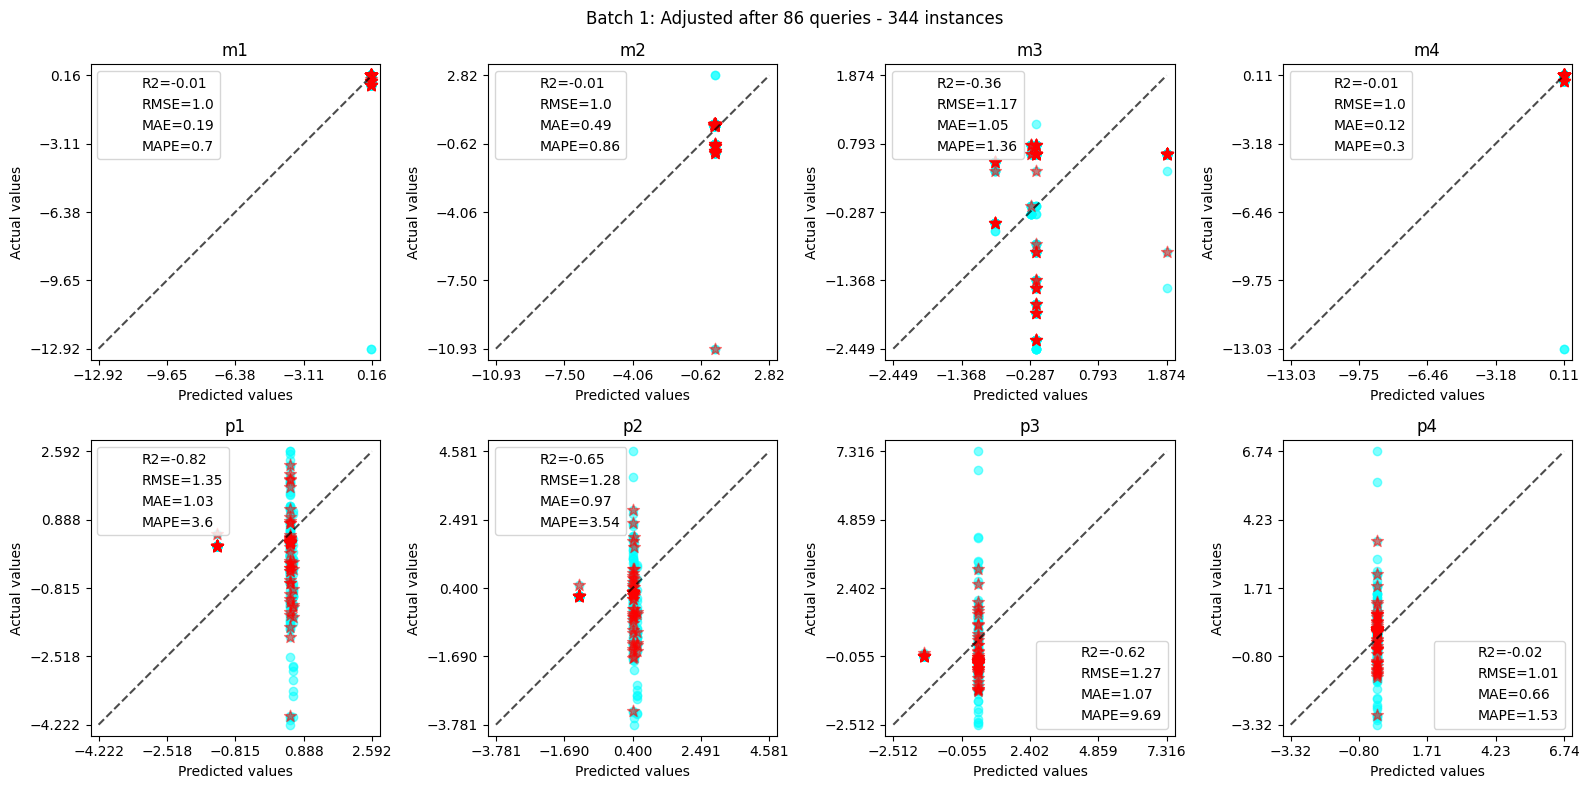

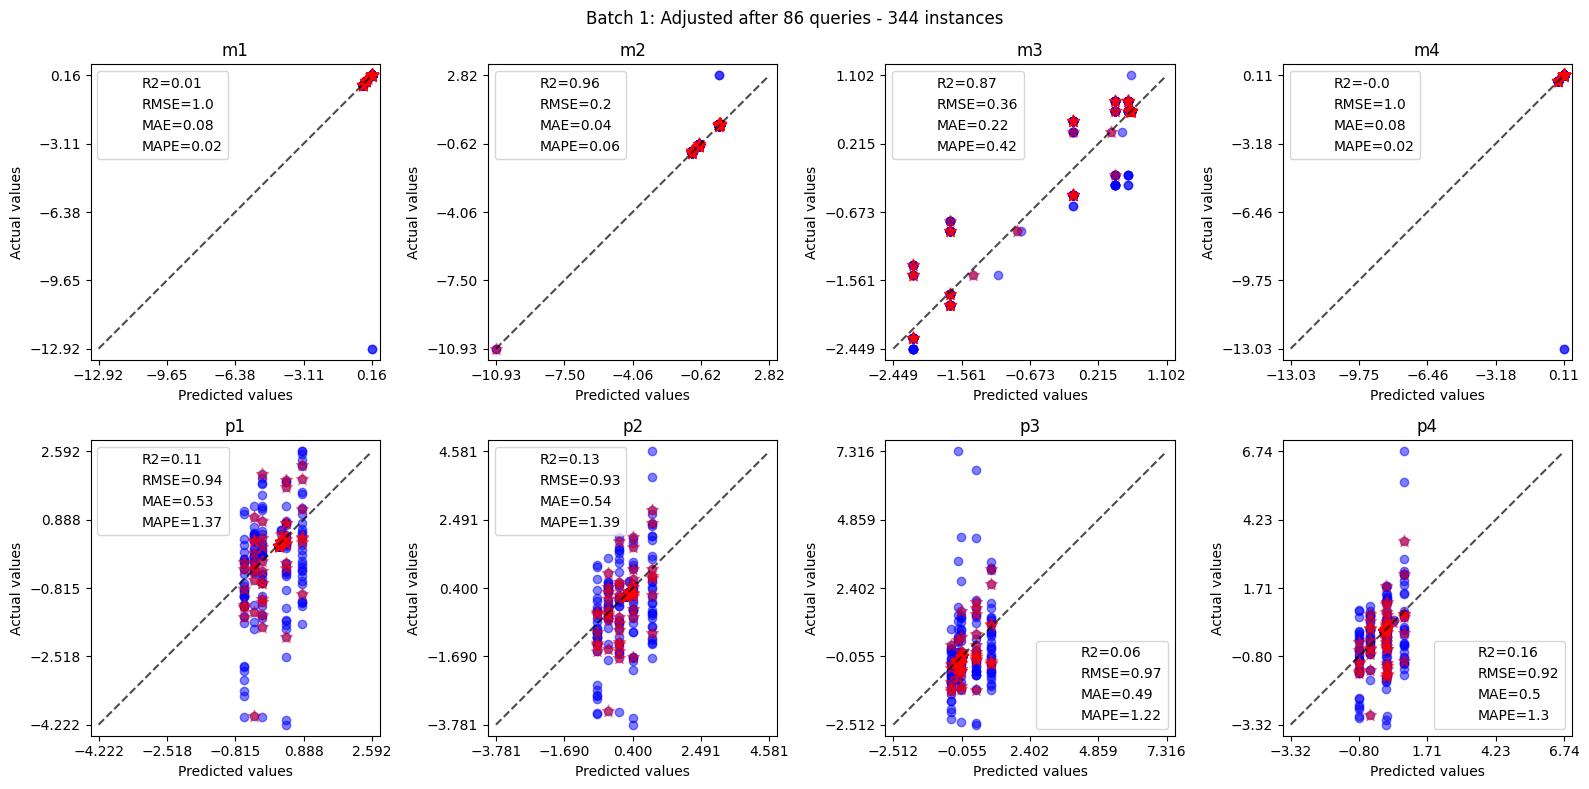


Adjusted metrics:
R2= 0.2858577404161813
MSE= 0.7141422595838187
RMSE= 0.8450693815207239
MAE= 0.3093326026804679
MAPE= 0.7256478428275042

Batch  2 : (301, 419) (301, 8)
max 75 queries
Selecting indices at random!
0.25 75 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 172, 14, 42, 104, 195, 206, 298, 224, 48, 57, 296, 186, 92, 249, 263, 99, 231, 111, 248, 144, 256, 52, 45, 142, 143, 210, 58, 300, 47, 217, 245, 86, 273, 197, 233, 158, 235, 223, 213, 131, 242, 120, 250, 34, 291, 73, 136]
Batch 2: Adjusted after 75 queries - 301 instances



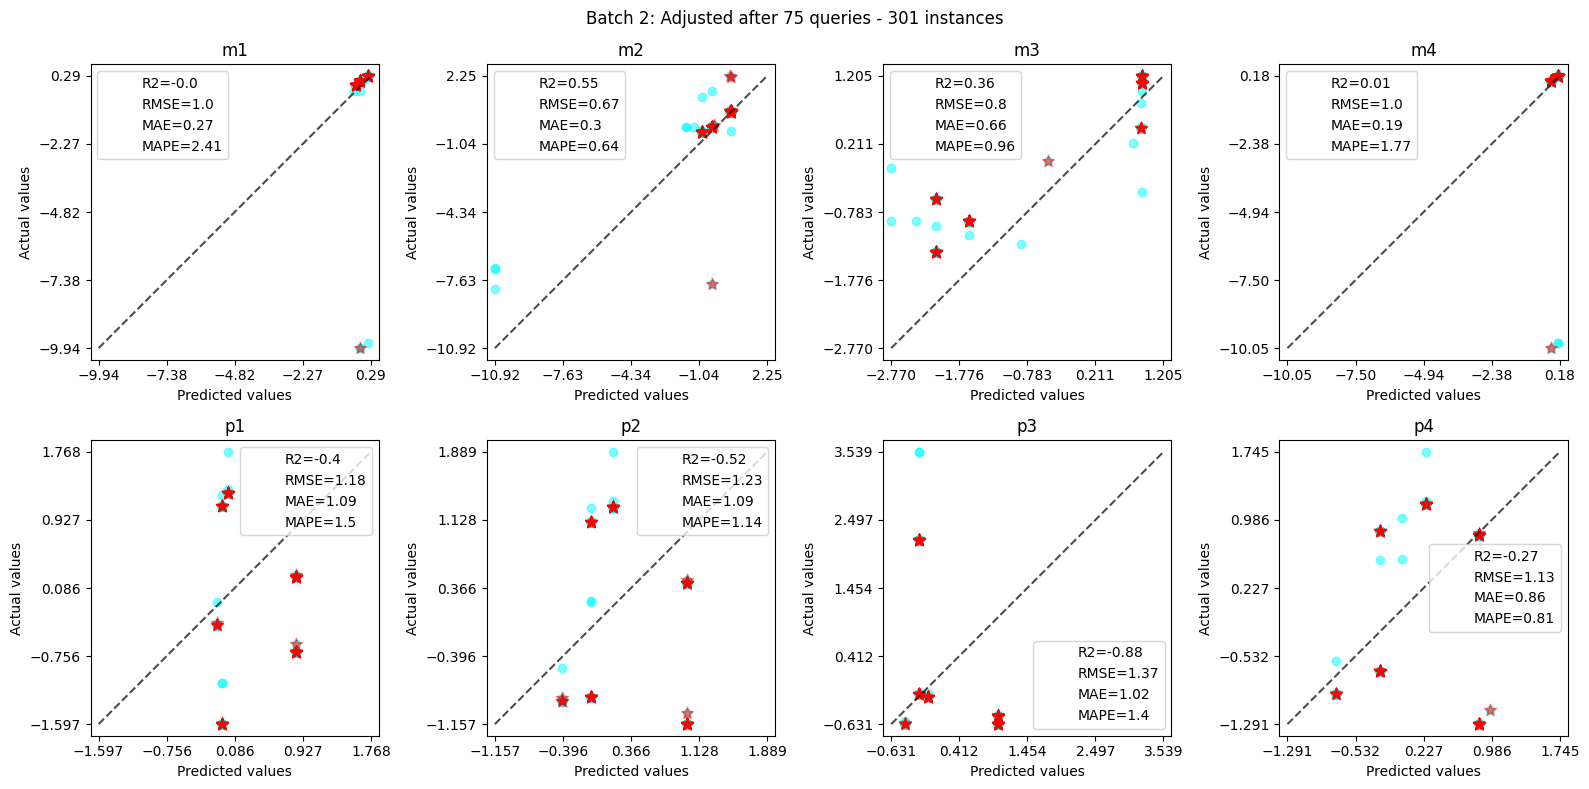

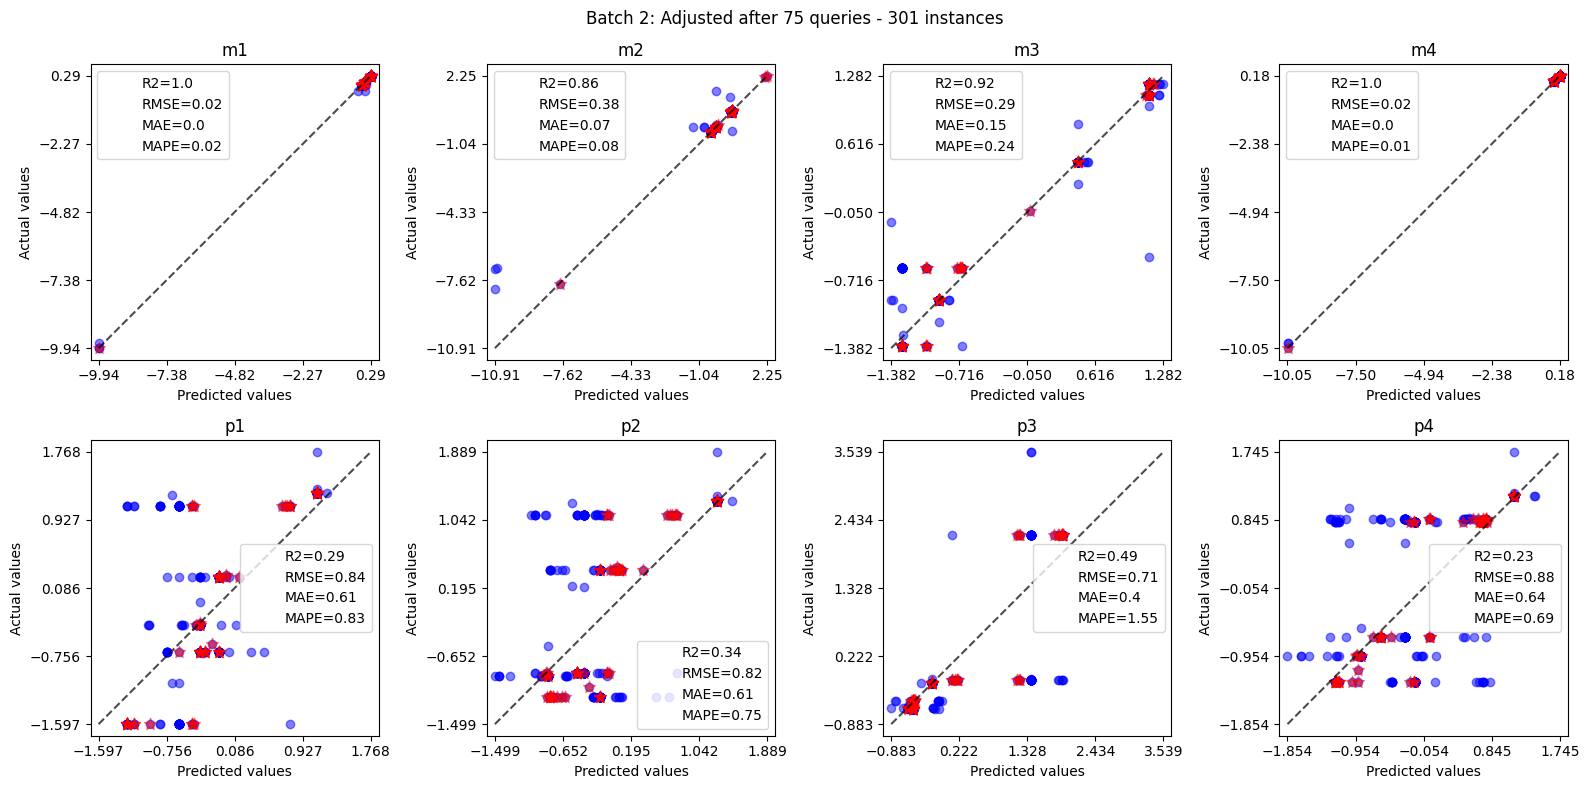


Adjusted metrics:
R2= 0.640325103378754
MSE= 0.3596748966212459
RMSE= 0.5997290193256
MAE= 0.3102563515523315
MAPE= 0.5216668264657476

Batch  3 : (120, 419) (120, 8)
max 30 queries
Selecting indices at random!
0.25 30 queries: [13, 78, 89, 96, 83, 67, 31, 34, 94, 32, 37, 93, 9, 84, 57, 38, 59, 87, 50, 101, 99, 15, 33, 28, 40, 45, 97, 46, 80, 91]
Batch 3: Adjusted after 30 queries - 120 instances



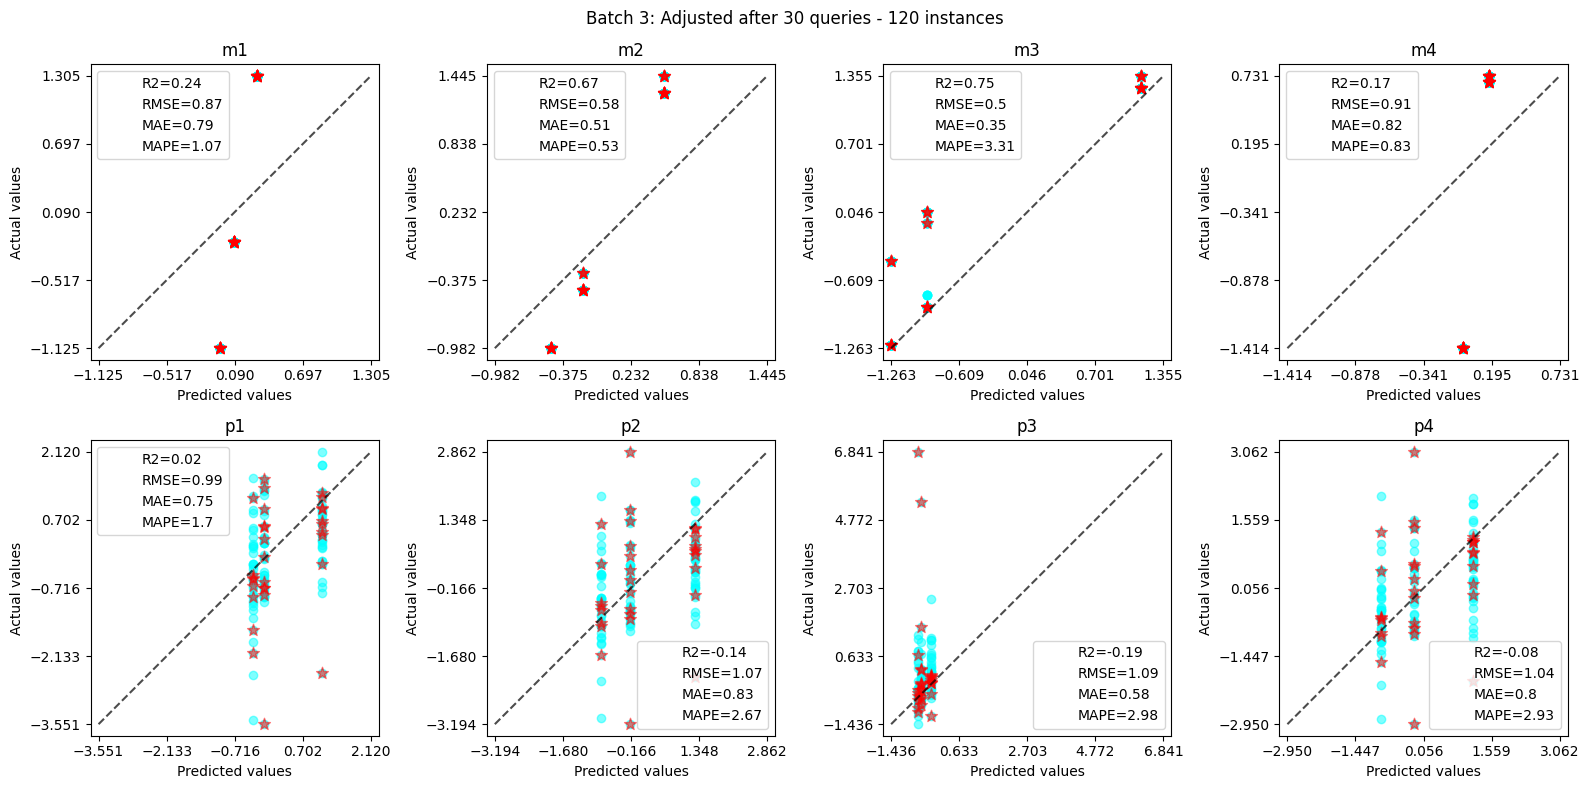

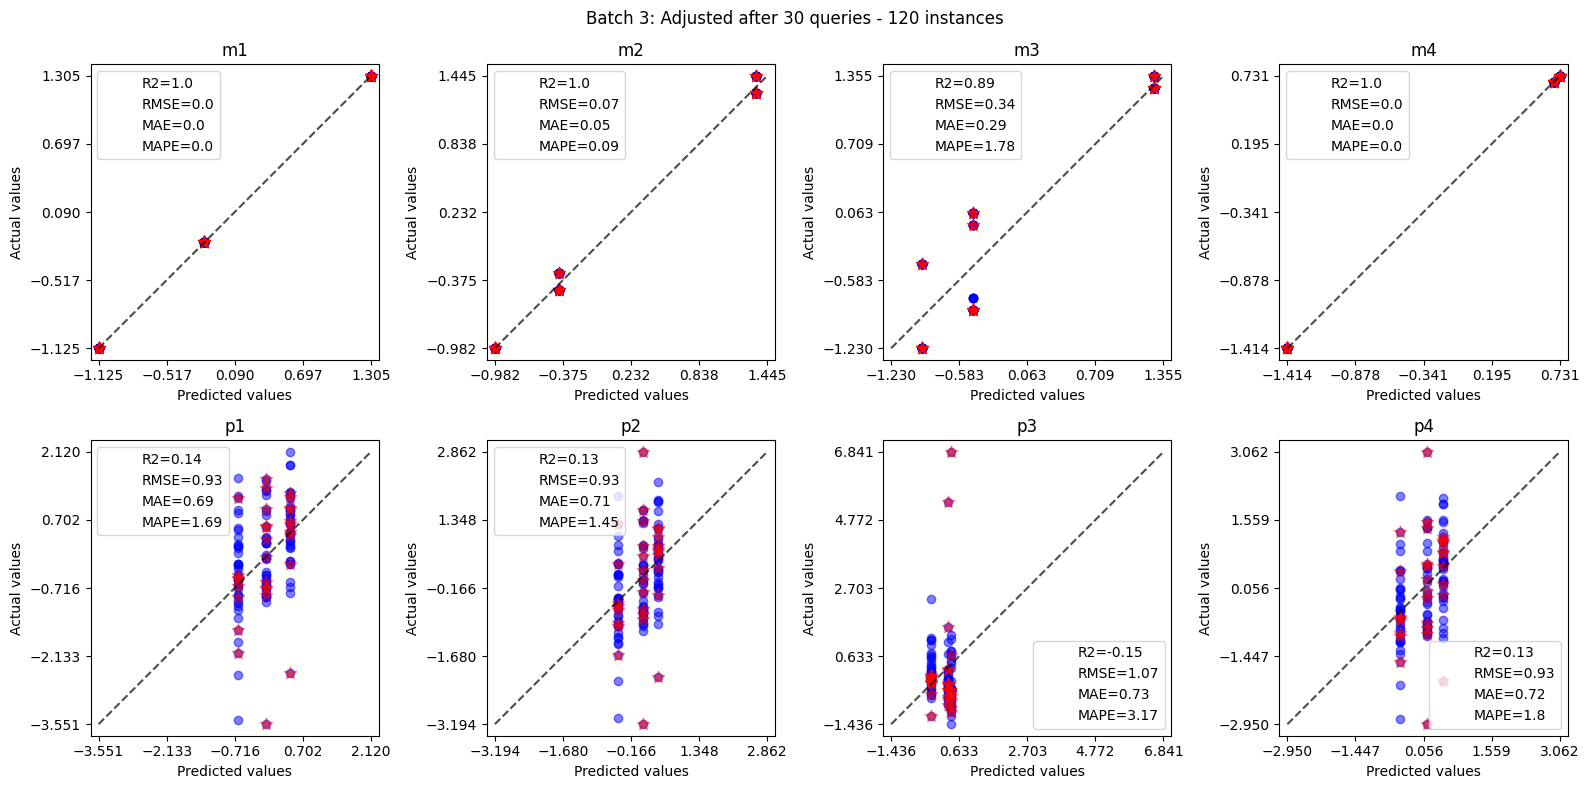


Adjusted metrics:
R2= 0.5167647100245566
MSE= 0.48323528997544335
RMSE= 0.6951512712895254
MAE= 0.3976574771000251
MAPE= 1.2485971432529128

Batch  4 : (302, 419) (302, 8)
max 76 queries
Selecting indices at random!
0.25 76 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 172, 14, 42, 104, 195, 206, 298, 224, 48, 57, 296, 301, 186, 92, 249, 263, 99, 231, 111, 248, 144, 256, 52, 45, 142, 143, 210, 58, 300, 47, 217, 245, 86, 273, 197, 233, 158, 235, 223, 213, 131, 242, 120, 250, 34, 291, 73, 136]
Batch 4: Adjusted after 76 queries - 302 instances



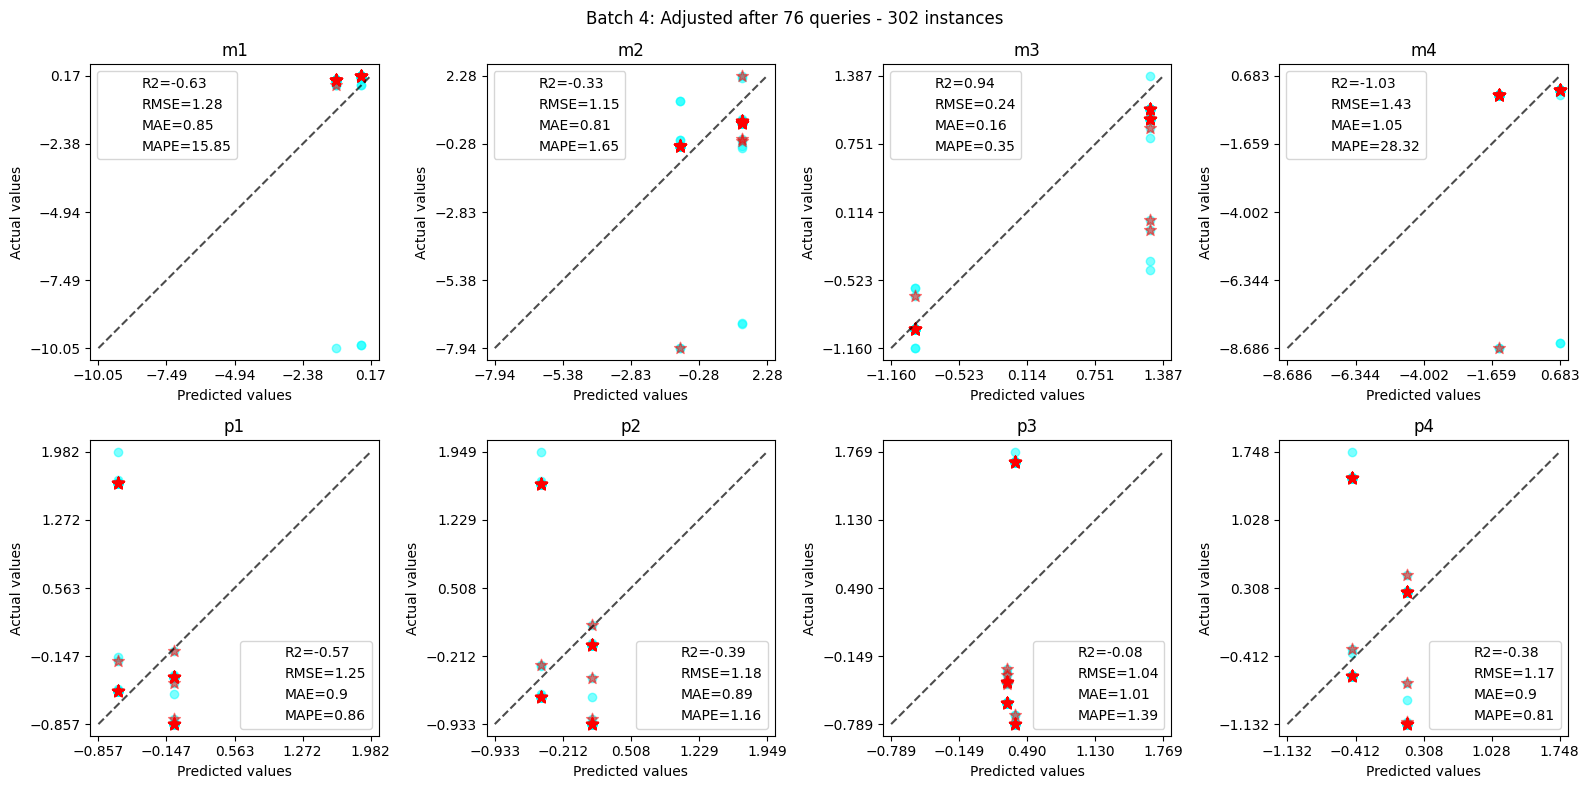

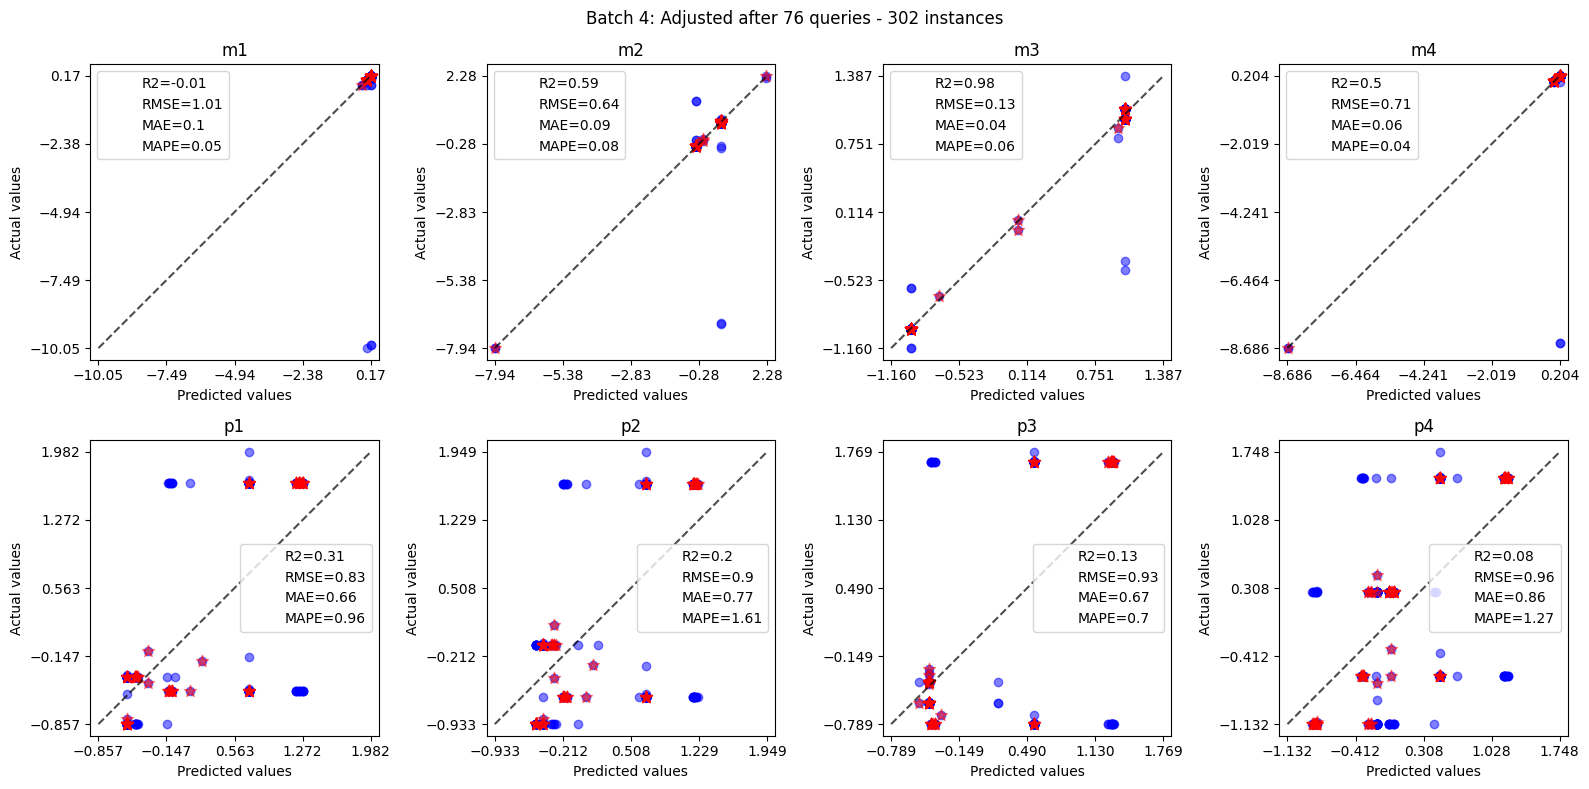


Adjusted metrics:
R2= 0.3484340188923903
MSE= 0.6515659811076098
RMSE= 0.8071963708464067
MAE= 0.40635047231754295
MAPE= 0.5949979002565855

Elapsed time: 16.74302012496628 seconds

oracle evaluation: 392 (out of 1192 points)
--> m1
R2= 0.3509048823273372
MSE= 0.6490951176726628
RMSE= 0.80566439518739
MAE= 0.05990037900448962
MAPE= 0.030489739061012277
--> m2
R2= 0.8424108026961357
MSE= 0.1575891973038643
RMSE= 0.39697505879319966
MAE= 0.059203900539641245
MAPE= 0.07473227987655225
--> m3
R2= 0.8760911893070029
MSE= 0.12390881069299706
RMSE= 0.3520068333044077
MAE= 0.1632487527113514
MAPE= 0.515482323522487
--> m4
R2= 0.5829696130729565
MSE= 0.4170303869270435
RMSE= 0.6457788994129829
MAE= 0.03791512634342355
MAPE= 0.01732911750502815
--> p1
R2= 0.26326061078586893
MSE= 0.7367393892141311
RMSE= 0.8583352429057839
MAE= 0.5713525103838155
MAPE= 1.0452537147905867
--> p2
R2= 0.24910868929363617
MSE= 0.7508913107063638
RMSE= 0.8665398494624259
MAE= 0.6049330562791696
MAPE= 1.1732958868218

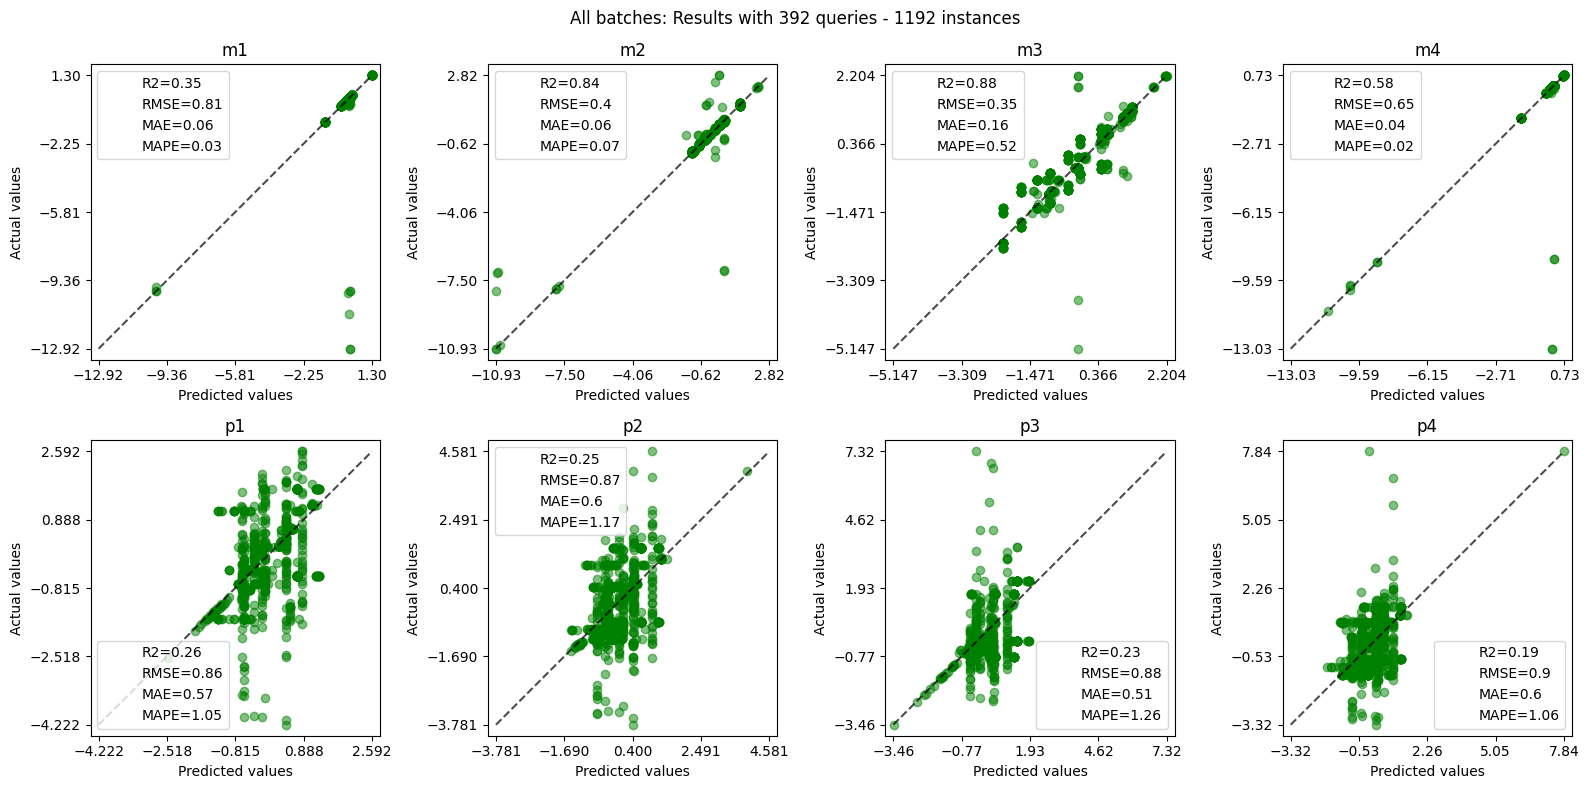

R2= 0.4476590091633389
MSE= 0.5523409908366601
RMSE= 0.7431964685308052
MAE= 0.32612041665073355
MAPE= 0.6465076064465903



exp  size  features  queries       time        R2  \
0  incremental - batch 0   125       419      125   0.236032  0.602382   
1  incremental - batch 1   344       419       86   3.095274  0.285858   
2  incremental - batch 2   301       419       75   2.996291  0.640325   
3  incremental - batch 3   120       419       30   2.781076  0.516765   
4  incremental - batch 4   302       419       76   3.263808  0.348434   
5      incremental - all  1192       419      392  16.743020  0.447659   

        MSE      RMSE       MAE      MAPE  
0  0.397618  0.630569  0.148010  0.275772  
1  0.714142  0.845069  0.309333  0.725648  
2  0.359675  0.599729  0.310256  0.521667  
3  0.483235  0.695151  0.397657  1.248597  
4  0.651566  0.807196  0.406350  0.594998  
5  0.552341  0.743196  0.326120  0.646508

In [22]:
print("COCOME - tactics only")
target = OBJ_COCOME
X, y, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=False, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(2,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

COCOME - embeddings only
levels 5 5
(125, 500) (125, 8)
standard scaling y ... 5
max 0.25 percentage - queries
Batch 0: (125, 500) (125, 8)
Batch 0: Initial training with 125 points - 125 instances
Regressor score=1.00 



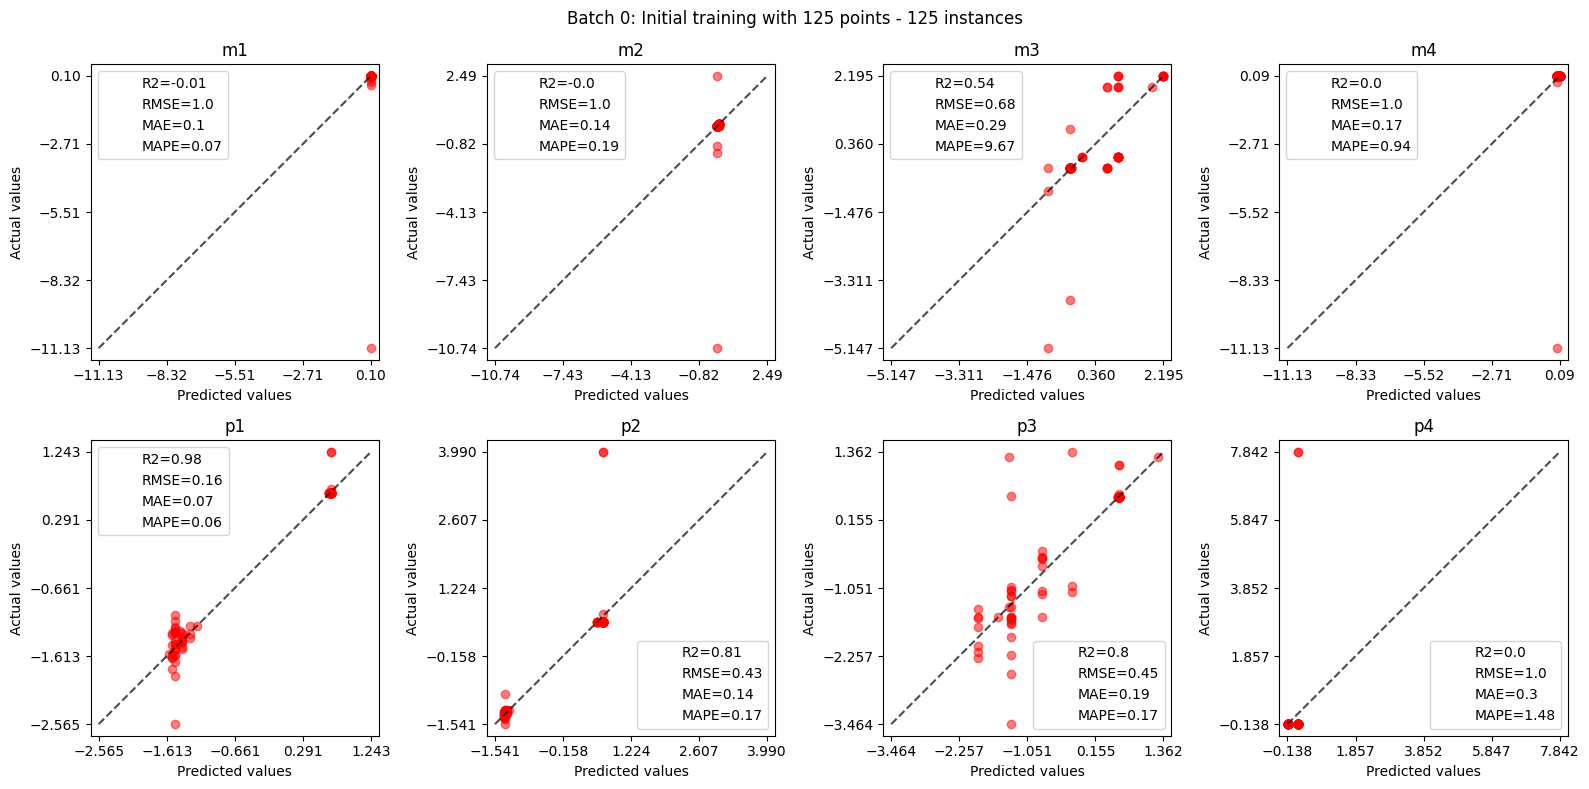


Initial metrics:
R2= 0.39006637439737823
MSE= 0.6099336256026218
RMSE= 0.780982474580974
MAE= 0.17497207308527413
MAPE= 1.5918267482736117

Batch  1 : (344, 500) (344, 8)
max 86 queries
Selecting indices at random!
0.25 86 queries: [54, 315, 333, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 304, 172, 14, 42, 318, 104, 195, 206, 298, 224, 48, 57, 296, 186, 92, 303, 249, 263, 99, 338, 231, 111, 248, 144, 256, 337, 52, 314, 45, 142, 143, 329, 311, 320, 210, 58, 340, 47, 217, 245, 86, 197, 233, 158, 291, 235, 223, 213, 305, 131, 242, 330, 120, 334, 250, 34]
Batch 1: Adjusted after 86 queries - 344 instances



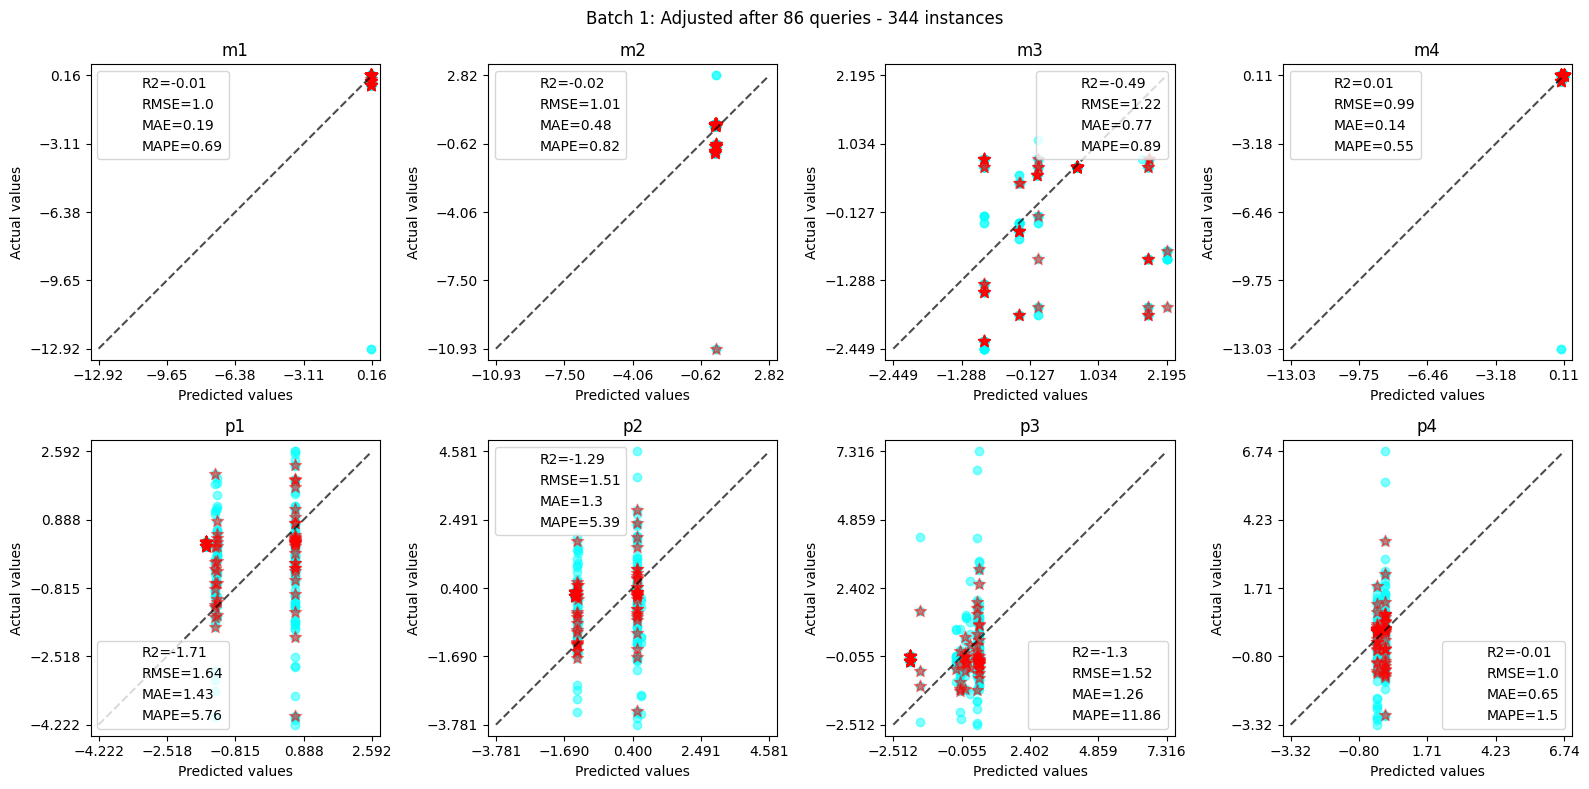

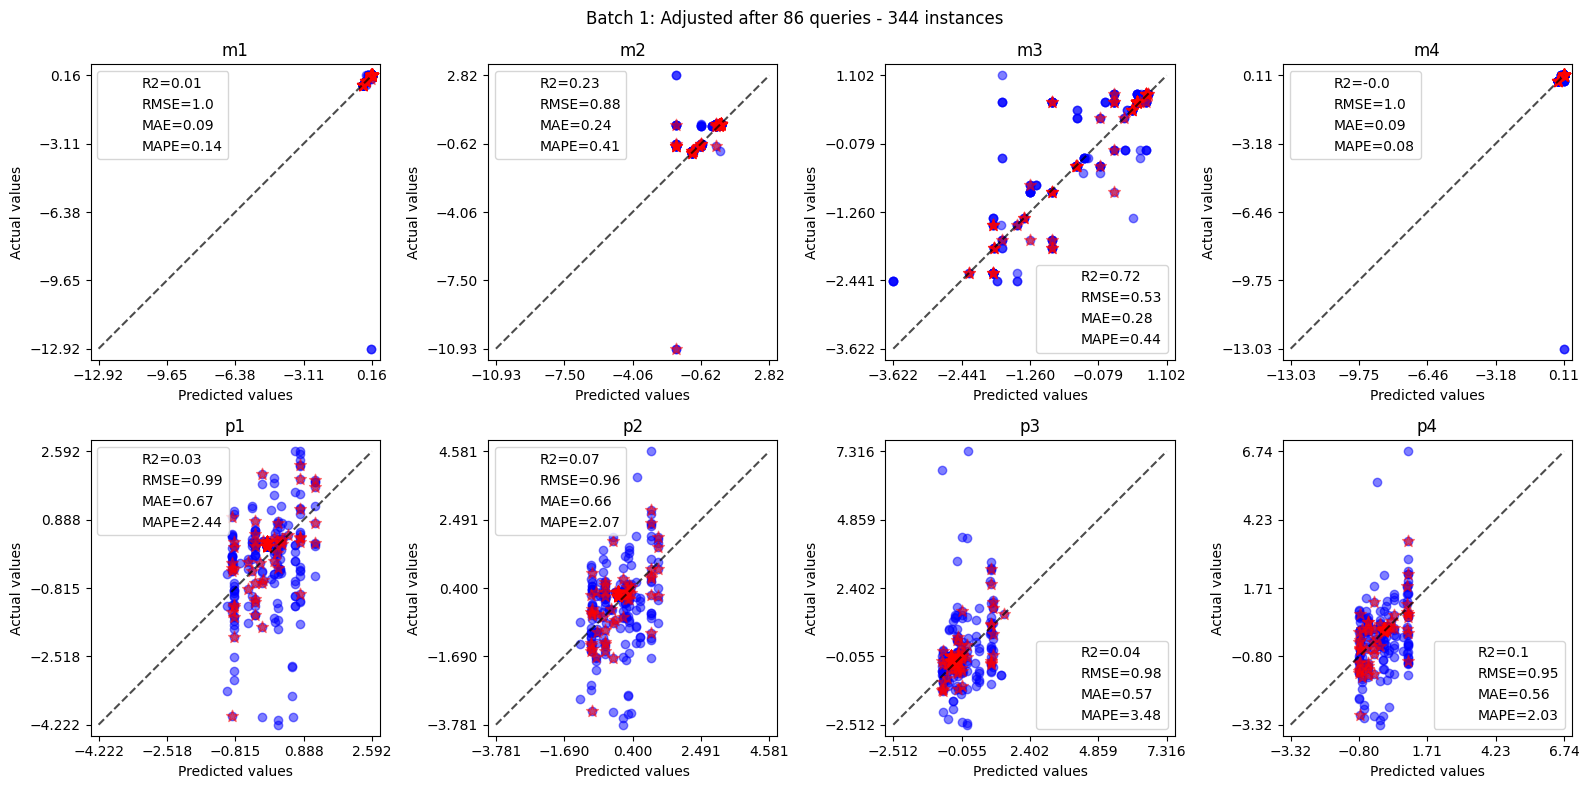


Adjusted metrics:
R2= 0.14936640902416404
MSE= 0.8506335909758358
RMSE= 0.922297994671915
MAE= 0.3949496495688979
MAPE= 1.3877064409510638

Batch  2 : (301, 500) (301, 8)
max 75 queries
Selecting indices at random!
0.25 75 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 172, 14, 42, 104, 195, 206, 298, 224, 48, 57, 296, 186, 92, 249, 263, 99, 231, 111, 248, 144, 256, 52, 45, 142, 143, 210, 58, 300, 47, 217, 245, 86, 273, 197, 233, 158, 235, 223, 213, 131, 242, 120, 250, 34, 291, 73, 136]
Batch 2: Adjusted after 75 queries - 301 instances



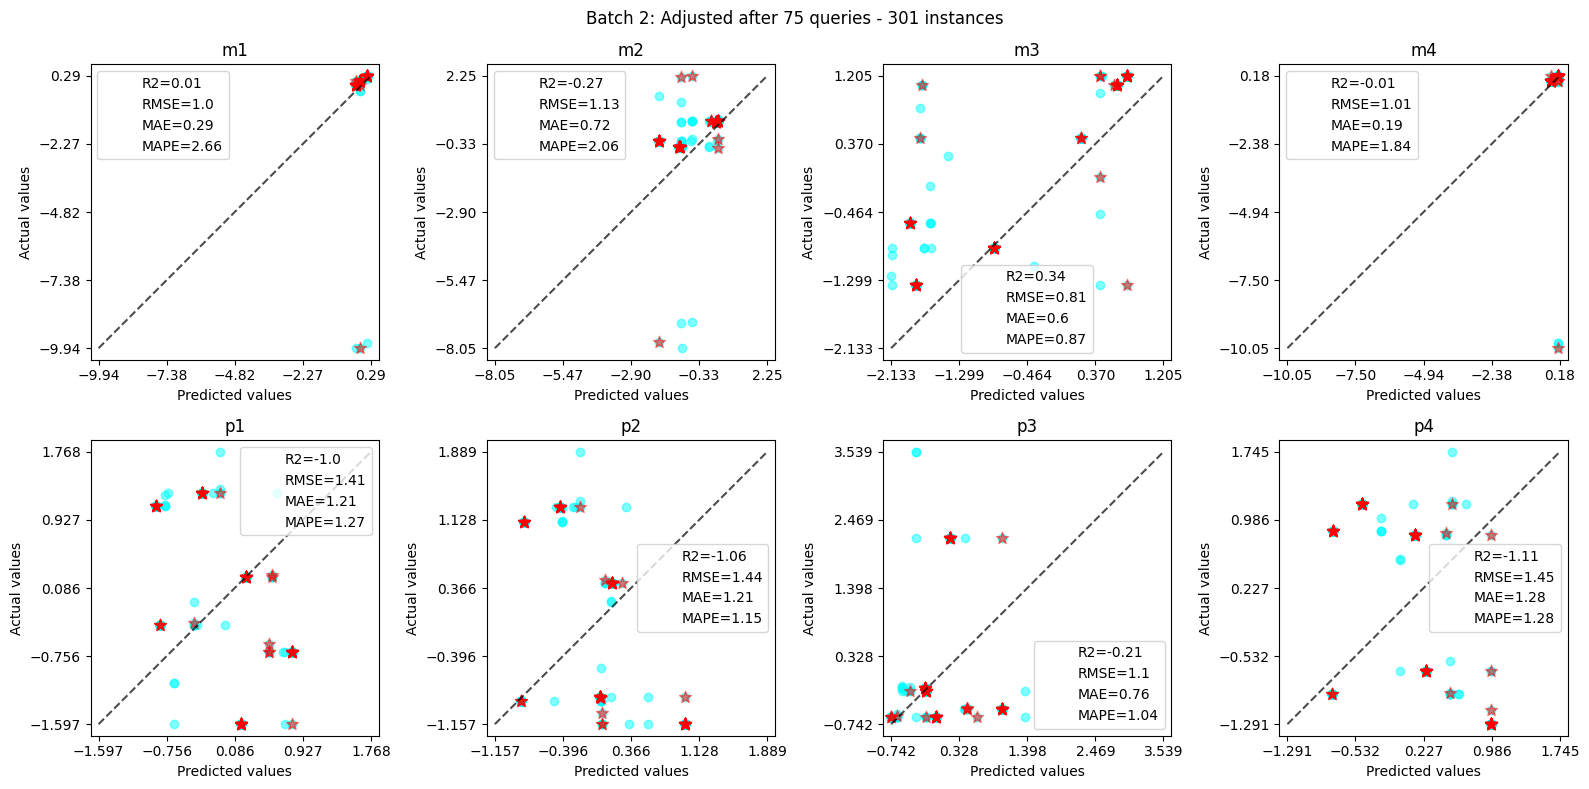

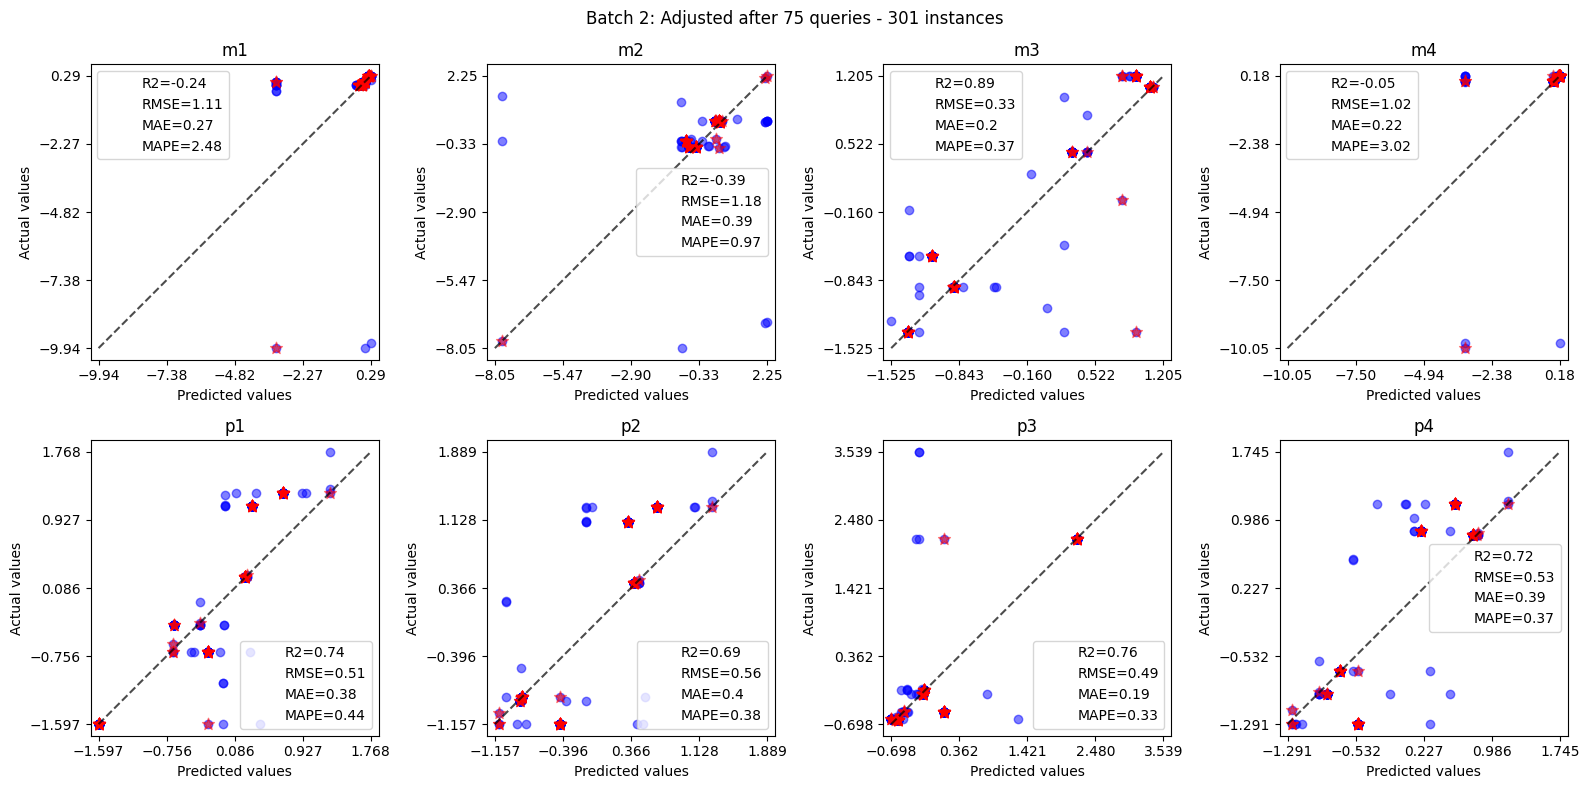


Adjusted metrics:
R2= 0.3915427860469622
MSE= 0.6084572139530378
RMSE= 0.7800366747487183
MAE= 0.30560586943886847
MAPE= 1.0461442941684678

Batch  3 : (120, 500) (120, 8)
max 30 queries
Selecting indices at random!
0.25 30 queries: [13, 78, 89, 96, 83, 67, 31, 34, 94, 32, 37, 93, 9, 84, 57, 38, 59, 87, 50, 101, 99, 15, 33, 28, 40, 45, 97, 46, 80, 91]
Batch 3: Adjusted after 30 queries - 120 instances



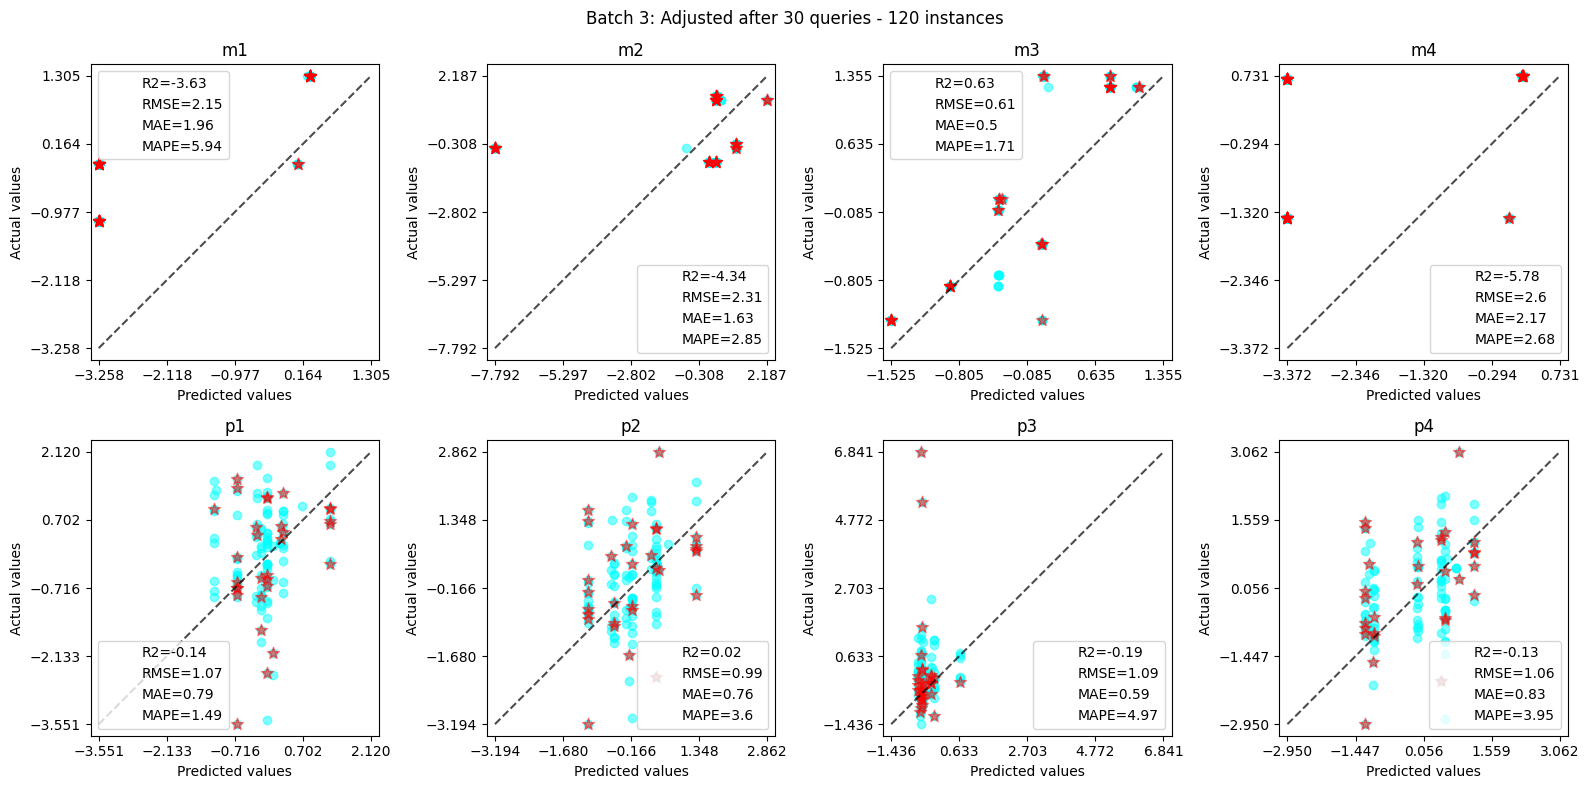

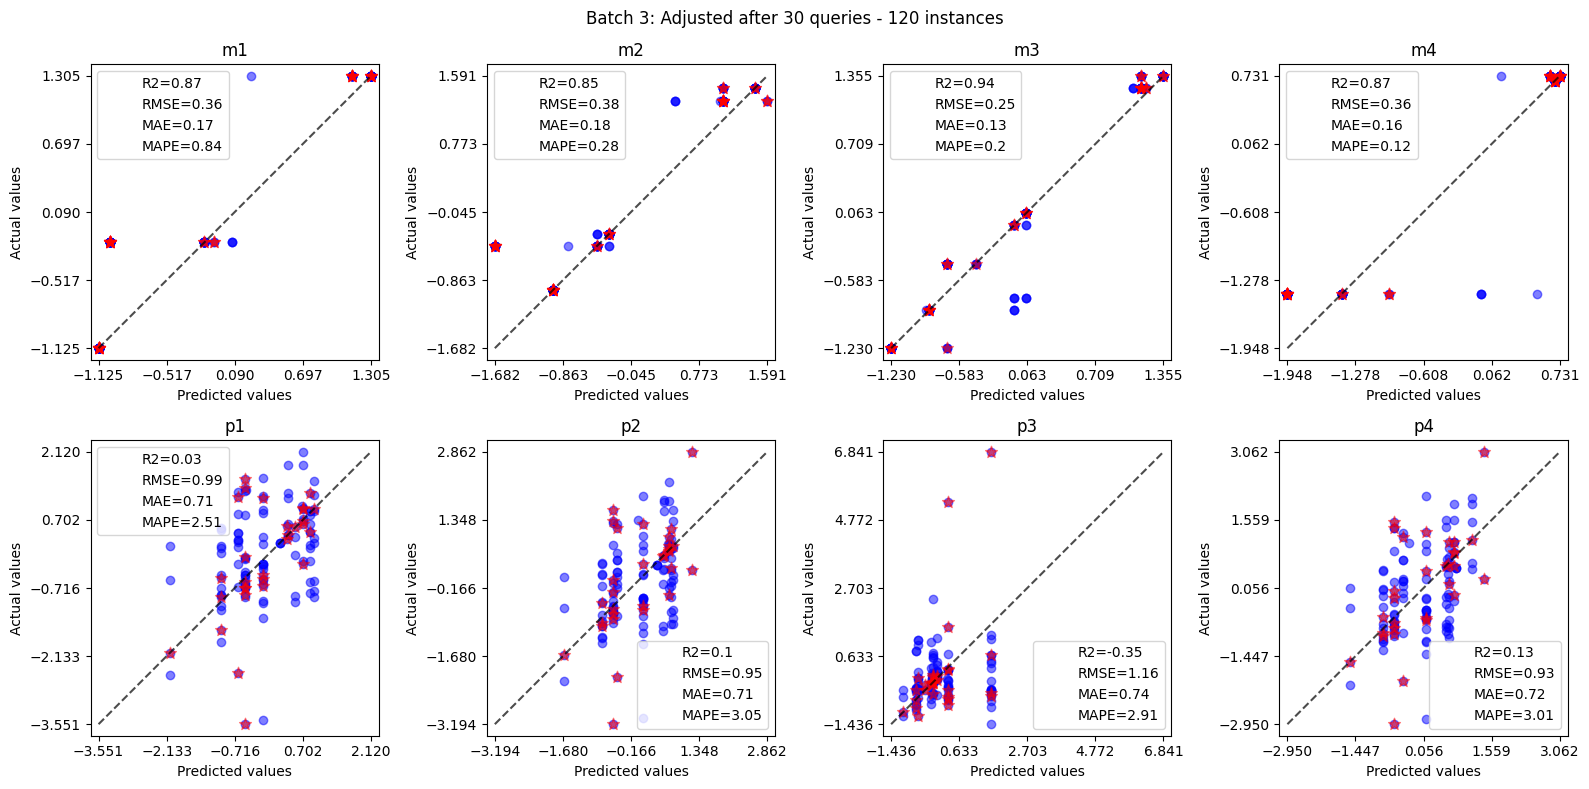


Adjusted metrics:
R2= 0.42965092319734544
MSE= 0.5703490768026546
RMSE= 0.7552145899031973
MAE= 0.4406974864732561
MAPE= 1.6149815710377247

Batch  4 : (302, 500) (302, 8)
max 76 queries
Selecting indices at random!
0.25 76 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 172, 14, 42, 104, 195, 206, 298, 224, 48, 57, 296, 301, 186, 92, 249, 263, 99, 231, 111, 248, 144, 256, 52, 45, 142, 143, 210, 58, 300, 47, 217, 245, 86, 273, 197, 233, 158, 235, 223, 213, 131, 242, 120, 250, 34, 291, 73, 136]
Batch 4: Adjusted after 76 queries - 302 instances



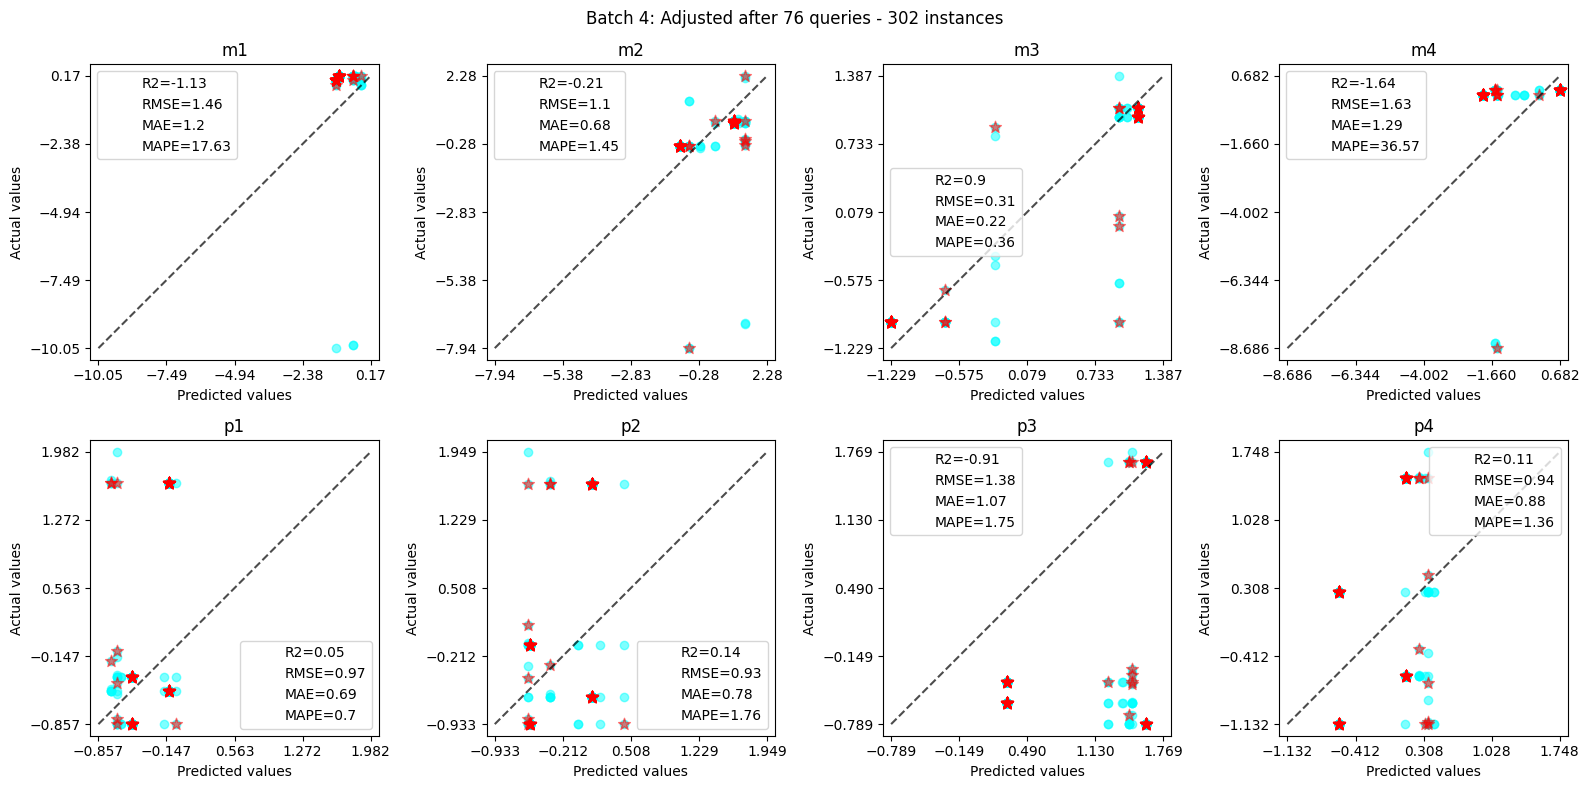

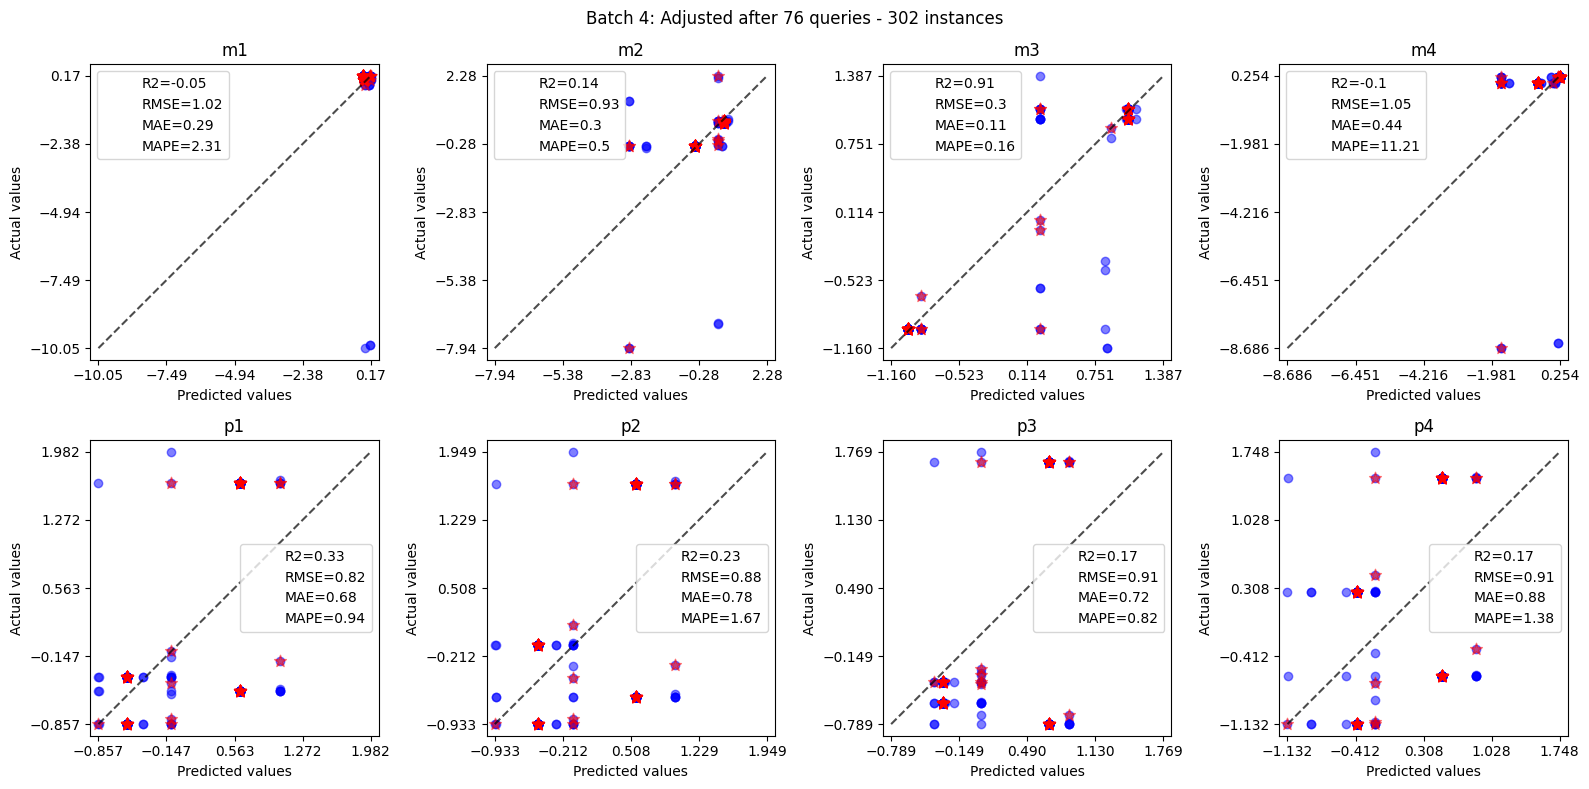


Adjusted metrics:
R2= 0.22388695263223554
MSE= 0.7761130473677644
RMSE= 0.8809727846918793
MAE= 0.523968505114413
MAPE= 2.3725995329420346

Elapsed time: 18.381707249907777 seconds

oracle evaluation: 392 (out of 1192 points)
--> m1
R2= 0.01707806182421512
MSE= 0.9829219381757849
RMSE= 0.9914241968883879
MAE= 0.1942726294793986
MAPE= 1.3419833826508036
--> m2
R2= 0.08655989960578192
MSE= 0.913440100394218
RMSE= 0.9557406030896762
MAE= 0.2748826993029234
MAPE= 0.5378460764024988
--> m3
R2= 0.8154791860929771
MSE= 0.1845208139070229
RMSE= 0.42955885965374163
MAE= 0.20130527835385353
MAPE= 1.2943025976695788
--> m4
R2= 0.048667289807996506
MSE= 0.9513327101920035
RMSE= 0.9753628607815675
MAE= 0.22663321070148823
MAPE= 3.7361315890191116
--> p1
R2= 0.38429248383920867
MSE= 0.6157075161607913
RMSE= 0.7846703232318598
MAE= 0.5421203260679296
MAPE= 1.312389045362354
--> p2
R2= 0.3478697122563825
MSE= 0.6521302877436175
RMSE= 0.8075458425028375
MAE= 0.5764457044727936
MAPE= 1.4434690831276493

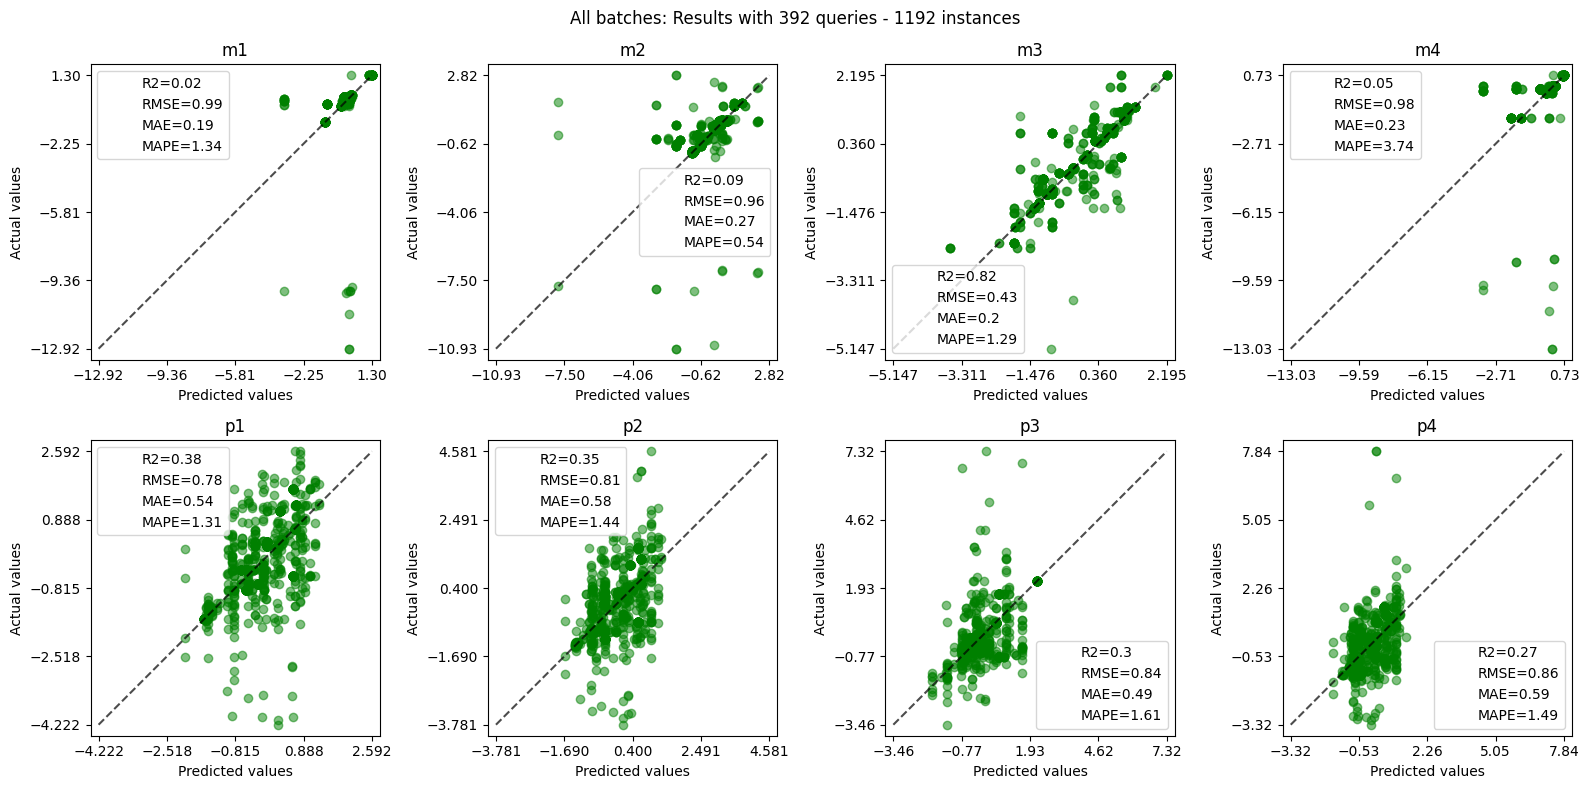

R2= 0.2828579618982666
MSE= 0.717142038101733
RMSE= 0.8468423927164564
MAE= 0.386613877692789
MAPE= 1.5952698315764264



exp  size  features  queries       time        R2  \
0  incremental - batch 0   125       500      125   0.205345  0.390066   
1  incremental - batch 1   344       500       86   3.145298  0.149366   
2  incremental - batch 2   301       500       75   3.218440  0.391543   
3  incremental - batch 3   120       500       30   3.394932  0.429651   
4  incremental - batch 4   302       500       76   3.842913  0.223887   
5      incremental - all  1192       500      392  18.381707  0.282858   

        MSE      RMSE       MAE      MAPE  
0  0.609934  0.780982  0.174972  1.591827  
1  0.850634  0.922298  0.394950  1.387706  
2  0.608457  0.780037  0.305606  1.046144  
3  0.570349  0.755215  0.440697  1.614982  
4  0.776113  0.880973  0.523969  2.372600  
5  0.717142  0.846842  0.386614  1.595270

In [23]:
print("COCOME - embeddings only")
target = OBJ_COCOME
X, y, _ = get_regression_data(df_cocome, target=target, tactics=False, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=0.25, calibration=True, show_plots=(2,4),
                                      target=target, verbose=False, show_errors=False)

print()
pd.DataFrame(metrics)

COCOME - tactics & embeddings
levels 5 5
(125, 919) (125, 8)
standard scaling y ... 5
max 0.5 percentage - queries
Batch 0: (125, 919) (125, 8)
Batch 0: Initial training with 125 points - 125 instances
Regressor score=1.00 



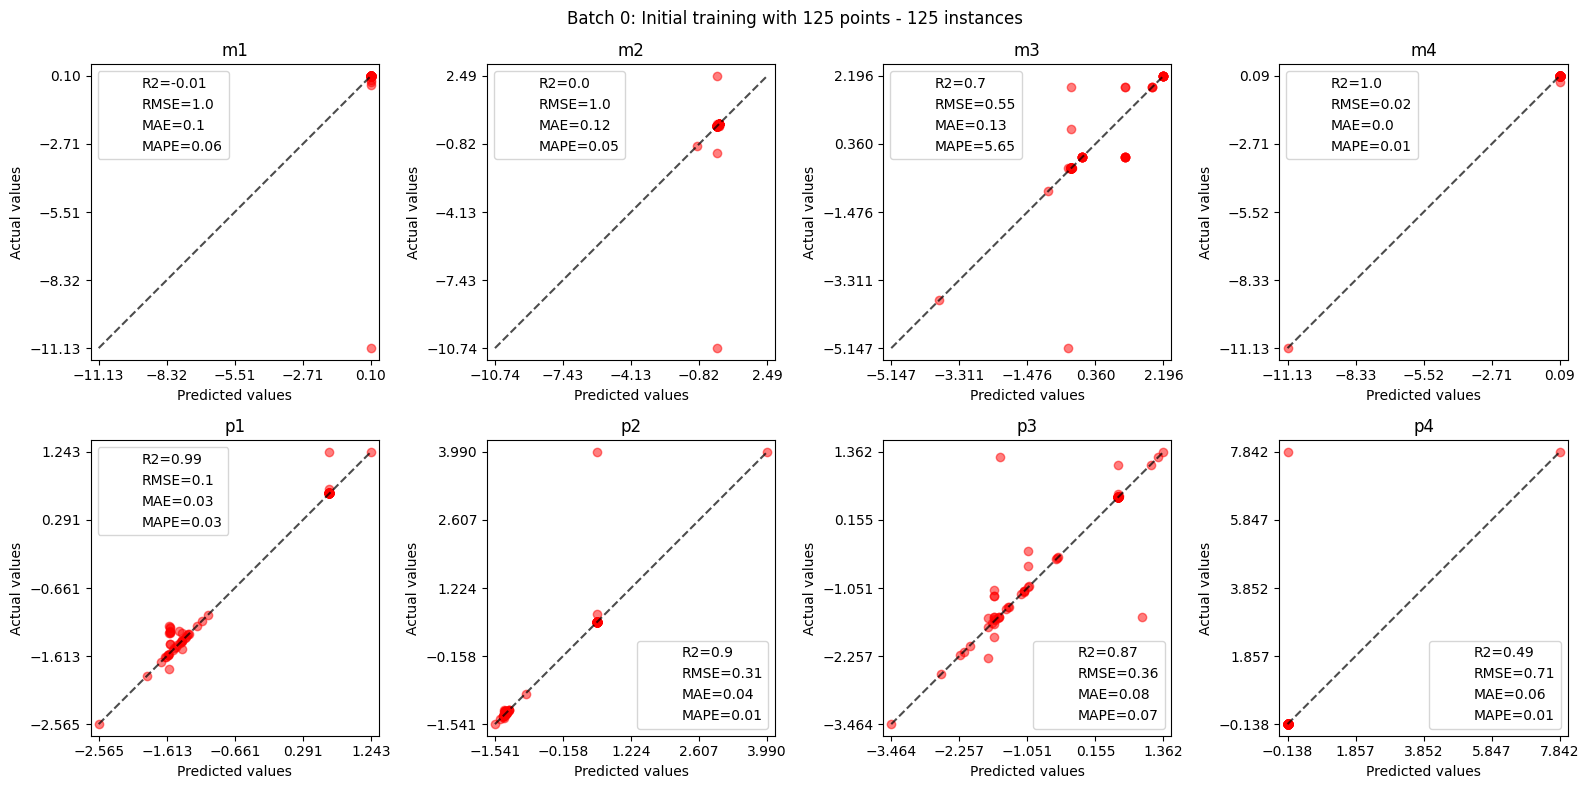


Initial metrics:
R2= 0.6185861065382718
MSE= 0.38141389346172805
RMSE= 0.6175871545472169
MAE= 0.06971945814456577
MAPE= 0.7361003380402932

Batch  1 : (344, 919) (344, 8)
max 172 queries
Selecting indices at random!
0.5 172 queries: [54, 315, 333, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 282, 140, 84, 5, 35, 62, 304, 172, 14, 42, 318, 104, 195, 206, 298, 224, 48, 57, 296, 186, 92, 303, 249, 263, 99, 338, 231, 111, 248, 144, 256, 337, 52, 314, 45, 142, 143, 329, 311, 320, 210, 58, 340, 47, 217, 245, 86, 197, 233, 158, 291, 235, 223, 213, 305, 131, 242, 330, 120, 334, 250, 34, 73, 259, 136, 146, 112, 4, 211, 180, 103, 241, 108, 316, 88, 181, 145, 94, 240, 261, 67, 91, 77, 135, 265, 10, 160, 283, 277, 204, 65, 24, 295, 25, 8, 49, 79, 6, 0, 150, 129, 72, 324, 205, 332, 64, 29, 225, 335, 198, 50, 221, 278, 214, 128, 239, 46, 63, 53, 154, 174, 317, 74, 323, 194, 301, 212, 232, 152, 189, 40, 288, 165, 209, 93, 125, 98, 286, 227, 13

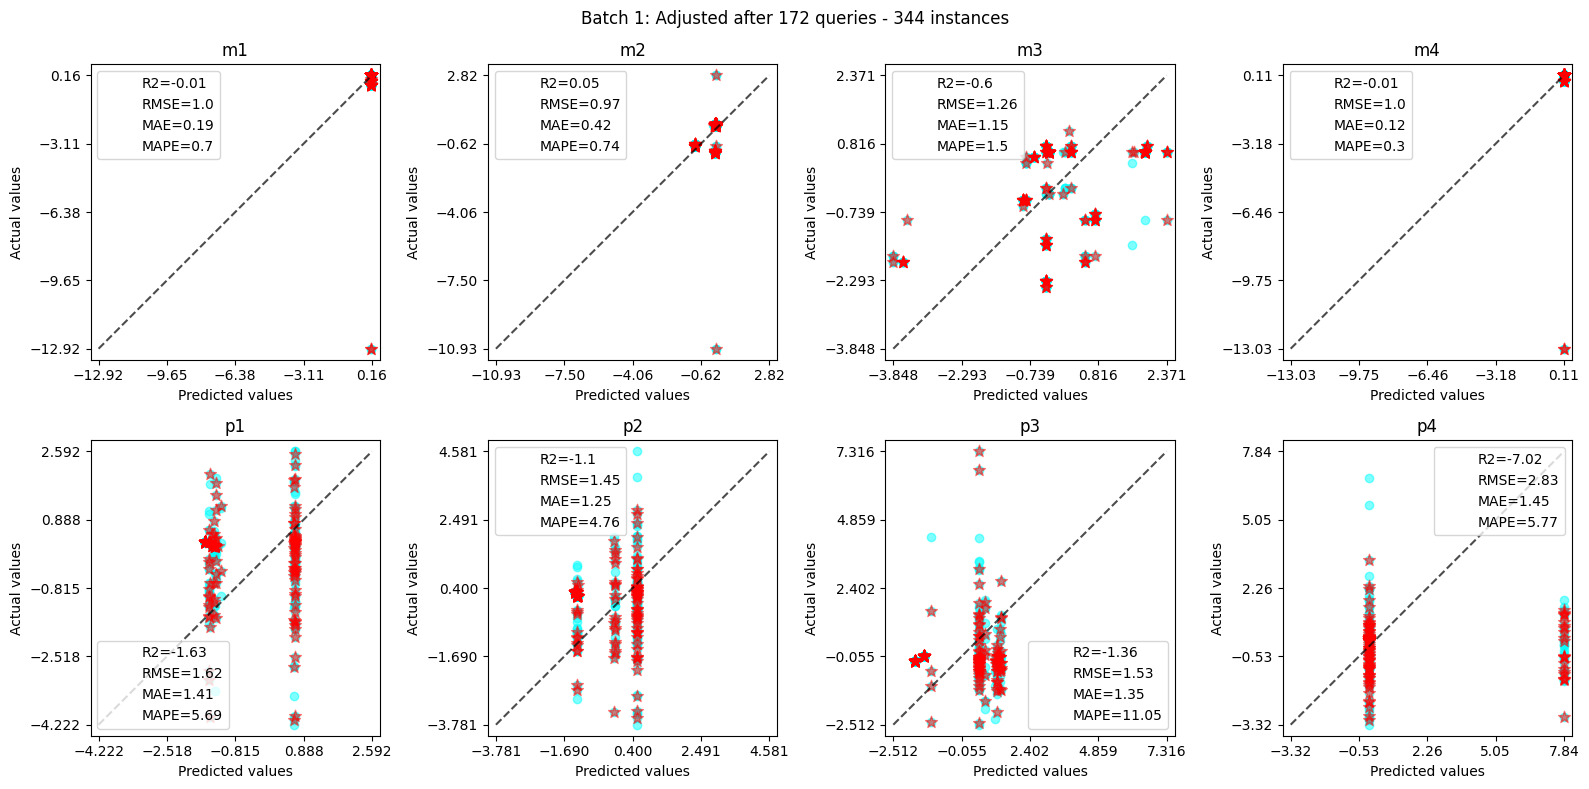

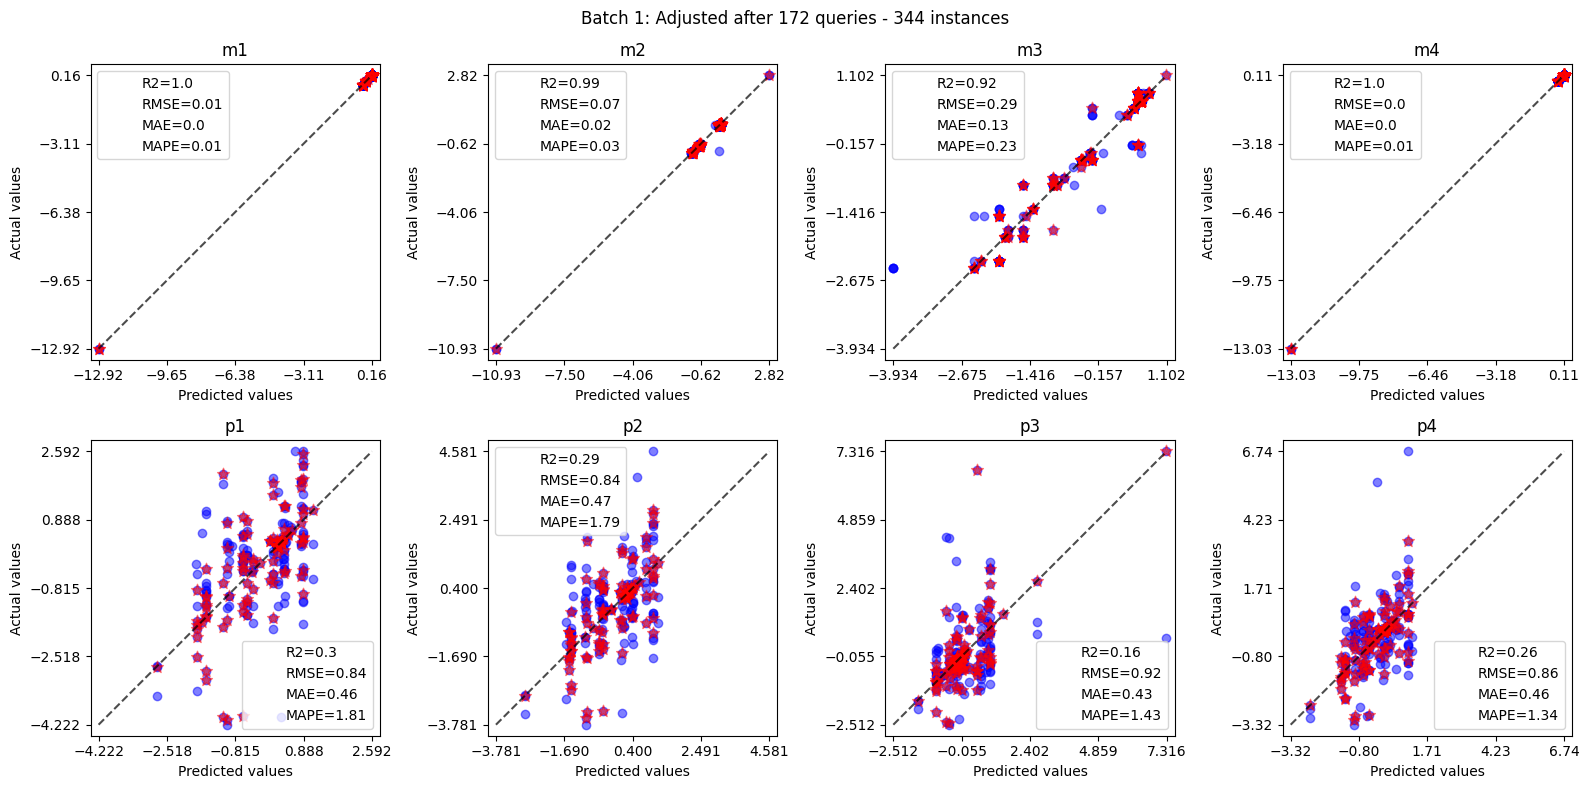


Adjusted metrics:
R2= 0.6136259988615114
MSE= 0.3863740011384886
RMSE= 0.6215898978735808
MAE= 0.24648778397602406
MAPE= 0.8306071943392583

Batch  2 : (301, 919) (301, 8)
max 150 queries
Selecting indices at random!
0.5 150 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 140, 84, 5, 35, 62, 172, 14, 42, 278, 104, 195, 206, 224, 48, 57, 186, 92, 265, 249, 99, 297, 231, 111, 248, 204, 72, 128, 65, 26, 31, 209, 22, 71, 246, 30, 7, 41, 189, 105, 29, 175, 287, 150, 23, 108, 122, 291, 43, 136, 98, 116, 79, 124, 117, 256, 106, 152, 211, 24, 251, 121, 100, 288, 115, 157, 125, 17, 145, 36, 213, 180, 68, 146, 112, 4, 208, 103, 234, 276, 88, 181, 221, 94, 120, 67, 91, 77, 135, 261, 10, 160, 143, 268, 219, 220, 259, 25, 8, 49, 227, 6, 0, 236, 129, 253, 283, 193, 64, 239, 198, 294, 50, 177, 58, 171, 252, 194, 46, 63, 53, 154, 277, 74, 196, 169, 187, 222, 40]
Batch 2: Adjusted after 150 queries - 301 instances



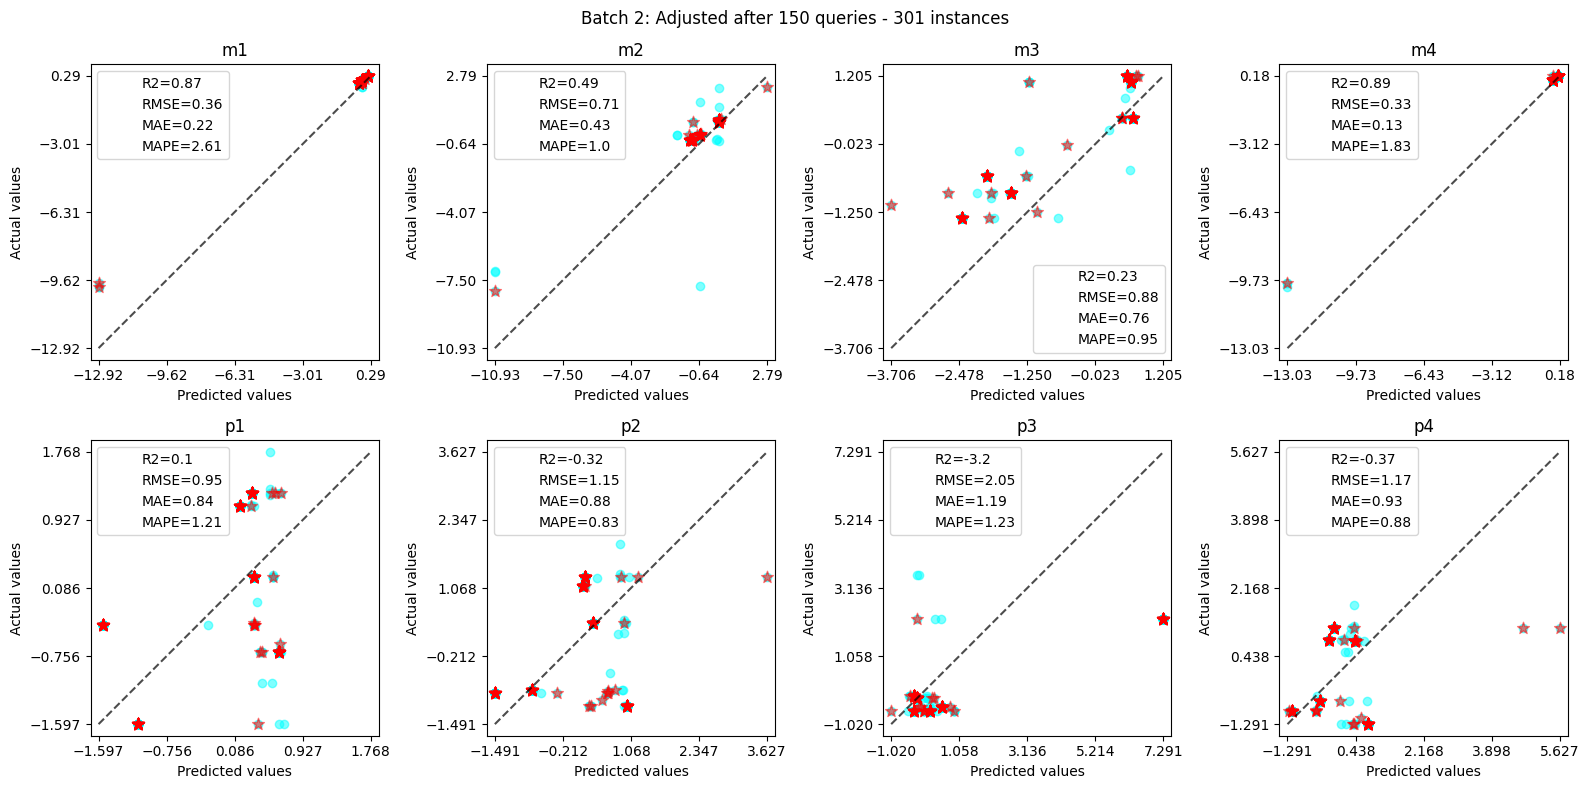

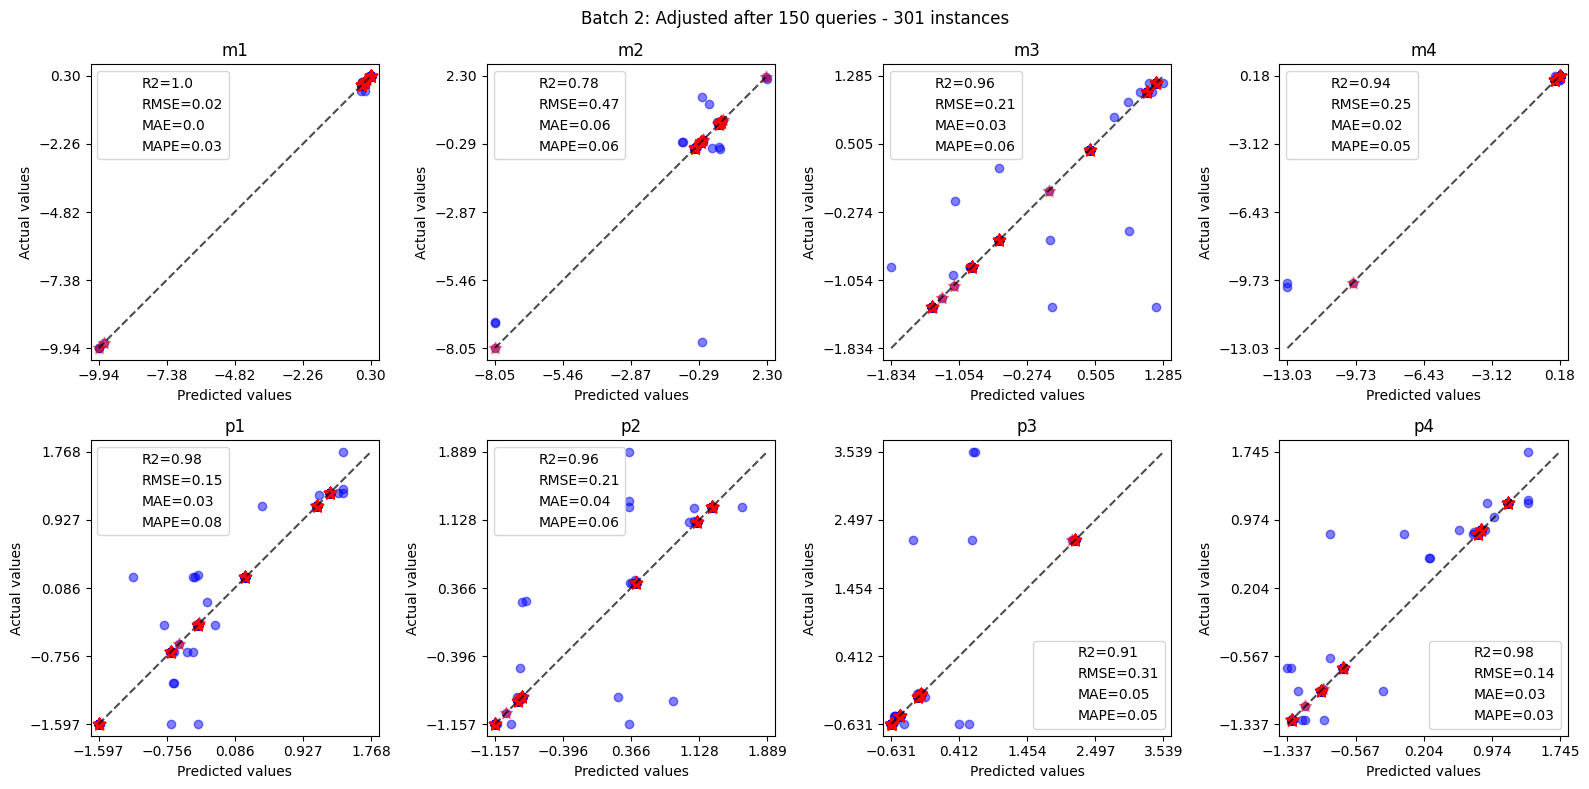


Adjusted metrics:
R2= 0.9363893554951552
MSE= 0.0636106445048448
RMSE= 0.25221150747903
MAE= 0.0321933055085018
MAPE= 0.051487230333807234

Batch  3 : (120, 919) (120, 8)
max 60 queries
Selecting indices at random!
0.5 60 queries: [13, 78, 89, 96, 83, 67, 31, 34, 94, 32, 37, 93, 9, 84, 57, 38, 59, 87, 50, 101, 99, 15, 33, 28, 40, 45, 97, 46, 80, 91, 66, 19, 20, 70, 85, 106, 35, 21, 1, 8, 98, 76, 43, 3, 10, 115, 26, 48, 51, 56, 12, 14, 92, 23, 69, 62, 24, 17, 116, 39]
Batch 3: Adjusted after 60 queries - 120 instances



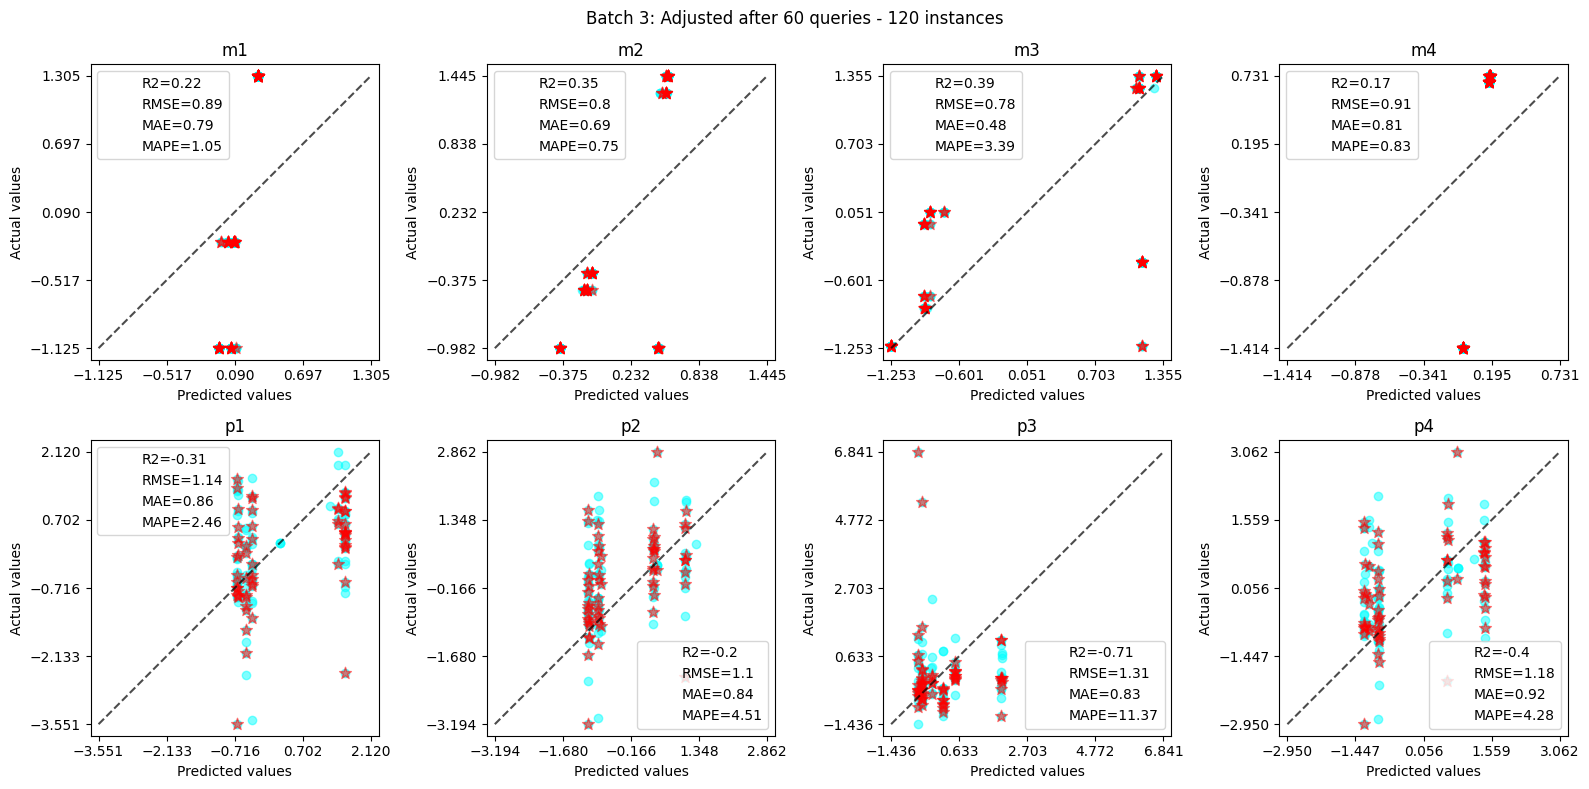

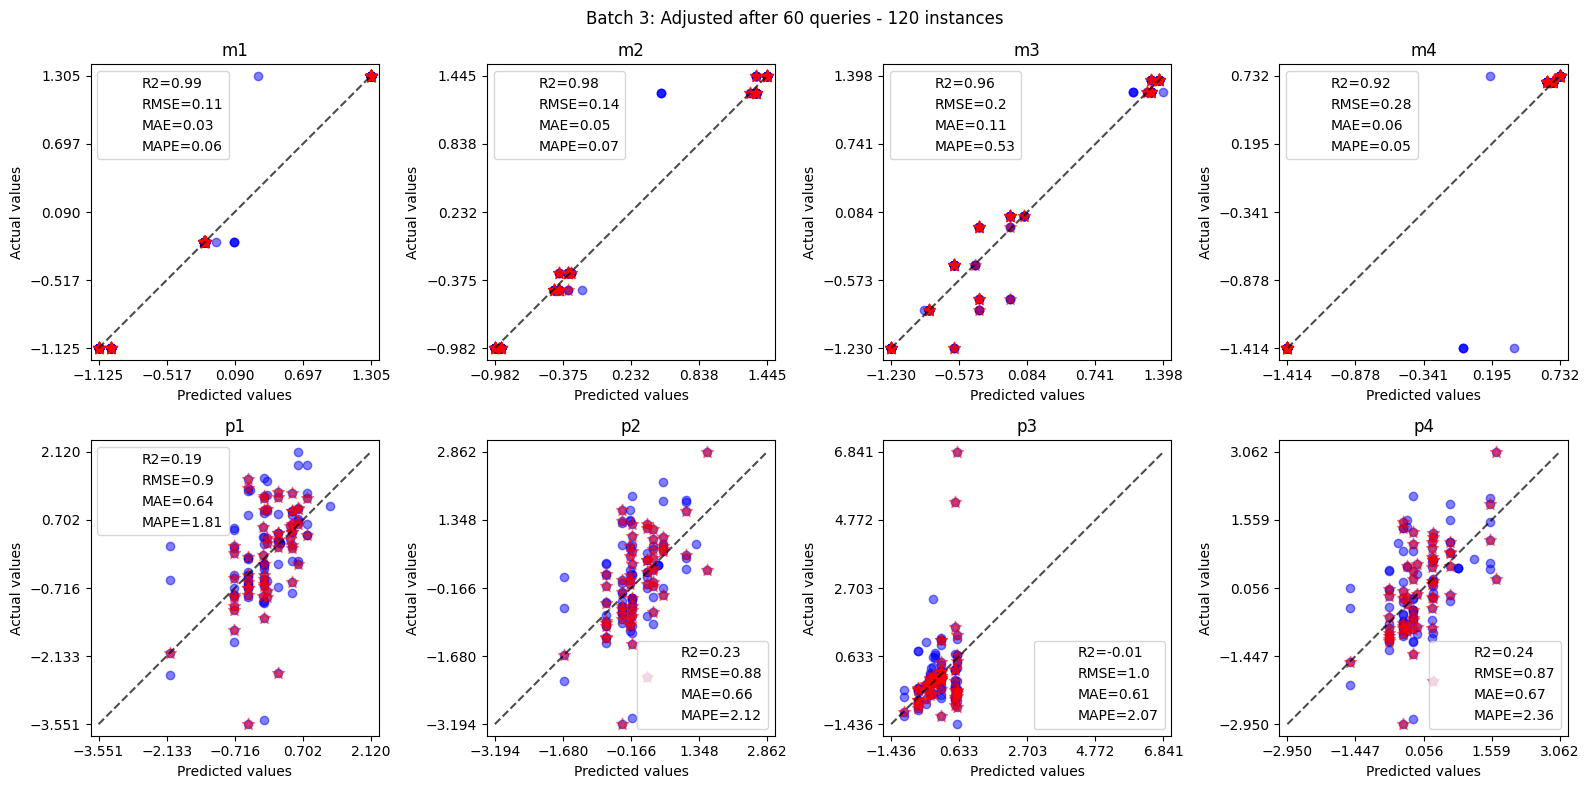


Adjusted metrics:
R2= 0.5638805961534905
MSE= 0.43611940384650955
RMSE= 0.6603933705349483
MAE= 0.354681347872042
MAPE= 1.1352130726445824

Batch  4 : (302, 919) (302, 8)
max 151 queries
Selecting indices at random!
0.5 151 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 264, 76, 82, 140, 84, 5, 35, 62, 172, 14, 42, 279, 104, 195, 206, 224, 48, 57, 186, 92, 266, 249, 99, 298, 231, 111, 248, 144, 128, 65, 26, 31, 209, 22, 71, 256, 30, 7, 41, 189, 105, 29, 175, 288, 150, 23, 108, 122, 240, 43, 136, 98, 116, 79, 124, 117, 257, 106, 152, 211, 24, 253, 121, 100, 289, 115, 157, 125, 17, 145, 36, 215, 180, 68, 146, 112, 4, 210, 103, 236, 277, 88, 181, 213, 94, 120, 67, 91, 77, 135, 262, 10, 160, 143, 197, 221, 222, 260, 25, 8, 49, 229, 6, 0, 292, 129, 72, 284, 300, 64, 241, 285, 295, 50, 179, 58, 173, 254, 196, 46, 63, 53, 154, 278, 74, 198, 171, 243, 267, 40, 297, 169]
Batch 4: Adjusted after 151 queries - 302 instances



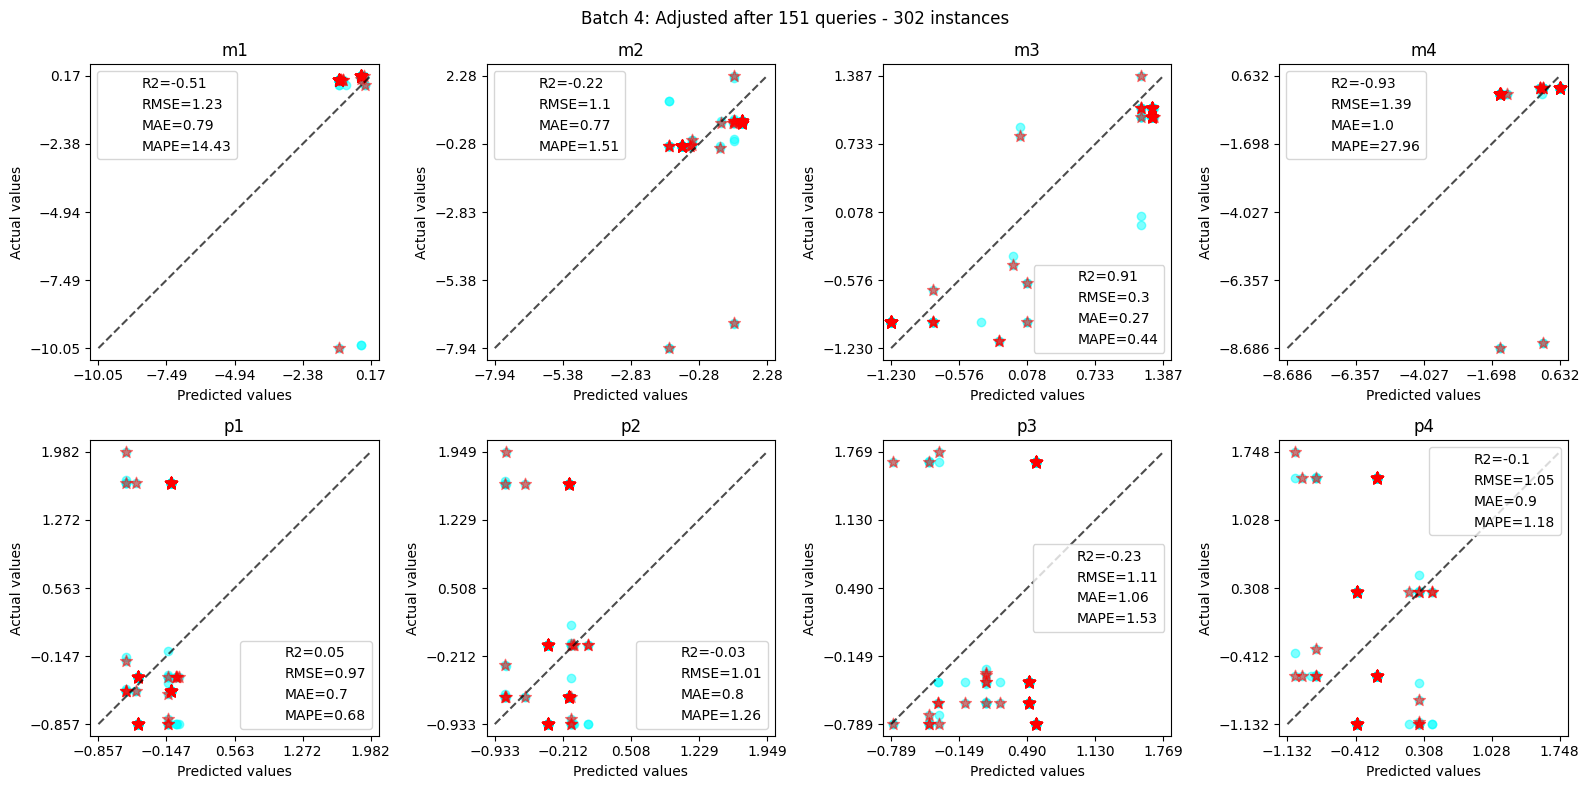

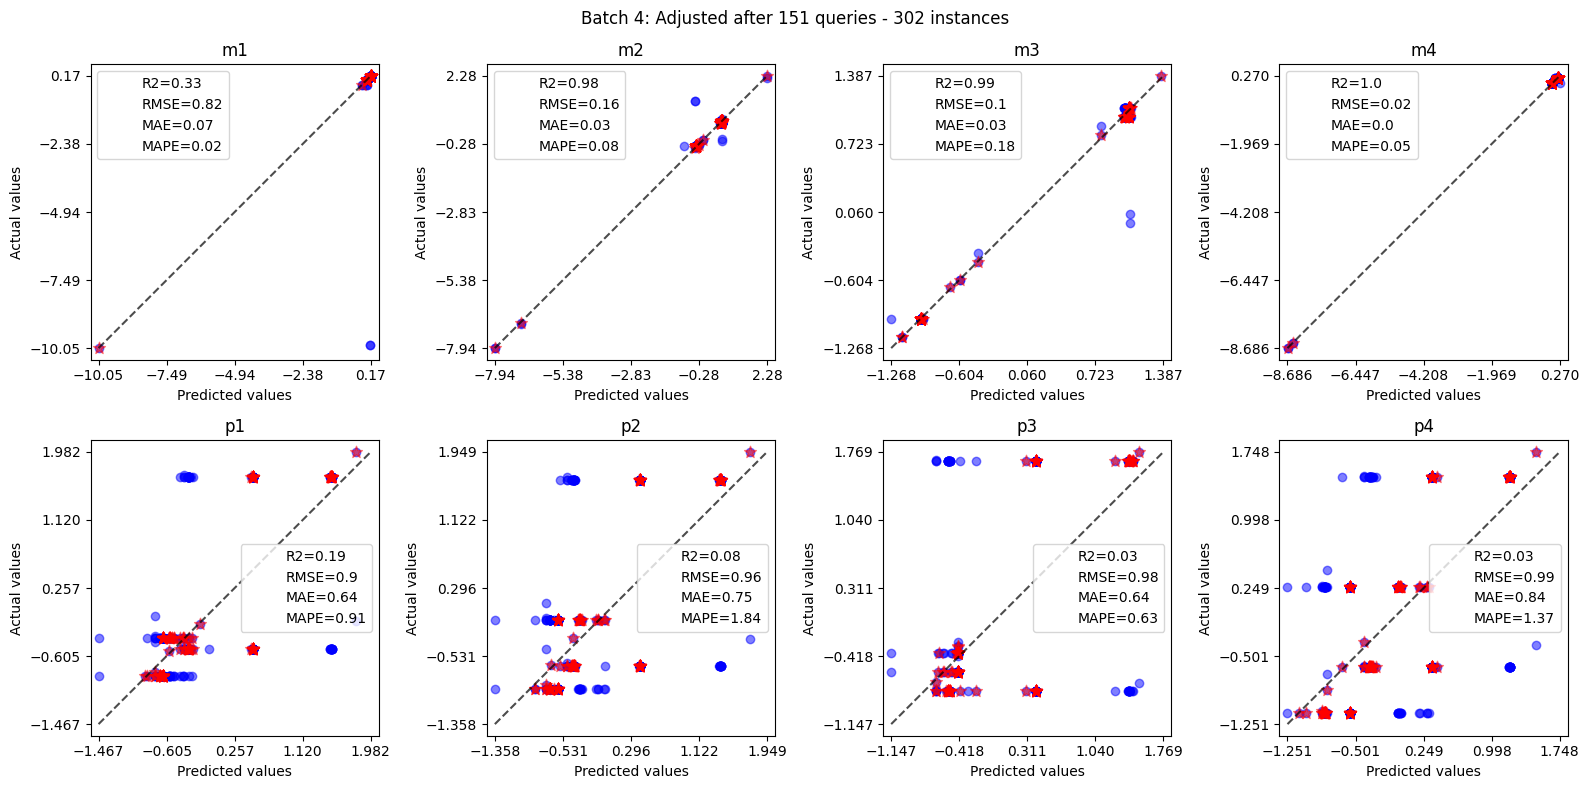


Adjusted metrics:
R2= 0.45226889768737083
MSE= 0.5477311023126292
RMSE= 0.7400885773423538
MAE= 0.375301854488075
MAPE= 0.6356411726274536

Elapsed time: 43.85368241695687 seconds

oracle evaluation: 658 (out of 1192 points)
--> m1
R2= 0.7225915033780195
MSE= 0.2774084966219805
RMSE= 0.5266958293189539
MAE= 0.03208900922493728
MAPE= 0.026767727723621224
--> m2
R2= 0.829546094945937
MSE= 0.1704539050540629
RMSE= 0.4128606363581577
MAE= 0.045591349348224904
MAPE= 0.056640751446452295
--> m3
R2= 0.9268955347662027
MSE= 0.07310446523379734
RMSE= 0.2703783741977108
MAE= 0.07758079914585686
MAPE= 0.7745189304139841
--> m4
R2= 0.9760840497348915
MSE= 0.023915950265108527
RMSE= 0.15464782657738366
MAE= 0.012973522521601869
MAPE= 0.03281459619889697
--> p1
R2= 0.5022850960856425
MSE= 0.49771490391435746
RMSE= 0.7054891238809834
MAE= 0.37280019744327064
MAPE= 0.9559694521016583
--> p2
R2= 0.4626597722499918
MSE= 0.5373402277500082
RMSE= 0.7330349430620673
MAE= 0.40527791316651424
MAPE= 1.212424

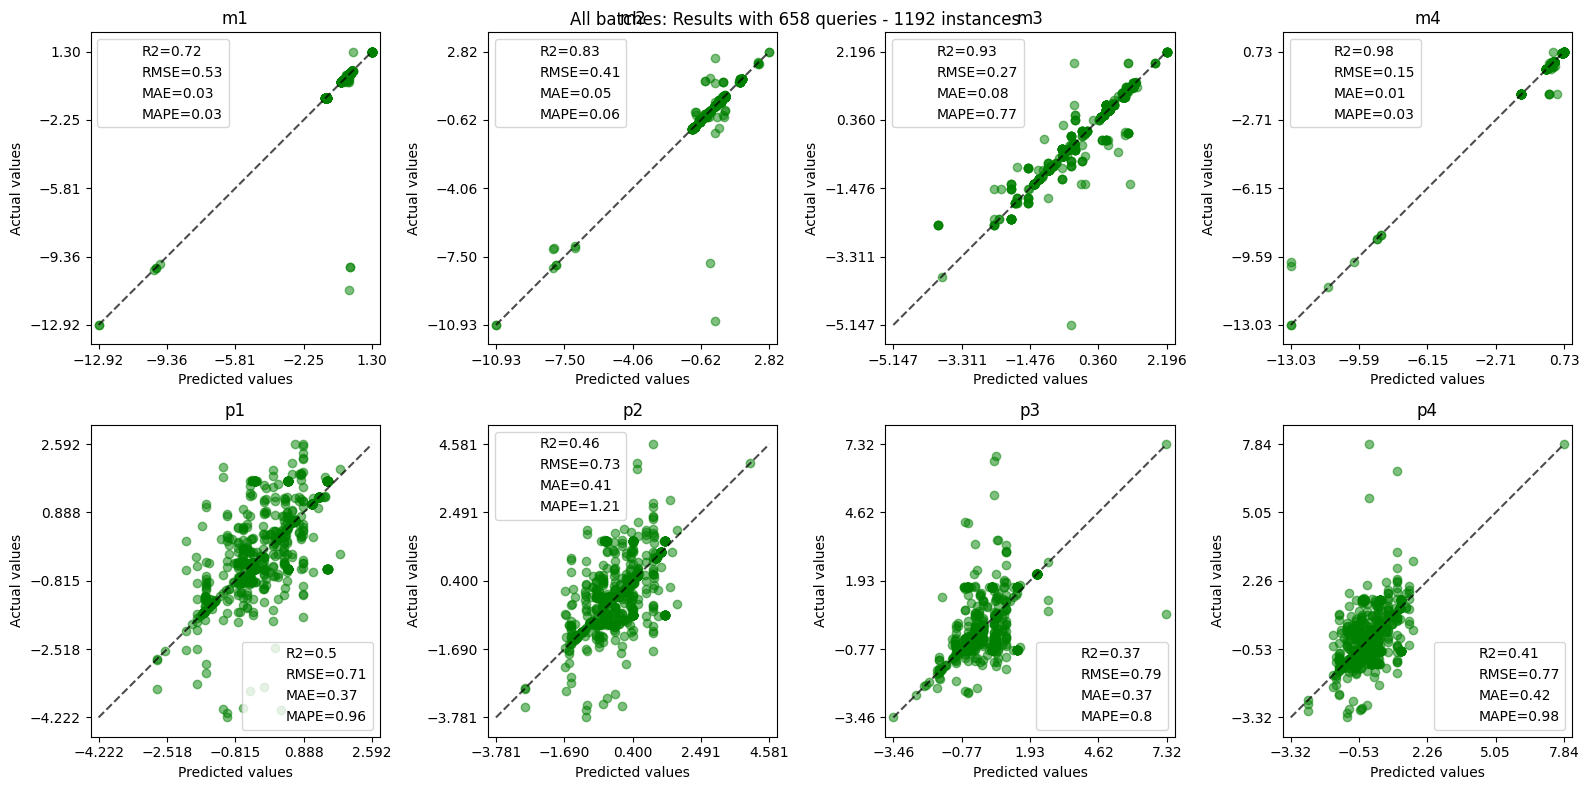

R2= 0.649760638900746
MSE= 0.35023936109925324
RMSE= 0.5918102407860591
MAE= 0.21736563482711926
MAPE= 0.6052250640008886



exp  size  features  queries       time        R2  \
0  incremental - batch 0   125       919      125   0.478833  0.618586   
1  incremental - batch 1   344       919      172  10.718805  0.613626   
2  incremental - batch 2   301       919      150   8.873771  0.936389   
3  incremental - batch 3   120       919       60   8.679597  0.563881   
4  incremental - batch 4   302       919      151  10.346517  0.452269   
5      incremental - all  1192       919      658  43.853682  0.649761   

        MSE      RMSE       MAE      MAPE  
0  0.381414  0.617587  0.069719  0.736100  
1  0.386374  0.621590  0.246488  0.830607  
2  0.063611  0.252212  0.032193  0.051487  
3  0.436119  0.660393  0.354681  1.135213  
4  0.547731  0.740089  0.375302  0.635641  
5  0.350239  0.591810  0.217366  0.605225

In [24]:
print("COCOME - tactics & embeddings")
target = OBJ_COCOME
X, y, fnames = get_regression_data(df_cocome, target=target, tactics=True, embeddings=True, split_by_level=True)
print("levels", len(X), len(y))
print(X[0].shape, y[0].shape)

regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
regressor = regr_xgb # regr_rf # regr_xgb

metrics, y_pred_ial_cocome = run_active_learning_batches(X, y, regressor, n_queries=0.5, calibration=True, show_plots=(2,4),
                                      target=target, verbose=False, show_errors=False, filename='cocome-incremental-all.pdf')

print()
pd.DataFrame(metrics)

Target: m1


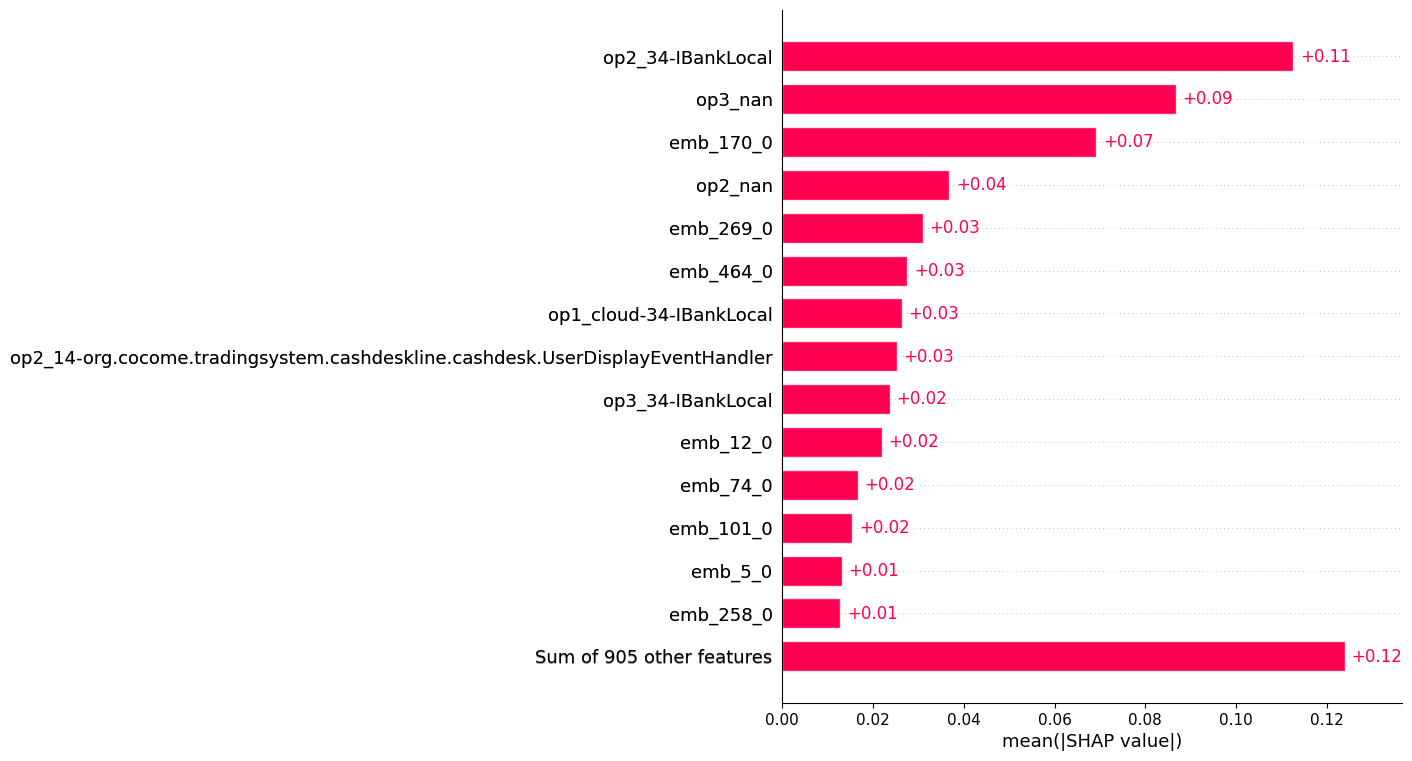

Target: m2


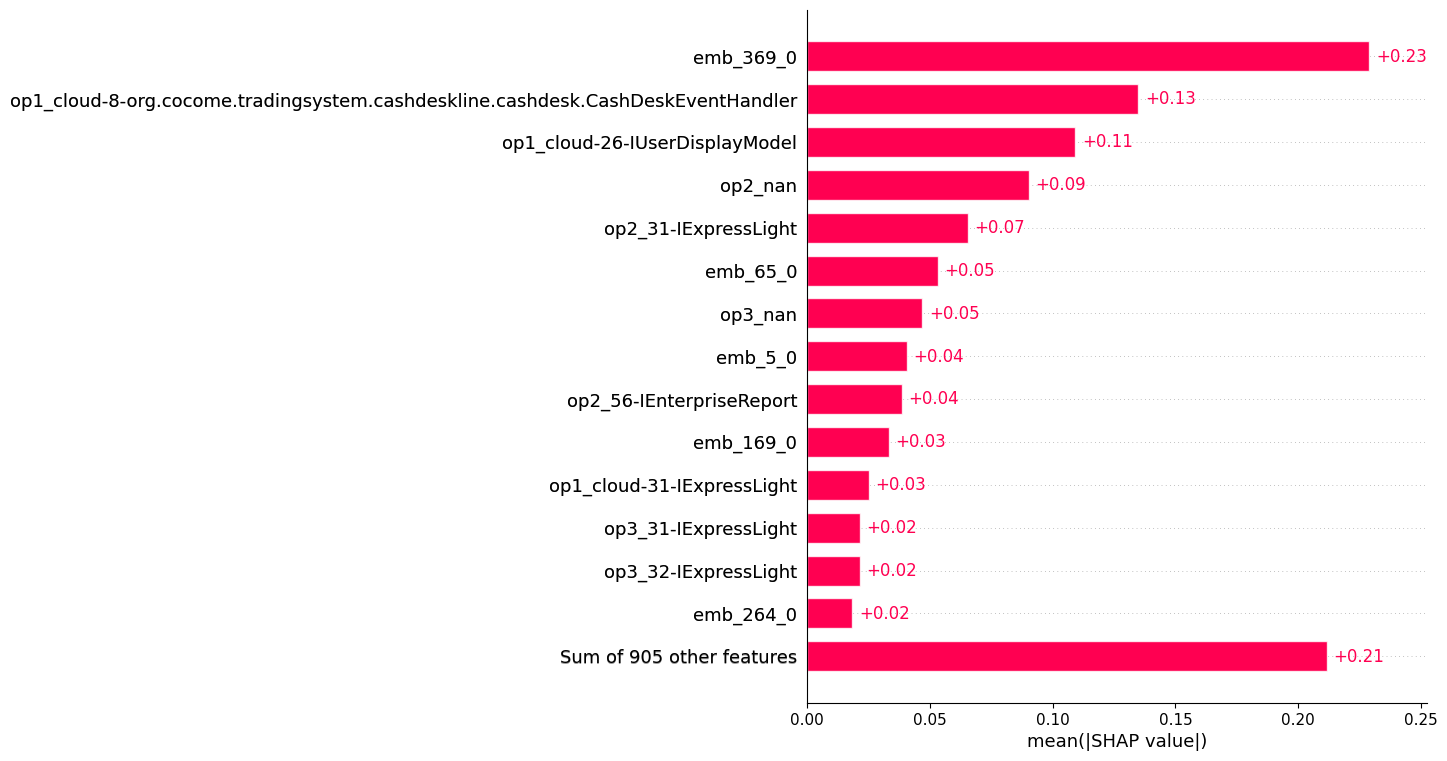

Target: m3


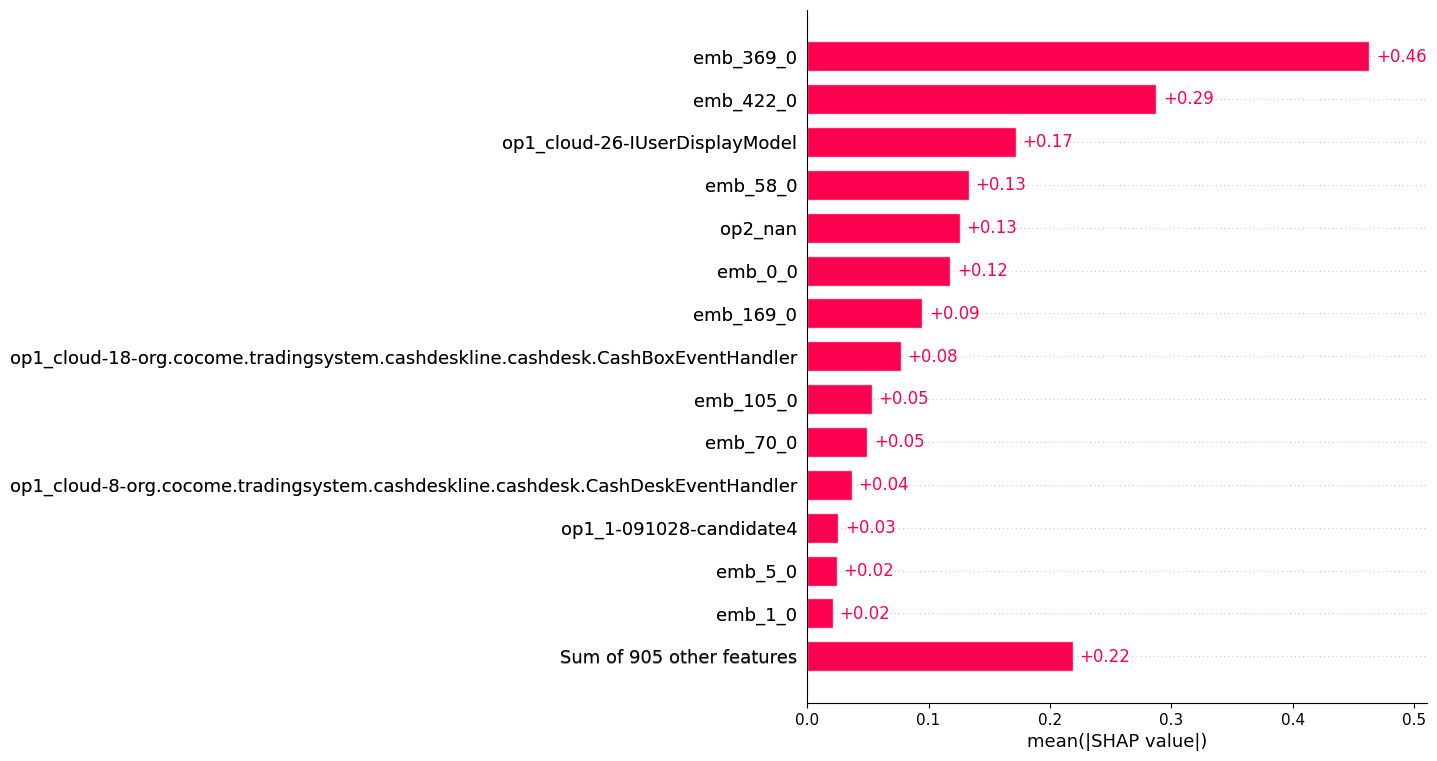

Target: m4


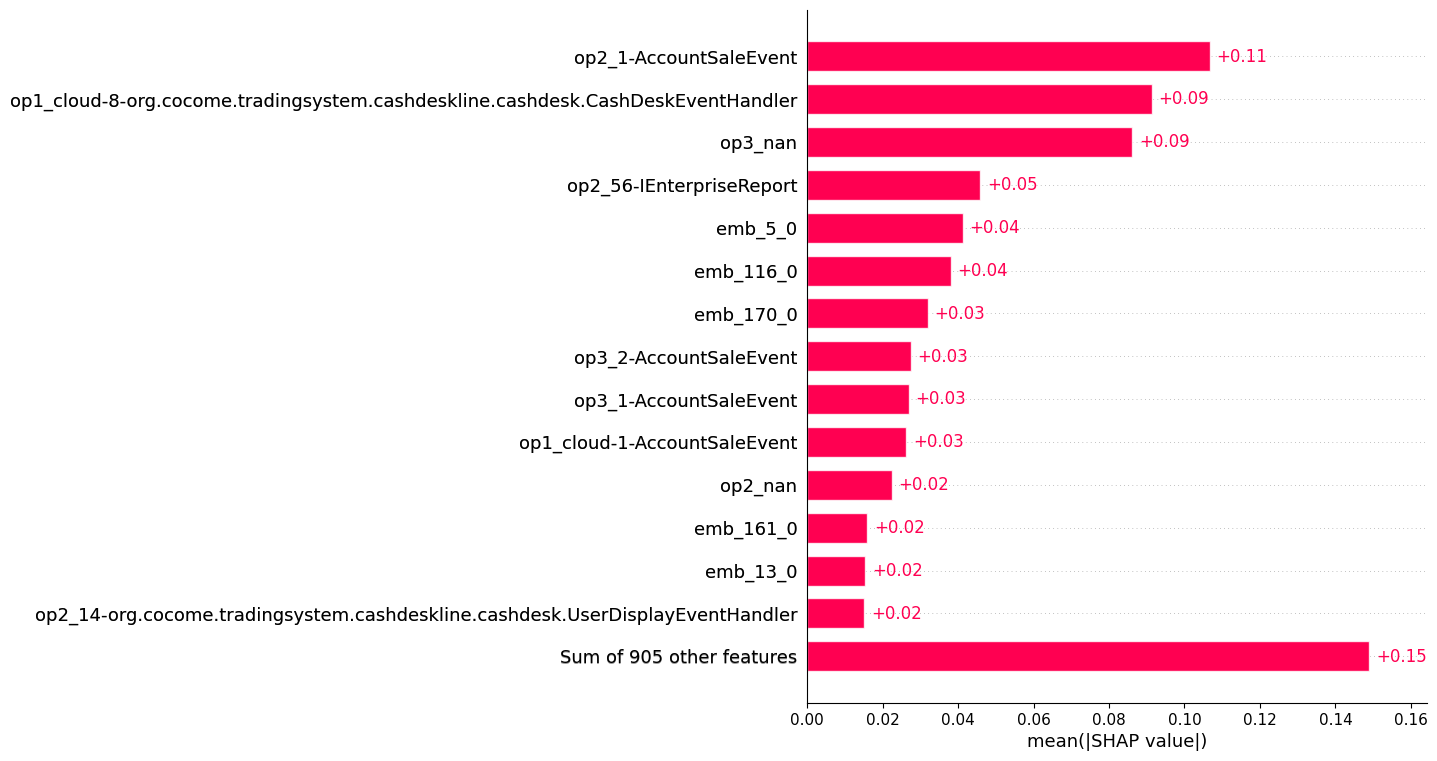

Target: p1


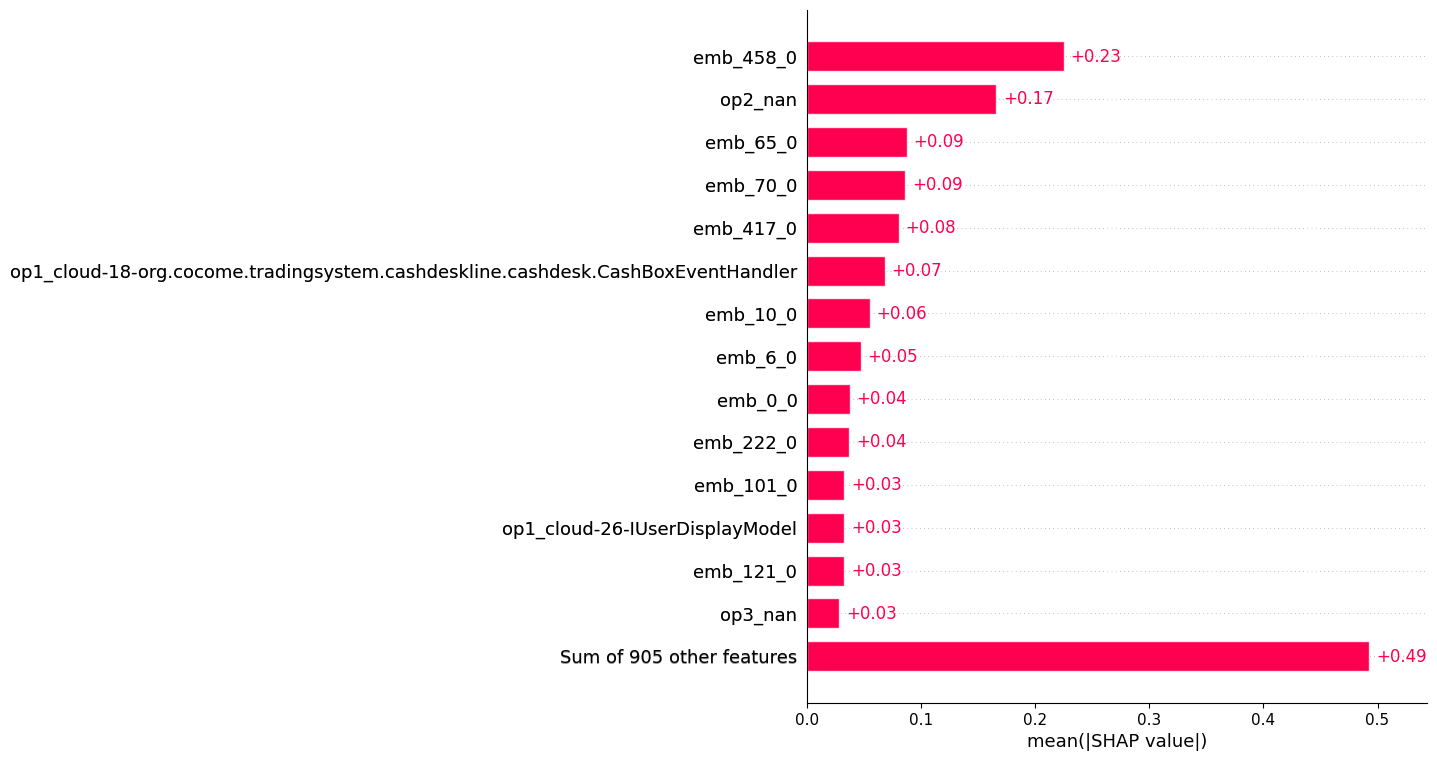

Target: p2


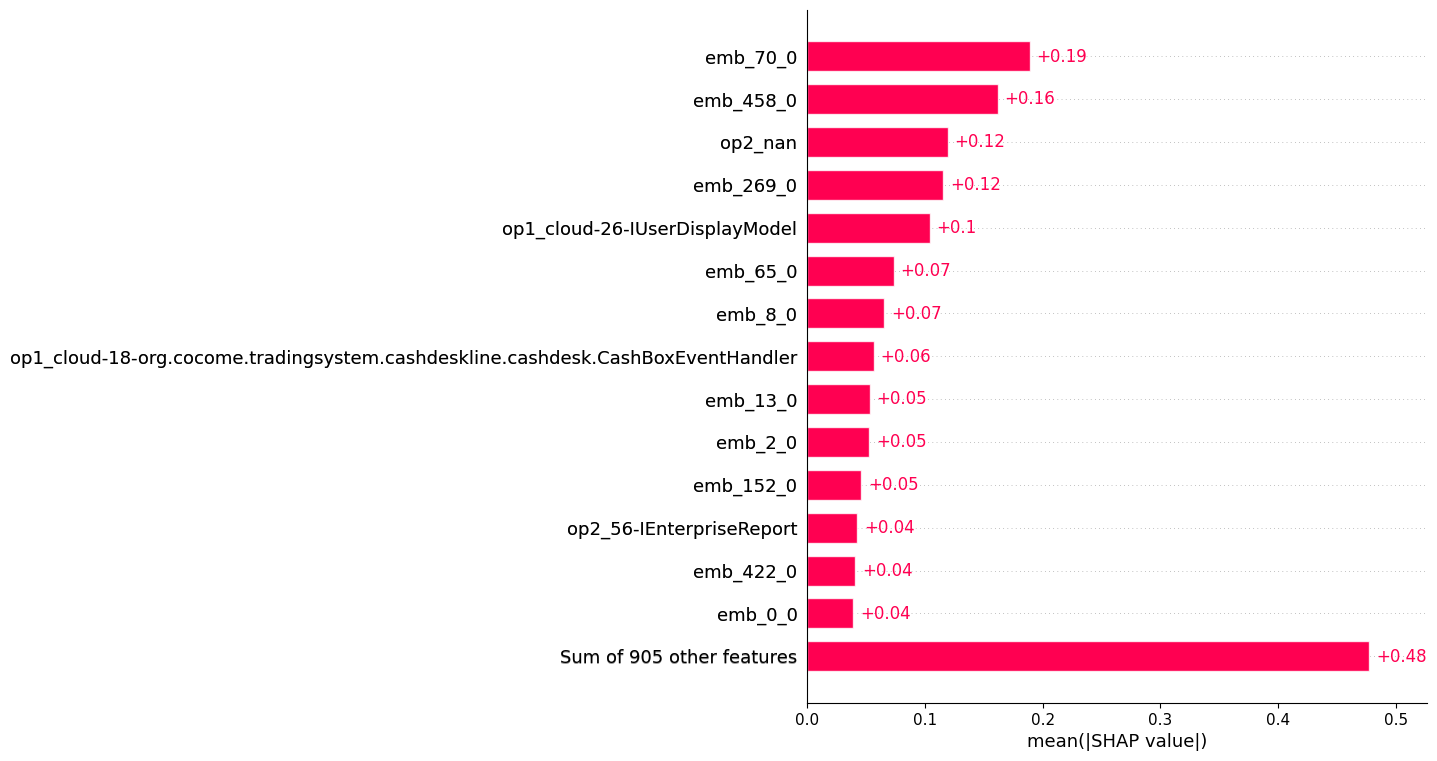

Target: p3


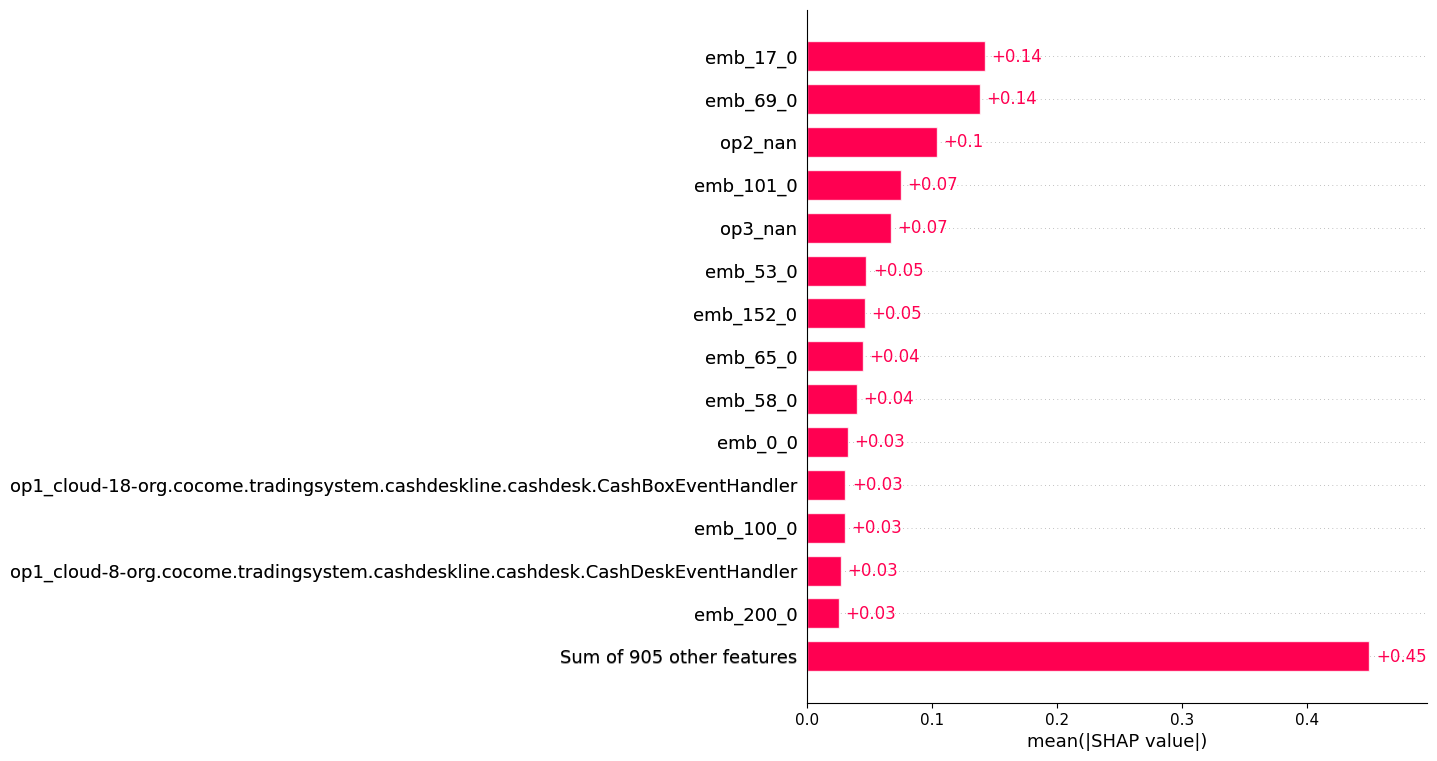

Target: p4


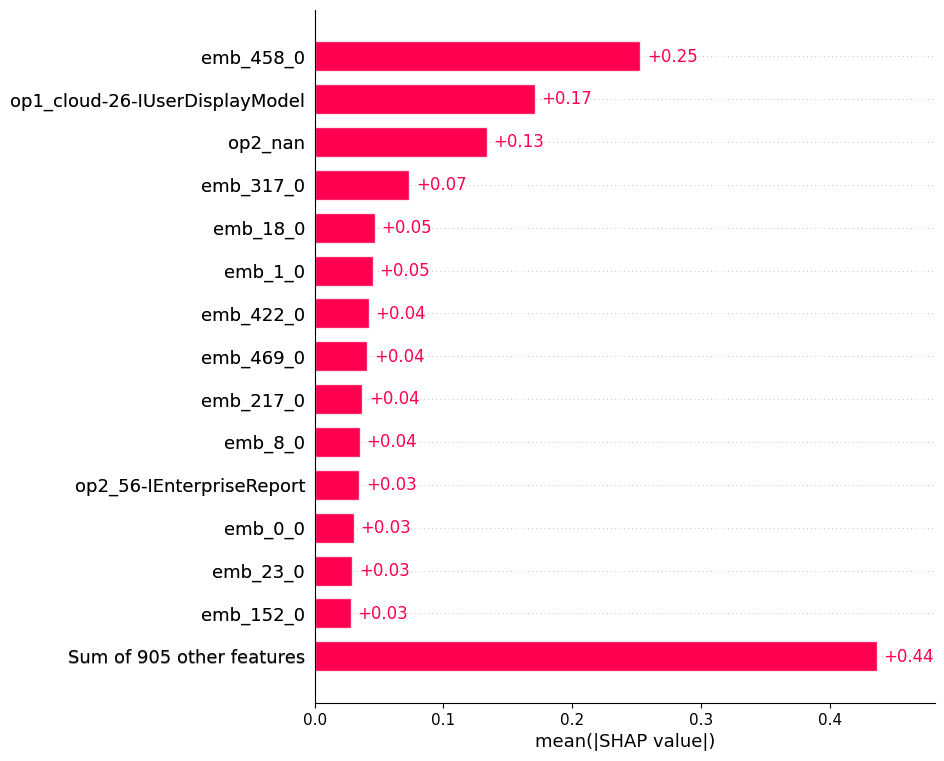

In [25]:
Z = np.concatenate(X, axis=0)
show_shap_plots(Z, fnames, regressor, OBJ_COCOME)

#### Experiments with different values of the SF parameter (n_queries)

In [26]:
print ("COCOME")
print()
target = OBJ_COCOME

# This code snippet is designed to experiment with different values of the sampling
# fraction (SF), represented by the n_queries variable, in an active learning scenario
# for regression tasks. It focuses on the CoCoME dataset and evaluates the performance
# of a machine learning model with varying sampling fractions.

df_list = []
preds_by_sf_cocome = dict()
for n in range(1,6): # Variation of the SF parameter
  print()
  print("-"*50)
  n_queries = n * 0.1
  print("n_queries:", n_queries)

  X, y, _ = get_regression_data(df_cocome, target=target, tactics=True, embeddings=True, split_by_level=True)

  regr_rf = RandomForestRegressor(n_estimators=100, random_state=12, bootstrap=True)
  regr_xgb = XGBRegressor(n_estimators=100, random_state=12, tree_method='approx', update='refresh', refresh_leaf=True, process_type='default')
  regressor = regr_xgb # regr_rf # regr_xgb

  metrics, y_pred = run_active_learning_batches(X, y, regressor, n_queries=n_queries, calibration=True, show_plots=None, target=target, verbose=False)
  df_metrics = pd.DataFrame(metrics)
  df_metrics['n_queries'] = n_queries
  df_list.append(df_metrics)
  preds_by_sf_cocome[n_queries] = y_pred

print()
print("="*10, "RESULTS COCOME:")
df_metrics_cocome = pd.concat(df_list).reset_index(drop=True)
df_metrics_cocome

COCOME


--------------------------------------------------
n_queries: 0.1
standard scaling y ... 5
max 0.1 percentage - queries
Batch 0: (125, 919) (125, 8)
Batch 0: Initial training with 125 points - 125 instances
Regressor score=1.00 

Initial metrics:
R2= 0.7532057618725092
MSE= 0.24679423812749096
RMSE= 0.49678389479480006
MAE= 0.05136847365880517
MAPE= 0.02558517225799252

Batch  1 : (344, 919) (344, 8)
max 34 queries
Selecting indices at random!
0.1 34 queries: [54, 315, 333, 269, 126, 138, 130, 149, 37, 337, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 133, 184, 323, 264, 76, 82, 282, 340, 339, 140, 84, 5, 35, 62]
Batch 1: Adjusted after 34 queries - 344 instances

Adjusted metrics:
R2= 0.16428446229450372
MSE= 0.8357155377054962
RMSE= 0.9141747850960976
MAE= 0.3116104331240166
MAPE= 1.037542823623183

Batch  2 : (301, 919) (301, 8)
max 30 queries
Selecting indices at random!
0.1 30 queries: [54, 269, 126, 138, 130, 149, 37, 230, 155, 238, 203, 201, 60, 134, 114, 161, 183, 

exp  size  features  queries       time        R2  \
0   incremental - batch 0   125       919      125   0.414297  0.753206   
1   incremental - batch 1   344       919       34   7.565324  0.164284   
2   incremental - batch 2   301       919       30   7.089277  0.679638   
3   incremental - batch 3   120       919       12   8.470123  0.202275   
4   incremental - batch 4   302       919       30   7.549744  0.161403   
5       incremental - all  1192       919      231  31.099262  0.359272   
6   incremental - batch 0   125       919      125   0.408681  0.859639   
7   incremental - batch 1   344       919       69   6.952366  0.181618   
8   incremental - batch 2   301       919       60   7.542406  0.849177   
9   incremental - batch 3   120       919       24   8.185989  0.387688   
10  incremental - batch 4   302       919       60   8.345015  0.253048   
11      incremental - all  1192       919      338  31.444787  0.460131   
12  incremental - batch 0   125       919      125   0.511206  0.979882   
13  incremental - batch 1   344       919      103  10.585189  0.330657   
14  incremental - batch 2   301       919       90   8.881759  0.869483   
15  incremental - batch 3   120       919       36  10.725455  0.496683   
16  incremental - batch 4   302       919       91  10.721985  0.266416   
17      incremental - all  1192       919      445  41.437880  0.535239   
18  incremental - batch 0   125       919      125   0.371764  0.851656   
19  incremental - batch 1   344       919      138   9.732627  0.584144   
20  incremental - batch 2   301       919      120  11.417979  0.892735   
21  incremental - batch 3   120       919       48  10.707041  0.528345   
22  incremental - batch 4   302       919      121  11.122670  0.256665   
23      incremental - all  1192       919      552  43.362861  0.601535   
24  incremental - batch 0   125       919      125   0.358009  0.812014   
25  incremental - batch 1   344       919      172   9.778336  0.613626   
26  incremental - batch 2   301       919      150  11.432075  0.936389   
27  incremental - batch 3   120       919       60  10.984563  0.563881   
28  incremental - batch 4   302       919      151  11.001982  0.452269   
29      incremental - all  1192       919      658  43.564304  0.670045   

         MSE      RMSE       MAE      MAPE  n_queries  
0   0.246794  0.496784  0.051368  0.025585        0.1  
1   0.835716  0.914175  0.311610  1.037543        0.1  
2   0.320362  0.566006  0.095307  0.112944        0.1  
3   0.797725  0.893155  0.491922  2.613625        0.1  
4   0.838597  0.915750  0.411870  0.828125        0.1  
5   0.640728  0.800455  0.273253  0.803555        0.1  
6   0.140361  0.374648  0.029118  0.373689        0.2  
7   0.818382  0.904645  0.299987  0.941231        0.2  
8   0.150823  0.388360  0.052908  0.080438        0.2  
9   0.612312  0.782504  0.419322  1.408063        0.2  
10  0.746952  0.864264  0.414531  0.622130        0.2  
11  0.539869  0.734758  0.250225  0.630501        0.2  
12  0.020118  0.141837  0.016931  0.232529        0.3  
13  0.669343  0.818134  0.284538  0.998954        0.3  
14  0.130517  0.361272  0.054563  0.070618        0.3  
15  0.503317  0.709448  0.380613  1.324059        0.3  
16  0.733584  0.856495  0.414876  0.737976        0.3  
17  0.464761  0.681733  0.241096  0.650770        0.3  
18  0.148344  0.385154  0.048757  0.043596        0.4  
19  0.415856  0.644869  0.261744  0.905224        0.4  
20  0.107265  0.327514  0.048608  0.061921        0.4  
21  0.471655  0.686772  0.365428  1.230333        0.4  
22  0.743335  0.862168  0.412729  0.704417        0.4  
23  0.398465  0.631241  0.234280  0.583774        0.4  
24  0.187986  0.433574  0.042453  0.087305        0.5  
25  0.386374  0.621590  0.246488  0.830607        0.5  
26  0.063611  0.252212  0.032193  0.051487        0.5  
27  0.436119  0.660393  0.354681  1.135213        0.5  
28  0.547731  0.740089  0.375302  0.635641        0.5  
29  0.329955  0.

In [27]:
# Summary of final results
df_metrics_cocome[df_metrics_cocome['exp']=='incremental - all']

exp  size  features  queries       time        R2       MSE  \
5   incremental - all  1192       919      231  31.099262  0.359272  0.640728   
11  incremental - all  1192       919      338  31.444787  0.460131  0.539869   
17  incremental - all  1192       919      445  41.437880  0.535239  0.464761   
23  incremental - all  1192       919      552  43.362861  0.601535  0.398465   
29  incremental - all  1192       919      658  43.564304  0.670045  0.329955   

        RMSE       MAE      MAPE  n_queries  
5   0.800455  0.273253  0.803555        0.1  
11  0.734758  0.250225  0.630501        0.2  
17  0.681733  0.241096  0.650770        0.3  
23  0.631241  0.234280  0.583774        0.4  
29  0.574417  0.214506  0.537189        0.5

In [ ]:
df_metrics_stplus_all = df_metrics_stplus[df_metrics_stplus['exp']=='incremental - all']
df_metrics_stplus_all.to_csv('stplus-incremental-all.csv', index=False)

In [ ]:
df_metrics_cocome_all = df_metrics_cocome[df_metrics_cocome['exp']=='incremental - all']
df_metrics_cocome_all.to_csv('cocome-incremental-all.csv', index=False)

---